### Analysis for cases composite around M2 precip
thersold: 1-day running mean > 5 mm/d

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.ndimage.filters import uniform_filter1d

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind
from matplotlib.ticker import FormatStrFormatter

In [2]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N
    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg

In [5]:
warnings.filterwarnings('ignore')

In [6]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

### Read data_event from written .dat files

In [7]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds_M2.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds_M2.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds_M2.dat'))

In [8]:
os.chdir('/data/willytsai/TQUV_3hr/')
files = glob('*.nc')
lev = xr.open_dataset(files[0]).T.lev # MERRA2 standard level 
del files
os.chdir('/data/willytsai/Cloudfrac_3hr/')
lev_m = np.loadtxt('model_lev.txt')[:,1]# MERRA2 model level, 58 levs [72-15]

In [9]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event < lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event < lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [10]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

### 0. select specific oceanic regions

In [11]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [12]:
len(time_event)

79994

In [13]:
idx_region = event_region(lat_event, lon_event, 50, 90, -10, 10)

In [14]:
time_event = time_event[idx_region]
lat_event = lat_event[idx_region]
lon_event = lon_event[idx_region]

### 1. import events 

In [15]:
os.chdir('/data/willytsai/ISCCP')
# T_all = np.load('T_all_5deg_4ds.mat.npy') #
# q_all = np.load('q_all_5deg_4ds.mat.npy') #
# u_all = np.load('u_all_5deg_4ds.mat.npy') #
# v_all = np.load('v_all_5deg_4ds.mat.npy') #
N_all = np.load('N_all_5deg_4ds_M2.mat.npy') #
SCAIbt_all = np.load('SCAIbt_all_5deg_4ds_M2.mat.npy') #
#bt_all = np.load('bt_all_5deg_4ds_1DRM.mat.npy') #
llws_all = np.load('LLWS_all_5deg_4ds_M2.mat.npy')
prec_all = np.load('prec_all_5deg_4ds_M2.mat.npy')#
#precstd_all = np.load('precstd_all_5deg_4ds.mat.npy')
#precdist_all = np.load('precdist_all_5deg_4ds.mat.npy')
cwv_all = np.load('cwv_all_5deg_4ds_M2.mat.npy') #
#cwvstd_all = np.load('cwvstd_all_5deg_4ds.mat.npy')
#crh_all = np.load('crh_all_5deg_4ds.mat.npy')
#cwvenv_all = np.load('cwvenv_all_5deg_4ds_1DRM.mat.npy')
#cwvcld_all = np.load('cwvcld_all_5deg_4ds_1DRM.mat.npy')

omega_all = np.load('omega_all_5deg_4ds_M2.mat.npy') #
omega_90th_all = np.load('omega_90th_all_5deg_4ds_M2.mat.npy') #
omega_10th_all = np.load('omega_10th_all_5deg_4ds_M2.mat.npy') #

rh_all = np.load('rh_all_5deg_4ds_M2.mat.npy')
cldfrac_all = np.load('cldfrac_all_5deg_4ds_M2.mat.npy') #
#cldfrac_dc_all = np.load('cldfrac_220K_all_5deg_4ds.mat.npy')

div_all  = np.load('div_all_5deg_4ds_M2.mat.npy') #
#vor_all  = np.load('vort_all_5deg_4ds.mat.npy')
cwv_long_all = np.load('cwv_longrad_all_5deg_4ds_M2.mat.npy')
cwv_latg_all = np.load('cwv_latgrad_all_5deg_4ds_M2.mat.npy')
lwtoa_all = np.load('lwtoa_all_5deg_4ds_M2.mat.npy')
swtoa_all = np.load('swtoa_all_5deg_4ds_M2.mat.npy')
lwgnt_all = np.load('lwgnt_all_5deg_4ds_M2.mat.npy')
swgnt_all = np.load('swgnt_all_5deg_4ds_M2.mat.npy')
# CERES radiation
QR_ce_all = np.load('QR_CERES_all_5deg_4ds_M2.mat.npy')
lwtoa_ce_all = np.load('lwtoa_CERES_all_5deg_4ds_M2.mat.npy')

Abar_all = (cldfrac_all/N_all*2500*(10*10))**0.5 # square root of Area [km] #
D0_all = (SCAIbt_all*500*(50**2)/2)/(N_all*1000)
# cape_all = np.load('cape_all_5deg_4ds.mat.npy')
# cin_all = np.load('cin_all_5deg_4ds.mat.npy')

LHF_all = np.load('LHF_all_5deg_4ds_M2.mat.npy') #
SHF_all = np.load('SHF_all_5deg_4ds_M2.mat.npy') #
LHF_WHOI_all = np.load('LHF_WHOI_all_5deg_4ds_M2.mat.npy')
#qvflux_all = np.load('qvflux_all_5deg_4ds_1DRM.mat.npy') #
#cwvtend_all = np.load('cwvten_ten_all_5deg_4ds_1DRM.mat.npy')
bt_dist_all = np.load('bt_dist_all_5deg_4ds_M2.mat.npy')

precM2_all = np.load('precM2_all_5deg_4ds_M2.mat.npy') #

# --------- cwv_dt, long-term perspective ----
cwv_dt_all = np.load('cwv_dt_2510ds_all_5deg_4ds_M2.mat.npy')
cwv_rm_all = np.load('cwv_2510ds_all_5deg_4ds_M2.mat.npy')

### 1-d running mean for precip

In [16]:
for n in range(len(time_event)):
    precM2_all[n,:] = running_mean(precM2_all[n,:],8)
    prec_all[n,:] = running_mean(prec_all[n,:],8)

### ------

In [17]:
def center_case(time_event,lon_event,lat_event,cri_r=250,ratio=0.5):
    'precipitation area is enclosed within a circle R at reference time'
    
    file_path = TRMM_dir+'2014_2018'
    time_cent = time_event
    lat_cent = lat_event
    lon_cent = lon_event
    
    # read preciptation data in the given domain
    data = subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=0,lat_inc=2.5,lon_inc=2.5)
    prec_sm = data.precipitation.squeeze()
    prec_sum = np.nansum(prec_sm)

    # calculate the distance matrix
    x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
    dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]
    prec_sm.values[dist > cri_r] = 0
    prec_frac = (np.nansum(prec_sm)/prec_sum)
    
    if prec_frac >= ratio:
        result = 1
    else:
        result = 0

    return result

In [18]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        tmp = np.fft.fft(data_all[n,:]) # 49
        freqs = np.array(range(NT))   # This gets the left end correct
        reversed_freqs = freqs[::-1]  # Reverse the array 
        reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
        freqs = reversed_freqs[::-1]  # reverse it back 
        tmp[np.where(freqs==4)] = 0 # remove diurnal 4 cycles for 4 days
        tmp[np.where(freqs==8)] = 0 # remove half-day, 4*2
        tmp_re[n,:] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [19]:
def remove_diurnal_2D(data_all):
    'remove diurnal cycle in the time series [N,time,lev], N cases'
    
    tmp_re = np.copy(data_all)
    NT = data_all.shape[1]
    
    for n in range(data_all.shape[0]):
        for k in range(data_all.shape[2]):
            tmp = np.fft.fft(data_all[n,:,k]) # 49
            freqs = np.array(range(NT))   # This gets the left end correct
            reversed_freqs = freqs[::-1]  # Reverse the array 
            reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
            freqs = reversed_freqs[::-1]  # reverse it back 
            tmp[np.where(freqs==4)] = 0 # remove diurnal 6 cycles for 6 days
            tmp[np.where(freqs==8)] = 0 # remove half-day
            tmp_re[n,:,k] = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [20]:
# match regions 
# T_all = T_all[idx_region,:,:]
# q_all = q_all[idx_region,:,:]
# u_all = u_all[idx_region,:,:]
# v_all = v_all[idx_region,:,:]
N_all = N_all[idx_region,:]
SCAIbt_all = SCAIbt_all[idx_region,:]
#bt_all = bt_all[idx_rm,:]
llws_all = llws_all[idx_region,:]
prec_all = prec_all[idx_region,:]
# precstd_all = precstd_all[idx_region,:]
# precdist_all = precdist_all[idx_region,:]
cwv_all = cwv_all[idx_region,:]
# cwvstd_all = cwvstd_all[idx_region,:]
# crh_all = crh_all[idx_region,:]
#cwvenv_all = cwvenv_all[idx_rm,:]
#cwvcld_all = cwvcld_all[idx_rm,:]

omega_all = omega_all[idx_region,:,:]
#omega_mn_all = omega_mn_all[idx_region,:,:]
omega_90th_all = omega_90th_all[idx_region,:,:]
omega_10th_all = omega_10th_all[idx_region,:,:]

rh_all = rh_all[idx_region,:,:]
#cwvstd_all = cwvstd_all[idx_rm,:]

cldfrac_all = cldfrac_all[idx_region,:]
#cldfrac_dc_all = cldfrac_dc_all[idx_rm,:]
div_all = div_all[idx_region,:,:]
#vor_all = vor_all[idx_region,:,:]
cwv_long_all = cwv_long_all[idx_region,:] 
cwv_latg_all = cwv_latg_all[idx_region,:]
lwtoa_all = lwtoa_all[idx_region,:]
swtoa_all = swtoa_all[idx_region,:]
lwgnt_all = lwgnt_all[idx_region,:]
swgnt_all = swgnt_all[idx_region,:]
QR_ce_all = QR_ce_all[idx_region,:]
lwtoa_ce_all = lwtoa_ce_all[idx_region,:]

Abar_all = Abar_all[idx_region,:]
D0_all = D0_all[idx_region,:]
#cape_all = cape_all[idx_region,:]
#cin_all = cin_all[idx_region,:]

# cldamt_call_all = cldamt_call_all[idx_rm,:]
# cldamt_cu_all = cldamt_cu_all[idx_rm,:]
# cldamt_st_all = cldamt_st_all[idx_rm,:]
# cldamt_dc_all = cldamt_dc_all[idx_rm,:]

#qvflux_all = qvflux_all[idx_rm,:,:]
SHF_all = SHF_all[idx_region,:]
LHF_all = LHF_all[idx_region,:]
LHF_WHOI_all = LHF_WHOI_all[idx_region,:]

#cwvtend_all = cwvtend_all[idx_rm,:]
bt_dist_all = bt_dist_all[idx_region,:]

precM2_all = precM2_all[idx_region,:]
cwv_dt_all = cwv_dt_all[idx_region,:]
cwv_rm_all = cwv_rm_all[idx_region,:]

#### remove cloud coverage 0 mismatched cases, SCAI with NAN

In [21]:
idx_rm = np.arange(len(time_event))
idx_cld0 = np.where(cldfrac_all[:,16]==0)[0] # cldfrac = 0
idx_scai = np.where(np.isnan(SCAIbt_all[:,16])==1)[0] # SCAI = NaN

idx_rm = np.setdiff1d(idx_rm, idx_cld0) # remove index with all weird cases
idx_rm = np.setdiff1d(idx_rm, idx_scai) # remove index with all weird cases

In [22]:
#remove precM2 failed to represent TRMM prec...
#cri_pdiff = 0.2
#pdiff = np.abs((24*prec_all[:,16]-24*3600*precM2_all[:,16])/24*prec_all[:,16])
#idx_pdiff = np.where(pdiff>cri_pdiff)[0]

In [23]:
#idx_rm = np.setdiff1d(idx_rm, idx_pdiff) # remove index with all weird cases
#len(idx_rm)

In [24]:
time_event = time_event[idx_rm]
lat_event = lat_event[idx_rm]
lon_event = lon_event[idx_rm]

# T_all = T_all[idx_rm,:,:]
# q_all = q_all[idx_rm,:,:]
# u_all = u_all[idx_rm,:,:]
# v_all = v_all[idx_rm,:,:]
N_all = N_all[idx_rm,:]
SCAIbt_all = SCAIbt_all[idx_rm,:]
#bt_all = bt_all[idx_rm,:]
llws_all = llws_all[idx_rm,:]
prec_all = prec_all[idx_rm,:]
#precstd_all = precstd_all[idx_rm,:]
#precdist_all = precdist_all[idx_rm,:]
cwv_all = cwv_all[idx_rm,:]
#cwvstd_all = cwvstd_all[idx_rm,:]
#crh_all = crh_all[idx_rm,:]
#cwvenv_all = cwvenv_all[idx_rm,:]
#cwvcld_all = cwvcld_all[idx_rm,:]

omega_all = omega_all[idx_rm,:,:]
#omega_mn_all = omega_mn_all[idx_rm]
omega_90th_all = omega_90th_all[idx_rm,:,:]
omega_10th_all = omega_10th_all[idx_rm,:,:]

rh_all = rh_all[idx_rm,:,:]
#cwvstd_all = cwvstd_all[idx_rm,:]

cldfrac_all = cldfrac_all[idx_rm,:]
#cldfrac_dc_all = cldfrac_dc_all[idx_rm,:]
div_all = div_all[idx_rm,:,:]
#vor_all = vor_all[idx_rm,:,:]
cwv_long_all = cwv_long_all[idx_rm,:]*100000 # mm/deg
cwv_latg_all = cwv_latg_all[idx_rm,:]*100000 # mm/deg
lwtoa_all = lwtoa_all[idx_rm,:]
swtoa_all = swtoa_all[idx_rm,:]
lwgnt_all = lwgnt_all[idx_rm,:]
swgnt_all = swgnt_all[idx_rm,:]
QR_ce_all = QR_ce_all[idx_rm,:]
lwtoa_ce_all = lwtoa_ce_all[idx_rm,:]

Abar_all = Abar_all[idx_rm,:]
D0_all = D0_all[idx_rm,:]
# cape_all = cape_all[idx_rm,:]
# cin_all = cin_all[idx_rm,:]

# cldamt_call_all = cldamt_call_all[idx_rm,:]
# cldamt_cu_all = cldamt_cu_all[idx_rm,:]
# cldamt_st_all = cldamt_st_all[idx_rm,:]
# cldamt_dc_all = cldamt_dc_all[idx_rm,:]

#qvflux_all = qvflux_all[idx_rm,:,:]
SHF_all = SHF_all[idx_rm,:]
LHF_all = LHF_all[idx_rm,:]
LHF_WHOIall = LHF_WHOI_all[idx_rm,:]

#cwvtend_all = cwvtend_all[idx_rm,:]
bt_dist_all = bt_dist_all[idx_rm,:]

precM2_all = precM2_all[idx_rm,:]
cwv_dt_all = cwv_dt_all[idx_rm,:]
cwv_rm_all = cwv_rm_all[idx_rm,:]

In [25]:
omega_all = remove_diurnal_2D(omega_all)
#omega_mn_all = remove_diurnal_2D(omega_mn_all)
omega_90th_all = remove_diurnal_2D(omega_90th_all)
omega_10th_all = remove_diurnal_2D(omega_10th_all)

In [26]:
# linear interpolation for MERRA2 flux fields: precM2, SHF, and LHF 
LHF_allre = np.zeros(cwv_all.shape)
SHF_allre = np.copy(LHF_allre)
precM2_allre = np.copy(LHF_allre)
cwvtend_allre = np.copy(LHF_allre)
lwtoa_allre = np.copy(LHF_allre)
swtoa_allre = np.copy(LHF_allre)
lwgnt_allre = np.copy(LHF_allre)
swgnt_allre = np.copy(LHF_allre)
QR_ce_allre = np.copy(LHF_allre)
lwtoa_ce_allre = np.copy(LHF_allre)

for n in range(len(time_event)):
    x = np.linspace(-48,48,32); x2 = np.linspace(-48,48,96)
    xnew = np.linspace(-48,48,33)
    f1 = interpolate.interp1d(x, LHF_all[n,:], kind='linear')
    f2 = interpolate.interp1d(x, SHF_all[n,:], kind='linear')
    f3 = interpolate.interp1d(x, precM2_all[n,:], kind='linear')
#    f4 = interpolate.interp1d(x2, cwvtend_all[n,:], kind='linear')
    f5 = interpolate.interp1d(x, lwtoa_all[n,:], kind='linear')
    f6 = interpolate.interp1d(x, swtoa_all[n,:], kind='linear')
    f7 = interpolate.interp1d(x, lwgnt_all[n,:], kind='linear')
    f8 = interpolate.interp1d(x, swgnt_all[n,:], kind='linear')
    f9 = interpolate.interp1d(x, QR_ce_all[n,:], kind='linear')
    f10 = interpolate.interp1d(x, lwtoa_ce_all[n,:], kind='linear')
    
    LHF_allre[n,:] = f1(xnew)
    SHF_allre[n,:] = f2(xnew)
    precM2_allre[n,:] = f3(xnew) 
#    cwvtend_allre[n,:] = f4(xnew)
    lwtoa_allre[n,:] = f5(xnew)
    swtoa_allre[n,:] = f6(xnew)
    lwgnt_allre[n,:] = f7(xnew)
    swgnt_allre[n,:] = f8(xnew)
    QR_ce_allre[n,:] = f9(xnew)
    lwtoa_ce_allre[n,:] = f10(xnew)    
    
LHF_all = LHF_allre; # replace it back
SHF_all = SHF_allre; 
precM2_all = precM2_allre; 
#cwvtend_all = cwvtend_allre;
lwtoa_all = lwtoa_allre
swtoa_all = swtoa_allre
lwgnt_all = lwgnt_allre
swgnt_all = swgnt_allre
QR_ce_all = QR_ce_allre
lwtoa_ce_all = lwtoa_ce_allre

In [27]:
## deal with qvflux at the first level
# for n in range(len(time_event)):
#     for t in range(33):
#         if np.isnan(qvflux_all[n,t,0]) == True:
#             qvflux_all[n,t,0] = qvflux_all[n,t,1]

In [28]:
## remove wrong values
# idx = np.where(np.logical_or(cldamt_call_all>100,cldamt_call_all<0))
# cldamt_call_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_cu_all>100,cldamt_cu_all<0))
# cldamt_cu_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_st_all>100,cldamt_st_all<0))
# cldamt_st_all[idx] = np.nan
# idx = np.where(np.logical_or(cldamt_dc_all>100,cldamt_dc_all<0))
# cldamt_dc_all[idx] = np.nan

In [29]:
prec_all.shape

(16922, 33)

### organization indices

In [30]:
def idx_group(var1_all,v1_lbound,v1_ubound,var2_all,v2_lbound,v2_ubound):
    
    idx1 = np.where(np.logical_and(var1_all[:,16]>=v1_lbound,var1_all[:,16]<v1_ubound))[0]
    idx2 = np.where(np.logical_and(var2_all[:,16]>=v2_lbound,var2_all[:,16]<v2_ubound))[0]
    idx = np.intersect1d(idx1,idx2)
    
    return idx

In [31]:
# # event separation by cloud cover (convective scale) and CRH 
# idx_G1 = idx_group(24*prec_all,5,20,cwv_all,0,100)
# idx_G2 = idx_group(24*prec_all,20,35,cwv_all,0,100)
# idx_G3 = idx_group(24*prec_all,35,50,cwv_all,0,100)
# idx_G4 = idx_group(24*prec_all,50,65,cwv_all,0,100)
# idx_G5 = idx_group(24*prec_all,65,80,cwv_all,0,100)

In [32]:
# # event separation by cloud cover (convective scale) and CRH 
# idx_G1 = idx_group(cldfrac_all,0,0.2,cwv_all,0,100)
# idx_G2 = idx_group(cldfrac_all,0.2,0.4,cwv_all,0,100)
# idx_G3 = idx_group(cldfrac_all,0.4,0.6,cwv_all,0,100)
# idx_G4 = idx_group(cldfrac_all,0.6,0.8,cwv_all,0,100)
# idx_G5 = idx_group(cldfrac_all,0.8,1,cwv_all,0,100)

In [33]:
cf_bins = np.linspace(0,1,26)
SCAI_bins = np.linspace(0,20,26)
num_com = np.zeros((len(cf_bins)-1,len(SCAI_bins)-1))
cwv_com = np.copy(num_com)

for i in range(len(cf_bins)-1):
    for j in range(len(SCAI_bins)-1):
        idx = np.where(np.logical_and(cldfrac_all[:,16]>=cf_bins[i],cldfrac_all[:,16]<cf_bins[i+1]))[0]
        idy = np.where(np.logical_and(SCAIbt_all[:,16]>=SCAI_bins[j],SCAIbt_all[:,16]<SCAI_bins[j+1]))[0]
        idx_com = np.intersect1d(idx,idy)
        num_com[i,j] = len(idx_com)
        
        cwv_com[i,j] = np.nanmean(cwv_all[idx_com,16],axis=0)

In [34]:
prec_bins = np.linspace(5,110,22)
SCAI_bins = np.linspace(0,20,26)
nump_com = np.zeros((len(prec_bins)-1,len(SCAI_bins)-1))
cwv_com = np.copy(nump_com)

for i in range(len(prec_bins)-1):
    for j in range(len(SCAI_bins)-1):
        idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins[i],86400*precM2_all[:,16]<prec_bins[i+1]))[0]
        idy = np.where(np.logical_and(SCAIbt_all[:,16]>=SCAI_bins[j],SCAIbt_all[:,16]<SCAI_bins[j+1]))[0]
        idx_com = np.intersect1d(idx,idy)
        nump_com[i,j] = len(idx_com)
        
        cwv_com[i,j] = np.nanmean(cwv_all[idx_com,16],axis=0)

In [35]:
nump_mask = np.copy(np.log10(nump_com/np.sum(nump_com)))
nump_mask[nump_mask<-4] = np.nan

cwv_mask = np.copy(cwv_com)
cwv_mask[np.log10(nump_com/np.sum(nump_com))<-4] = np.nan

### Prec Categories

In [36]:
prec_bins2 = np.linspace(5,25,5)
#prec_bins2 = np.linspace(5,25,5)
p_labels=['5-10','10-15','15-20','20-25']
#p_labels=['5-10','10-15','15-20','20-25']
mark_labels=['x','o','^','s']

#### -------------

In [37]:
## sorting SCAI with fixed range of precip
SCAI_bins = np.linspace(0,20,26)

SCAI_deciles_p = np.zeros((len(prec_bins2)-1,10))

for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]
    SCAI_tmp = SCAIbt_all[idx,16]
    #idx_sorted = np.argsort(SCAI_sorted)
    
    # SCAI deciles
    SCAI_deciles_p[i,:] = np.percentile(SCAI_tmp,np.arange(0, 100, 10))

In [38]:
# fig = plt.figure(figsize=(6,5))
# plt.contourf(cf_bins[:-1],SCAI_bins[:-1]+0.05,num_mask.T
#              ,levels=np.linspace(-3.5,-1.5,9),cmap='binary')
# cbar = plt.colorbar(shrink=0.8); cbar.set_label('Log$_{10}$(Prabability)',fontsize=12)

# # add SCAI deciles 
# labels=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
# for n in range(5):
#     xbin = np.tile(cf_bins2[n],10)
#     plt.plot(xbin+0.1,SCAI_deciles[n,:],'-o',label=labels[n])

# plt.xlabel('Cloud coverage',fontsize=15)
# plt.ylabel('SCAI',fontsize=15)
# plt.tick_params(labelsize=12)
# plt.legend(framealpha=0.0)#;plt.grid(linewidth=1)
# plt.ylim([0,12]);plt.xlim([0,1])
# #fig.savefig(fig_dir+'SCAI_cldfrac_hist.pdf',bbox_inches='tight')

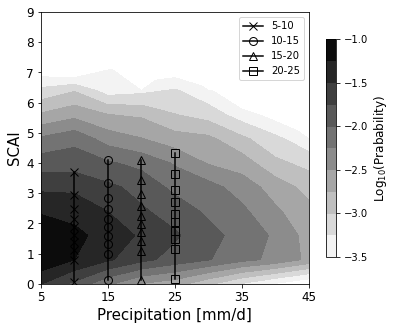

In [39]:
fig = plt.figure(figsize=(6,5))
plt.contourf(prec_bins[:-1],SCAI_bins[:-1],nump_mask.T
             ,levels=np.linspace(-3.5,-1,11),cmap='binary')
cbar = plt.colorbar(shrink=0.8); cbar.set_label('Log$_{10}$(Prabability)',fontsize=12)
# add SCAI deciles 
for n in range(len(prec_bins2)-1):
    xbin = np.tile(prec_bins2[n],10)
    plt.plot(xbin+5,SCAI_deciles_p[n,:],'-ok',marker=mark_labels[n],
             markersize=8,markerfacecolor='none',label=p_labels[n])

plt.xticks([5,15,25,35,45])
plt.xlabel('Precipitation [mm/d]',fontsize=15)
plt.ylabel('SCAI',fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()#;plt.grid(linewidth=1)
plt.ylim([0,9]);plt.xlim([5,45]);
#plt.xticks([5,20,35,50,65,80,95]);
#fig.savefig(fig_dir+'SCAI_cldfrac_hist.pdf',bbox_inches='tight')

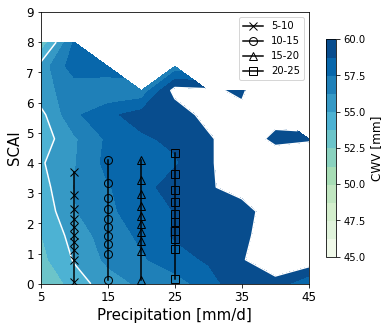

In [40]:
fig = plt.figure(figsize=(6,5))
plt.contourf(prec_bins[:-1],SCAI_bins[:-1],cwv_mask.T,levels=np.linspace(45,60,13)
            ,cmap='GnBu')
cbar = plt.colorbar(shrink=0.8); cbar.set_label('CWV [mm]',fontsize=12)
                                                
# add SCAI deciles 
#labels=['5-20','20-35','35-50','50-65','65-80']
for n in range(len(prec_bins2)-1):
    xbin = np.tile(prec_bins2[n],10)
    plt.plot(xbin+5,SCAI_deciles_p[n,:],'-ok',color='k',marker=mark_labels[n],
             markersize=8,markerfacecolor='none',label=p_labels[n])
plt.contour(prec_bins[:-1],SCAI_bins[:-1],cwv_mask.T,colors='w',levels=['45','50','55','60'])

plt.xticks([5,15,25,35,45])
plt.xlabel('Precipitation [mm/d]',fontsize=15)
plt.ylabel('SCAI',fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()#;plt.grid(linewidth=1)
plt.ylim([0,9]);plt.xlim([5,45]);

In [41]:
# %%time

# date = []; date_begin = datetime(2014,1,1)
# for t in range(14608):
#     tmp = date_begin + t*timedelta(hours=3)
#     date.append(tmp)
    
# # TRMM3B42 dataset 2014, 3hrly separate
# prec_3hr = np.nan*np.zeros((len(date),241,1440))

# n=1
# os.chdir(TRMM_dir+'2014_2018')
# files = sorted(glob('3B42.*'))
# for file in files:
#     data = xr.open_dataset(file).precipitation        
#     prec_3hr[n-1,:,:] = data.values.swapaxes(0,1)
#     n+=1
# lon = data.nlon; lat = data.nlat
# prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del prec_3hr

In [42]:
# prec_clim = prec_xr.mean(axis=0)

In [43]:
# %%time
# # TRMM3B42 dataset 2014, 3hrly separate
# os.chdir('/data2/willytsai/MERRA2/inst_2d_hourly/')

# n=1
# files = sorted(glob('*.nc'))
# cwv_3hr = np.nan*np.zeros((len(files),41,576))
# for file in files:
#     try:
#         data = xr.open_dataset(file).TQV        
#         cwv_3hr[n-1,:,:] = data.sel(lat=slice(-10,10)).values.mean(axis=0)
#     except:
#         cwv_3hr[n-1,:,:] = np.nan
#     n+=1
# nlon = data.lon; nlat = data.sel(lat=slice(-10,10)).lat
# #cwv_xr = xr.DataArray(cwv_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del cwv_3hr

In [44]:
# test = xr.Dataset({'TQV': (('lat','lon'),cwv_clim)},
#                     coords={'lat': nlat.values, 'lon': nlon.values})

In [45]:
# os.chdir('/data2/willytsai/ISCCP')
# test.to_netcdf('cwvmap_climatology.nc')

In [46]:
# different catagory 
def freq_map_cat(lon_event,lat_event):
   
    lat_bin = np.linspace(-7.5,7.5,7)
    lon_bin = np.linspace(-177.5,177.5,143)

    freq_map = np.zeros((len(lon_bin),len(lat_bin)))

    for i in range(len(lon_bin)):
        for j in range(len(lat_bin)):
            idx = np.where(lon_event == lon_bin[i])[0]
            idy = np.where(lat_event == lat_bin[j])[0]
            
            if (lon_bin[i] >= 90) & (lon_bin[i]<=150): # remove maritime continent
                freq_map[i,j] = np.nan

            if len(np.intersect1d(idx,idy)) > 0:
                freq_map[i,j] += len(np.intersect1d(idx,idy))
    
    freq_map_re = np.zeros((145,7))
    freq_map_re[:143,:] = freq_map
    freq_map_re[143,:] = (freq_map[0,:]+freq_map[-1,:])/2
    freq_map_re[144,:] = (freq_map[0,:]+freq_map[-1,:])/2    
    freq_map_re = np.vstack([freq_map_re.T,np.zeros((freq_map_re.shape[0])).T]).T
    
    return freq_map_re

In [47]:
# record index of SCAI decile for global maps
pscai_idx_g1 = []
pscai_idx_g2 = []
pscai_idx_g3 = []
#pscai_idx_g4 = []
#pscai_idx_g5 = []

for i in range(len(prec_bins2)-1):
    idx_p = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
    
    for n in range(10):
        if n < 9:
            idx_dec = np.where(np.logical_and(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n],SCAIbt_all[:,16] < SCAI_deciles_p[i,n+1]))[0]
        else:
            idx_dec = np.where(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n])[0]
        idx_com = np.intersect1d(idx_p, idx_dec)
    
        if i == 0:
            pscai_idx_g1.append(idx_com)
        if i == 1:
            pscai_idx_g2.append(idx_com)        
        if i == 2:
            pscai_idx_g3.append(idx_com)
#         if i == 3:
#             pscai_idx_g4.append(idx_com)
#         if i == 4:
#             pscai_idx_g5.append(idx_com)

In [48]:
os.chdir('/data2/willytsai/ISCCP')
cwv_data = xr.open_dataset('cwvmap_climatology.nc')
cwv_clim = cwv_data.TQV
prec_data = xr.open_dataset('precmap_climatology.nc')
prec_clim = prec_data.precipitation

idx = np.where(np.logical_and(cwv_clim.lon>90, cwv_clim.lon<150))[0]
cwv_clim[:,idx] = np.nan
idx = np.where(np.logical_and(prec_clim.lon>90, prec_clim.lon<150))[0]
prec_clim[:,idx] = np.nan

In [49]:
lat_bin = np.linspace(-8.75,8.75,8)
lon_bin = np.linspace(-178.75,181.25,145)
freq_map = []

freq_map_tot =  freq_map_cat(lon_event,lat_event)
for i in range(10):
    freq_map.append(freq_map_cat(lon_event[pscai_idx_g1[i]],lat_event[pscai_idx_g1[i]]))

In [50]:
cmap_cus = ListedColormap(['white','whitesmoke','lightgrey','darkgrey','royalblue','green','mediumseagreen',
'greenyellow','yellow','gold','orange','darkorange','red','firebrick'])

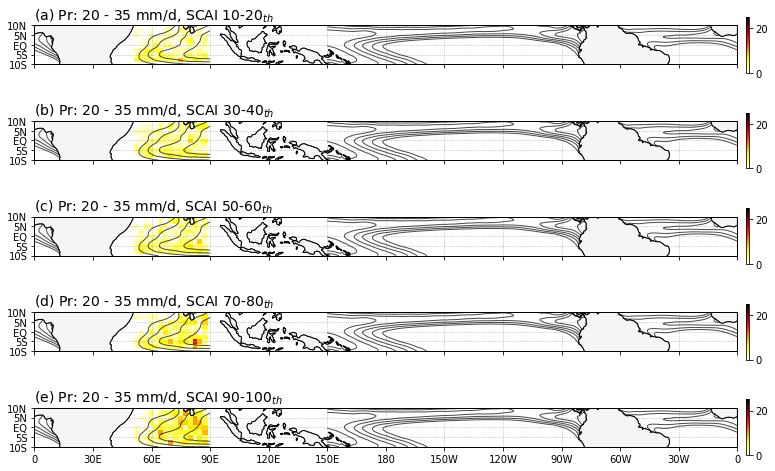

In [51]:
titles = ['(a) Pr: 20 - 35 mm/d, SCAI 10-20$_{th}$','(b) Pr: 20 - 35 mm/d, SCAI 30-40$_{th}$',
          '(c) Pr: 20 - 35 mm/d, SCAI 50-60$_{th}$','(d) Pr: 20 - 35 mm/d, SCAI 70-80$_{th}$',
          '(e) Pr: 20 - 35 mm/d, SCAI 90-100$_{th}$']

fig,ax = plt.subplots(5,1,figsize=(15,8.5)
        ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

for i,freq in enumerate([freq_map[1],freq_map[3],freq_map[5],freq_map[7],freq_map[9]]):
    
    ax[i].coastlines()
    ax[i].add_feature(cfeat.LAND,zorder=2,edgecolor='k',facecolor='whitesmoke') # maskout LAND
    ax[i].set_facecolor('snow')
    
#    cf = ax[i].contourf(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
#                        ,cmap=cmap_cus,levels=np.linspace(0,10,11))
    cf = ax[i].pcolor(lon_bin,lat_bin,freq.T[:,:],transform=ccrs.PlateCarree()
                        ,cmap='hot_r',vmax=25)
        
    cwv_con,lon = add_cyclic_point(cwv_clim, coord=cwv_clim.lon)
    ax[i].contour(lon,cwv_clim.lat,cwv_con,transform=ccrs.PlateCarree(),
                levels=[46,48,50,52,54,56],colors=['k'],linewidths=1,alpha=0.7)
    ax[i].set_title(titles[i],fontsize=14,loc='left')
    
#    prec_con,lon = add_cyclic_point(prec_clim, coord=prec_clim.lon)
#    ax[i].contour(lon,prec_clim.lat,24*prec_con,transform=ccrs.PlateCarree(),
#               levels=[1,3,5,7,9,11],colors=['k'],linewidths=1,alpha=0.7)

    ax[i].set_title(titles[i],fontsize=14,loc='left')

    ax[i].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
    ax[i].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
    ax[i].set_xticks([-180,-150,-120,-90,-60,-30,-0,30,60,90,120,150,180])
    if i == 4:
        ax[i].set_xticklabels(['0','30E','60E','90E','120E','150E','180','150W','120W','90W','60W','30W','0'])
    else:
        ax[i].set_xticklabels([])
    ax[i].set_ylim([-10,10]);ax[i].grid(linestyle=':')
   # ax[i].set_xlim([-130,-90])
    cbar = plt.colorbar(cf,ax=ax[i],shrink=0.7,pad=0.01)
    
plt.tight_layout()

In [52]:
test = np.zeros(freq_map[0].shape)
for n in range(10):
    test[:,:] += freq_map[n]

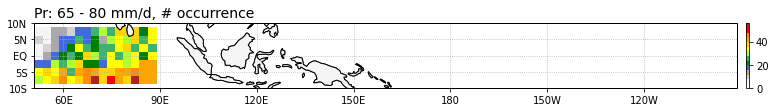

In [53]:
fig,ax = plt.subplots(1,1,figsize=(15,4)
        ,subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=2,edgecolor='k',facecolor='whitesmoke') # maskout LAND
ax.set_facecolor('snow')

cf = ax.pcolor(lon_bin,lat_bin,test.T,transform=ccrs.PlateCarree()
                    ,cmap=cmap_cus)

# cwv_con,lon = add_cyclic_point(cwv_clim, coord=cwv.lon)
# ax.contour(lon,cwv.lat,cwv_con,transform=ccrs.PlateCarree(),
#             levels=[46,48,50,52,54,56],colors=['whitesmoke'],linewidths=1.5)
ax.set_title('Pr: 65 - 80 mm/d, # occurrence',fontsize=14,loc='left')

ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax.set_xticks([-180,-150,-120,-90,-60,-30,-0,30,60,90,120,150,180])
ax.set_xticklabels(['0','30E','60E','90E','120E','150E','180','150W','120W','90W','60W','30W','0'])
ax.set_ylim([-10,10]);ax.grid(linestyle=':')
ax.set_xlim([-129,89])
cbar = plt.colorbar(cf,ax=ax,shrink=0.3,pad=0.01)

In [54]:
def vars_decile_evo1D(var_all,size=(5,10,33),opt=1):
    
    var_dec = np.zeros(size)
    var_stddec = np.zeros(size)
    
    for i in range(len(prec_bins2)-1):
        idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]
        SCAI_tmp = SCAIbt_all[idx,16]
        # vars
        var_tmp = var_all[idx,:]
        
        for n in range(10):
            if n < 9:
                idx_dec = np.where(np.logical_and(SCAI_tmp>= SCAI_deciles_p[i,n],SCAI_tmp < SCAI_deciles_p[i,n+1]))[0]
            else:
                idx_dec = np.where(SCAI_tmp>= SCAI_deciles_p[i,n])[0]
            
            if opt ==1: # mean
                var_dec[i,n] = np.nanmean(var_tmp[idx_dec,:],axis=0)
                var_stddec[i,n] = np.nanstd(var_tmp[idx_dec,:],axis=0)/np.sqrt(len(idx_dec))
            if opt ==2: # sum
                var_dec[i,n] = np.nansum(var_tmp[idx_dec,:],axis=0)
    
    return (var_dec,var_stddec)

In [55]:
def vars_decile_evo2D(var_all,size=(5,10,33,42)):
    
    var_dec = np.zeros(size)
    
    for i in range(len(prec_bins2)-1):
        idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]
        SCAI_tmp = SCAIbt_all[idx,16]
        # vars
        var_tmp = var_all[idx,:,:]
        for n in range(10):
            if n < 9:
                idx_dec = np.where(np.logical_and(SCAI_tmp>= SCAI_deciles_p[i,n],SCAI_tmp < SCAI_deciles_p[i,n+1]))[0]
            else:
                idx_dec = np.where(SCAI_tmp>= SCAI_deciles_p[i,n])[0]

            var_dec[i,n,:] = np.nanmean(var_tmp[idx_dec,:,:],axis=0)
    
    return var_dec

### Mutivariable dependency on aggregation

In [56]:
# decile index list
cwv_dec = np.zeros((len(prec_bins2)-1,10))
# cwvenv_dec = np.copy(cwv_dec)
# cwvcld_dec = np.copy(cwv_dec)
cwvstd_dec = np.copy(cwv_dec)

cldfrac_dec = np.copy(cwv_dec)
#cldfrac_dc_dec = np.copy(cwv_dec)
prec_dec = np.copy(cwv_dec)
precM2_dec = np.copy(cwv_dec)
precstd_dec =  np.copy(cwv_dec)
Abar_dec = np.copy(cwv_dec)
D0_dec =np.copy(cwv_dec)
rh_dec = np.zeros((len(prec_bins2)-1,10,42))

omega_dec = np.copy(rh_dec)
#omegaenv_dec = np.copy(rh_dec)
#omegacld_dec = np.copy(rh_dec)
div_dec = np.copy(rh_dec)
bt_dist_dec = np.zeros((len(prec_bins)-1,10,30)); bt_bins = np.linspace(180,300,31)
cwv_2ddt_dec = np.copy(cwv_dec)
cwv_5ddt_dec = np.copy(cwv_dec)
cwv_10ddt_dec = np.copy(cwv_dec)

for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]
    SCAI_tmp = SCAIbt_all[idx,16]
    # vars
    cldfrac_tmp = cldfrac_all[idx,16]
    #cldfrac_dc_tmp = cldfrac_dc_all[idx,16]
    Abar_tmp = Abar_all[idx,16]
    D0_tmp = D0_all[idx,16]
    prec_tmp = prec_all[idx,16]
#    precstd_tmp = precstd_all[idx,16]
    precM2_tmp = precM2_all[idx,16]
    cwv_tmp = cwv_all[idx,16]
    #cwvenv_tmp = cwvenv_all[idx,16]
    #cwvcld_tmp = cwvcld_all[idx,16]
#    cwvstd_tmp = cwvstd_all[idx,16]
    rh_tmp = rh_all[idx,16,:]
    omega_tmp = omega_all[idx,16,:] 
    #omegaenv_tmp = omegaenv_all[idx,16,:]
    #omegacld_tmp = omegacld_all[idx,16,:]
    div_tmp = div_all[idx,16,:]
    bt_dist_tmp = bt_dist_all[idx,16,:]
    cwv_2ddt_tmp = cwv_dt_all[idx,0,16]
    cwv_5ddt_tmp = cwv_dt_all[idx,1,16]
    cwv_10ddt_tmp = cwv_dt_all[idx,2,16]

    for n in range(10):
        if n < 9:
            idx_dec = np.where(np.logical_and(SCAI_tmp>= SCAI_deciles_p[i,n],SCAI_tmp < SCAI_deciles_p[i,n+1]))[0]
        else:
            idx_dec = np.where(SCAI_tmp>= SCAI_deciles_p[i,n])[0]

        cwv_dec[i,n] = np.nanmean(cwv_tmp[idx_dec])
        #cwvenv_dec[i,n] = np.nanmean(cwvenv_tmp[idx_dec])
        #cwvcld_dec[i,n] = np.nanmean(cwvcld_tmp[idx_dec])
#        cwvstd_dec[i,n] = np.nanmean(cwvstd_tmp[idx_dec])
        cldfrac_dec[i,n] = np.nanmean(cldfrac_tmp[idx_dec])
        #cldfrac_dc_dec[i,n] = np.nanmean(cldfrac_dc_tmp[idx_dec])
        Abar_dec[i,n] = np.nanmean(Abar_tmp[idx_dec])
        D0_dec[i,n] = np.nanmean(D0_tmp[idx_dec])
        prec_dec[i,n] = np.nanmean(prec_tmp[idx_dec])
#        precstd_dec[i,n] = np.nanstd(prec_tmp[idx_dec])/np.sqrt(len(idx_dec))
        precM2_dec[i,n] = np.nanmean(precM2_tmp[idx_dec])
        rh_dec[i,n,:] = np.nanmean(rh_tmp[idx_dec,:],axis=0)
        omega_dec[i,n,:] = np.nanmean(omega_tmp[idx_dec,:],axis=0)
#        omegaenv_dec[i,n,:] = np.nanmean(omegaenv_tmp[idx_dec,:],axis=0)
#        omegacld_dec[i,n,:] = np.nanmean(omegacld_tmp[idx_dec,:],axis=0)
        div_dec[i,n,:] = np.nanmean(div_tmp[idx_dec,:],axis=0)
        bt_dist_dec[i,n,:] = np.sum(bt_dist_tmp[idx_dec,:],axis=0)

        cwv_2ddt_dec[i,n] = np.nanmean(cwv_2ddt_tmp[idx_dec],axis=0)
        cwv_5ddt_dec[i,n] = np.nanmean(cwv_5ddt_tmp[idx_dec],axis=0)
        cwv_10ddt_dec[i,n] = np.nanmean(cwv_10ddt_tmp[idx_dec],axis=0)

In [57]:
# number of samples in eahc P group
P_samp = np.zeros(len(prec_bins2)-1)
for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]
    P_samp[i] = len(idx)

In [58]:
N_dec, N_stddec = vars_decile_evo1D(N_all,size=(len(prec_bins2)-1,10,33))

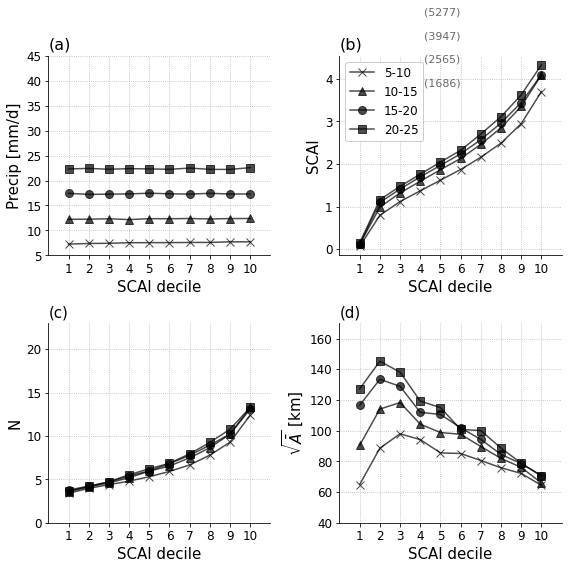

In [59]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
symb = ['x','^','o','s']

for n in range(len(prec_bins2)-1):
    ax[0,0].plot(range(1,11),86400*precM2_dec[n,:],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
    ax[0,1].plot(range(1,11),SCAI_deciles_p[n,:],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
    ax[1,0].plot(range(1,11),N_dec[n,:,16],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
#    ax0.plot(range(1,11),D0_dec[n,:],'-o',markersize=8,markerfacecolor='w'
#               ,label=labels[n])
    ax[1,1].plot(range(1,11),Abar_dec[n,:],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
    
#ax[1].set_title('E [SCAI | P$_{r}$=fixed](SCAI)',fontsize=14)
ax[0,1].set_ylabel('SCAI',fontsize=15)
ax[0,1].set_xlabel('SCAI decile',fontsize=15)
ax[0,1].set_xlim([0,11])
ax[0,1].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax[0,1].legend(loc=2, ncol=1, framealpha=1,fontsize=12)
ax[0,1].set_title('(b)',fontsize=16,loc='left')

ax[0,0].set_title('(a)',fontsize=16,loc='left')
ax[0,0].set_ylabel('Precip [mm/d]',fontsize=15)
ax[0,0].set_xlabel('SCAI decile',fontsize=15)
ax[0,0].set_xlim([0,11])
ax[0,0].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax[0,0].set_ylim([5,45])


ax[0,0].tick_params(labelsize=12)
ax[0,1].tick_params(labelsize=12)
ax[0,0].grid(linestyle=':');ax[0,1].grid(linestyle=':')

# add number of P samples
#color_p = ['royalblue','orange','g','r']
for n in range(len(prec_bins2)-1):
    ax[0,1].text(4.2,5.5-0.56*n,'('+str(int(P_samp[n]))+')',fontsize=11,color='dimgrey')

#ax[0].set_title('E [N | P=fixed](SCAI)',fontsize=14)
ax[1,0].set_ylabel('N',fontsize=15)
ax[1,0].set_xlabel('SCAI decile',fontsize=15)
ax[1,0].set_ylim([0,23])
ax[1,0].set_xlim([0,11])
ax[1,0].set_xticks([1,2,3,4,5,6,7,8,9,10])
ax[1,0].set_title('(c)',fontsize=15,loc='left')

ax[1,1].set_title('(d)',fontsize=15,loc='left')
ax[1,1].set_ylabel(r'$\sqrt{\bar{A}}$ [km]',fontsize=15)
ax[1,1].set_xlabel('SCAI decile',fontsize=15)
ax[1,1].set_xlim([0,11])
ax[1,1].set_ylim([40,170])
ax[1,1].set_xticks([1,2,3,4,5,6,7,8,9,10])
#ax[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, framealpha=0.0)

ax[1,0].tick_params(labelsize=12)
ax[1,1].tick_params(labelsize=12)
ax[1,0].grid(linestyle=':');ax[1,1].grid(linestyle=':')

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

plt.tight_layout(w_pad=1)

#fig.savefig(fig_dir+'SCAI_NAbar_decilerank.pdf',bbox_inches='tight')

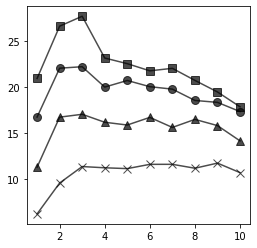

In [60]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
symb = ['x','^','o','s']

for n in range(len(prec_bins2)-1):
    ax.plot(range(1,11),24*prec_dec[n,:],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)

In [61]:
cwv_long_dec,cwv_long_stddec = vars_decile_evo1D(cwv_long_all,size=(len(prec_bins2)-1,10,33))

In [62]:
cwv_long_dec,cwv_long_stddec = vars_decile_evo1D(cwv_long_all,size=(len(prec_bins2)-1,10,33))
cwv_latg_dec,cwv_latg_stddec = vars_decile_evo1D(cwv_latg_all,size=(len(prec_bins2)-1,10,33))

In [63]:
lwtoa_dec, lwtoa_stddec = vars_decile_evo1D(lwtoa_ce_all,size=(len(prec_bins2)-1,10,33))

SHF_dec, lwtoa_stddec = vars_decile_evo1D(SHF_all,size=(len(prec_bins2)-1,10,33))
LHF_dec, swtoa_stddec = vars_decile_evo1D(LHF_all,size=(len(prec_bins2)-1,10,33))
LHF_WHOI_dec, swtoa_stddec = vars_decile_evo1D(LHF_WHOI_all,size=(len(prec_bins2)-1,10,5))

In [64]:
import matplotlib
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

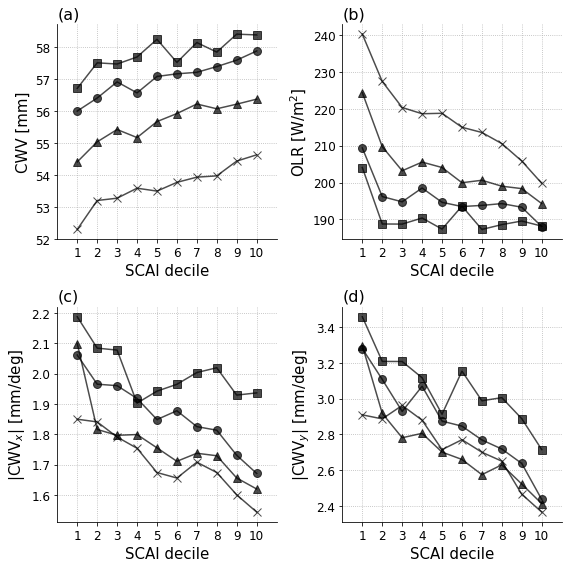

In [65]:
fig, ax = plt.subplots(2,2,figsize=(8,8))

for n in range(len(prec_bins2)-1):
    ax[0,0].plot(range(1,11),cwv_dec[n,:],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
    ax[0,1].plot(range(1,11),lwtoa_dec[n,:,16],'-k',marker=symb[n],markersize=8
               ,label=p_labels[n],alpha=0.7)
    ax[1,0].plot(range(1,11),cwv_long_dec[n,:,16],'-k',marker=symb[n],markersize=8,
               label=p_labels[n],alpha=0.7)
    ax[1,1].plot(range(1,11),cwv_latg_dec[n,:,16],'-k',marker=symb[n],markersize=8,
               label=p_labels[n],alpha=0.7)

ax[0,0].set_title('(a)',fontsize=16,loc='left')
ax[0,0].set_ylabel('CWV [mm]',fontsize=15)
ax[0,0].set_xlabel('SCAI decile',fontsize=15)
ax[0,0].set_xlim([0,11])#;ax[0,0].set_ylim([45,60])
ax[0,0].set_xticks([1,2,3,4,5,6,7,8,9,10])

ax[0,1].set_title('(b)',fontsize=16,loc='left')
ax[0,1].set_ylabel('OLR [W/m$^2$]',fontsize=15)
ax[0,1].set_xlabel('SCAI decile',fontsize=15)
ax[0,1].set_xlim([0,11])#;ax[0,1].set_ylim([170,270])
ax[0,1].set_xticks([1,2,3,4,5,6,7,8,9,10])

ax[0,0].tick_params(labelsize=12)
ax[0,1].tick_params(labelsize=12)
ax[0,0].grid(linestyle=':');ax[0,1].grid(linestyle=':')

ax[1,0].set_title('(c)',fontsize=16,loc='left')
ax[1,0].set_ylabel('|CWV$_x$| [mm/deg]',fontsize=15)
ax[1,0].set_xlabel('SCAI decile',fontsize=15)
ax[1,0].set_xlim([0,11]);#ax[1,0].set_ylim([1.5,2])
ax[1,0].set_xticks([1,2,3,4,5,6,7,8,9,10])

ax[1,1].set_title('(d)',fontsize=16,loc='left')
ax[1,1].set_ylabel('|CWV$_y$| [mm/deg]',fontsize=15)
ax[1,1].set_xlabel('SCAI decile',fontsize=15)
ax[1,1].set_xlim([0,11]);#ax[1,1].set_ylim([2.2,3.5])
ax[1,1].set_xticks([1,2,3,4,5,6,7,8,9,10])

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,0].tick_params(labelsize=12)
ax[1,1].tick_params(labelsize=12)
ax[1,0].grid(linestyle=':');ax[1,1].grid(linestyle=':')
plt.tight_layout(w_pad=1.2)

#fig.savefig(fig_dir+'CWV_OLR_decilerank.pdf',bbox_inches='tight')

In [66]:
from scipy.stats import ttest_ind
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

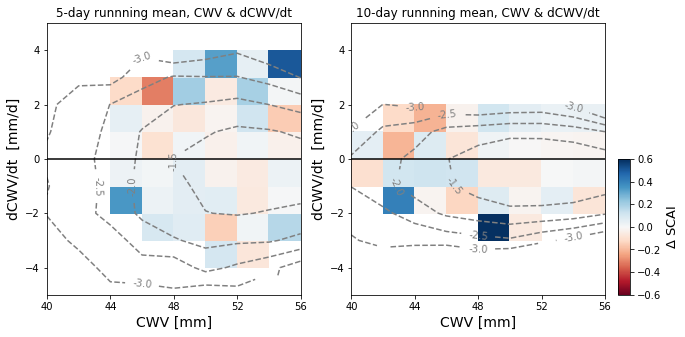

In [67]:
cwvdt_bin = np.linspace(-5,6,12)
cwvdt_bin2 = np.linspace(-5,6,12)

cwv_bin = np.linspace(40,58,10)
SCAI_bin = np.zeros((len(cwv_bin)-1,len(cwvdt_bin)-1))
SCAImn_bin = np.copy(SCAI_bin)
SCAI_bin2 = np.zeros((len(cwv_bin)-1,len(cwvdt_bin)-1))
SCAImn_bin2 = np.zeros((len(cwv_bin)-1,len(cwvdt_bin)-1))

num_bin = np.copy(SCAI_bin)
num_bin2 = np.copy(SCAI_bin2)

pval_bin = np.copy(SCAI_bin)

SCAIbt_test = SCAIbt_all[:,16].ravel()
cwv_test = cwv_rm_all[:,1,16].ravel()
cwv_test2 = cwv_rm_all[:,2,16].ravel()
cwvdt_test = cwv_dt_all[:,1,16].ravel() # 5d-running mean
cwvdt_test2 = cwv_dt_all[:,2,16].ravel() # 10d-running mean

for i in range(len(cwv_bin)-1):
    idx = np.where(np.logical_and(cwv_test>=cwv_bin[i],cwv_test<cwv_bin[i+1]))
    SCAImn_bin[i,:] = np.nanmean(SCAIbt_test[idx])
    
    for j in range(len(cwvdt_bin)-1):
        idy = np.where(np.logical_and(cwvdt_test>=cwvdt_bin[j],cwvdt_test<cwvdt_bin[j+1]))
        
        idx_com = np.intersect1d(idx,idy)
        
        # adding same sign for 5d, 10d running-mean
        idn = np.where(np.logical_and(cwvdt_test[idx_com]<=0,cwvdt_test2[idx_com]<=0))[0]
        idp = np.where(np.logical_and(cwvdt_test[idx_com]>0,cwvdt_test2[idx_com]>0))[0]
        idx_np = np.concatenate([idn,idp])
        
        SCAI_bin[i,j] = np.nanmean(SCAIbt_test[idx_com[idx_np]])
        num_bin[i,j] = len(idx_com[idx_np])
        
        # t-test
        stats, pval = ttest_ind(SCAIbt_test[idx],SCAIbt_test[idx_com[idx_np]])
        pval_bin[i,j] = pval

for i in range(len(cwv_bin)-1):
    idx = np.where(np.logical_and(cwv_test2>=cwv_bin[i],cwv_test2<cwv_bin[i+1]))
    SCAImn_bin2[i,:] = np.nanmean(SCAIbt_test[idx])
    
    for j in range(len(cwvdt_bin2)-1):
        idy = np.where(np.logical_and(cwvdt_test2>=cwvdt_bin2[j],cwvdt_test2<cwvdt_bin2[j+1]))
        
        idx_com = np.intersect1d(idx,idy)
        
        # adding same sign for 5d, 10d running-mean
        idn = np.where(np.logical_and(cwvdt_test[idx_com]<=0,cwvdt_test2[idx_com]<=0))[0]
        idp = np.where(np.logical_and(cwvdt_test[idx_com]>0,cwvdt_test2[idx_com]>0))[0]
        idx_np = np.concatenate([idn,idp])
        
        SCAI_bin2[i,j] = np.nanmean(SCAIbt_test[idx_com[idx_np]])
        num_bin2[i,j] = len(idx_com[idx_np])
        
        # t-test
        stats, pval = ttest_ind(SCAIbt_test[idx],SCAIbt_test[idx_com[idx_np]])
        pval_bin[i,j] = pval
        
# remove samples less than 100
SCAI_bin[num_bin<20] = np.nan
SCAI_bin2[num_bin2<20] = np.nan

fig,ax = plt.subplots(1,2,figsize=(10,5))

cp=ax[0].pcolormesh(cwv_bin[:-1],cwvdt_bin[:-1],(SCAI_bin-SCAImn_bin).T,cmap='RdBu',vmin=-0.6,vmax=0.6)
cf=ax[0].contour(cwv_bin[:-1],cwvdt_bin[:-1],np.log10(num_bin/np.sum(num_bin)).T,
            levels=[-3,-2.5,-2,-1.5],colors=['grey'],linwidth=0.8,linestyle='-')
cf.clabel(fmt='%2.1f')
ax[0].set_ylabel('dCWV/dt  [mm/d]',fontsize=14)
ax[0].set_xlabel('CWV [mm]',fontsize=14)
ax[0].set_title('5-day runnning mean, CWV & dCWV/dt')
ax[0].hlines(y=0,xmin=40,xmax=56,color='k')
ax[0].set_xticks([40,44,48,52,56]);
ax[0].set_ylim([-5,5])

cp=ax[1].pcolormesh(cwv_bin[:-1],cwvdt_bin[:-1],(SCAI_bin2-SCAImn_bin2).T,cmap='RdBu',vmin=-0.6,vmax=0.6)
cf=ax[1].contour(cwv_bin[:-1],cwvdt_bin[:-1],np.log10(num_bin2/np.sum(num_bin2)).T,
            levels=[-3,-2.5,-2,-1.5],colors=['grey'],linwidth=0.8,linestyle='-')
cf.clabel(fmt='%2.1f')
ax[1].set_ylabel('dCWV/dt  [mm/d]',fontsize=14)
ax[1].set_xlabel('CWV [mm]',fontsize=14)
ax[1].set_title('10-day runnning mean, CWV & dCWV/dt')
ax[1].hlines(y=0,xmin=40,xmax=56,color='k')
ax[1].set_xticks([40,44,48,52,56]);
ax[1].set_ylim([-5,5])
 
cbaxes = inset_axes(ax[1], width="5%",height="50%",loc='lower left',
           bbox_to_anchor=(1.05, 0., 1, 1),bbox_transform=ax[1].transAxes,
           borderpad=0) 
cbar=fig.colorbar(cp,cax=cbaxes,orientation='vertical')
cbar.set_label(r'$\Delta$ SCAI',fontsize=13)

In [68]:
slp,interp,r_val,pval,std=linregress(cwv_rm_all[:,1,16],SCAIbt_all[:,16])

In [69]:
# SCAI_bin = np.linspace(0,6,12)
# cwv_bin = np.linspace(40,58,10)
# cwvdt_bin = np.zeros((len(cwv_bin)-1,len(SCAI_bin)-1))
# A_bin = np.copy(cwvdt_bin)
# prec_bin = np.copy(cwvdt_bin)
# num_bin = np.copy(cwvdt_bin)

# SCAIbt_test = SCAIbt_all[:,16].ravel()
# A_test = Abar_all[:,16].ravel()
# cwv_test = cwv_rm_all[:,1,16].ravel()
# cwvdt_test = cwv_dt_all[:,1,16].ravel()
# prec_test = prec_all[:,16].ravel()

# cwvdt_test2 = cwv_dt_all[:,2,16].ravel()

# for i in range(len(cwv_bin)-1):
#     idx = np.where(np.logical_and(cwv_test>=cwv_bin[i],cwv_test<cwv_bin[i+1]))
#     for j in range(len(cwvdt_bin)-1):
#         idy = np.where(np.logical_and(SCAI_test>=SCAI_bin[j],SCAI_test<SCAI_bin[j+1]))
        
#         idx_com = np.intersect1d(idx,idy)
        
#         # adding same sign for 5d, 10d running-mean
#         idn = np.where(np.logical_and(cwvdt_test[idx_com]<=0,cwvdt_test2[idx_com]<=0))[0]
#         idp = np.where(np.logical_and(cwvdt_test[idx_com]>0,cwvdt_test2[idx_com]>0))[0]
#         idx_np = np.concatenate([idn,idp])
        
#         cwvdt_bin[i,j] = np.nanmean(cwvdt_test[idx_com[idx_np]])
#         num_bin[i,j] = len(idx_com[idx_np])

# # remove samples less than 100
# cwvdt_bin[num_bin<20] = np.nan
        
# #plt.pcolormesh(cwv_bin[:-1],SCAI_bin[:-1],cwvdt_bin.T,cmap='',vmin=-4,vmax=)
# cbar=plt.colorbar(shrink=0.8)
# cbar.set_label('SCAI',fontsize=12)
# cf=plt.contour(cwv_bin[:-1],SCAI_bin[:-1],np.log10(num_bin/np.sum(num_bin)).T,
#             levels=[-3,-2.5,-2,-1.5],colors=['grey'],linwidth=0.8,linestyle='-')
# cf.clabel(fmt='%2.1f')
# plt.ylabel('dCWV/dt  [mm/d]',fontsize=12)
# plt.xlabel('SCAI',fontsize=12)
# plt.title('5-day runnning mean, CWV & dCWV/dt')
# plt.hlines(y=0,xmin=40,xmax=56,color='k')
# plt.xticks([40,44,48,52,56]);
# plt.ylim([0,6])

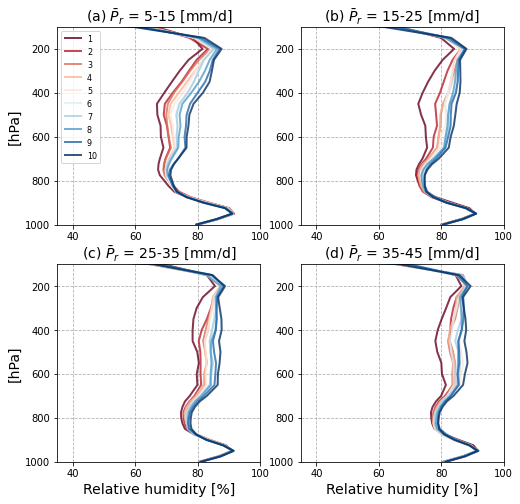

In [70]:
# Relative humidity [%]
fig,ax = plt.subplots(2,2,figsize=(8,8))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
labels=['5-15','15-25','25-35','35-45']

k=0
for i in [0,1]:
    for j in [0,1]:
        for n in range(10):
            ax[i,j].plot(100*rh_dec[k,n,:],lev,label=str(n+1),color=colors[n]
                         ,linewidth=2,alpha=0.8)
            ax[i,j].set_ylim([1000,100]);ax[i,j].set_xlim([35,100]);
            #ax[i,j].set_title('E [RH | P='+labels[k]+'] (SCAI)',fontsize=13);
            
        ax[i,j].plot(rh_dec[k,n,:],lev,label=str(n+1),color='darkred'
                         ,linewidth=2)
        ax[i,j].set_yticks([1000,800,600,400,200])
        k+=1
        ax[i,j].grid(linestyle='--')

ax[0,0].set_ylabel('[hPa]',fontsize=14)
ax[1,0].set_ylabel('[hPa]',fontsize=14);ax[1,0].set_xlabel('Relative humidity [%]',fontsize=14)
ax[1,1].set_xlabel('Relative humidity [%]',fontsize=14)

ax[0,0].set_title(r'(a) $\bar P_r$ = 5-15 [mm/d]',fontsize=14)
ax[0,1].set_title(r'(b) $\bar P_r$ = 15-25 [mm/d]',fontsize=14)
ax[1,0].set_title(r'(c) $\bar P_r$ = 25-35 [mm/d]',fontsize=14)
ax[1,1].set_title(r'(d) $\bar P_r$ = 35-45 [mm/d]',fontsize=14)
ax[0,0].legend(np.arange(1,11),fontsize=8)

#plt.tight_layout(w_pad=1)
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

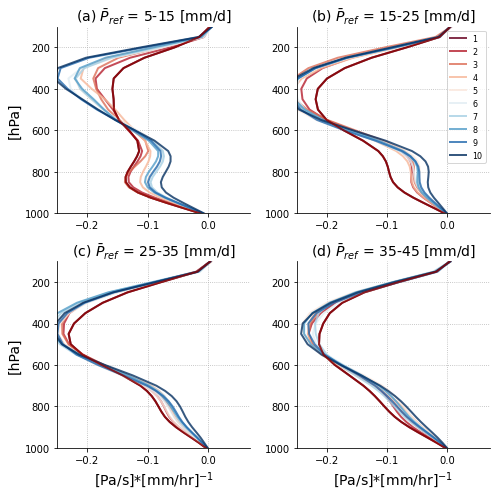

In [71]:
fig,ax = plt.subplots(2,2,figsize=(7,7))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']
labels=['5-15','15-25','25-35','35-45']

k=0
for i in [0,1]:
    for j in [0,1]:
        for n in range(10):
            ax[i,j].plot(omega_dec[k,n,:]/(3600*precM2_dec[k,n]),lev,label=str(n+1),color=colors[n]
                         ,linewidth=2,alpha=0.8)
            ax[i,j].set_ylim([1000,100]);#;ax[i,j].set_xlim([-0.15,0.05]);
            ax[i,j].set_xlim([-0.25,0.07]);
            
            ax[i,j].set_title('E [OMEGA | P='+labels[k]+'] (SCAI)',fontsize=13);
            
        ax[i,j].plot(omega_dec[k,0,:]/(3600*precM2_dec[k,0]),lev,label=str(n+1),color='darkred'
                         ,linewidth=2,alpha=0.8)
        ax[i,j].set_yticks([1000,800,600,400,200])
        k+=1
        ax[i,j].grid(linestyle=':')
        
ax[0,0].set_ylabel('[hPa]',fontsize=14)
ax[1,0].set_ylabel('[hPa]',fontsize=14);ax[1,0].set_xlabel('[Pa/s]*[mm/hr]$^{-1}$',fontsize=14)
ax[1,1].set_xlabel('[Pa/s]*[mm/hr]$^{-1}$',fontsize=14)

ax[0,0].set_title(r'(a) $\bar P_{ref}$ = 5-15 [mm/d]',fontsize=14)
ax[0,1].set_title(r'(b) $\bar P_{ref}$ = 15-25 [mm/d]',fontsize=14)
ax[1,0].set_title(r'(c) $\bar P_{ref}$ = 25-35 [mm/d]',fontsize=14)
ax[1,1].set_title(r'(d) $\bar P_{ref}$ = 35-45 [mm/d]',fontsize=14,)
ax[0,1].legend(np.arange(1,11),fontsize=8)

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

plt.tight_layout(w_pad=1.5)
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

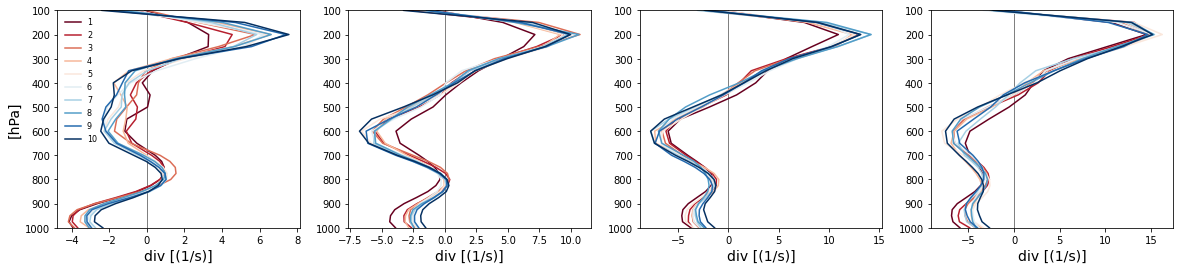

In [72]:
fig,ax = plt.subplots(1,len(prec_bins2)-1,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(len(prec_bins2)-1):
    for n in range(10):
        ax[i].plot(10e5*div_dec[i,n,:],lev,label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100])#;ax[i].set_xlim([-0.1,0.05]);
        #ax[i].set_title('E [div | P='+labels[i]+'] (SCAI)',fontsize=13)
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
        ax[i].set_xlabel('div [(1/s)]',fontsize=14)
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

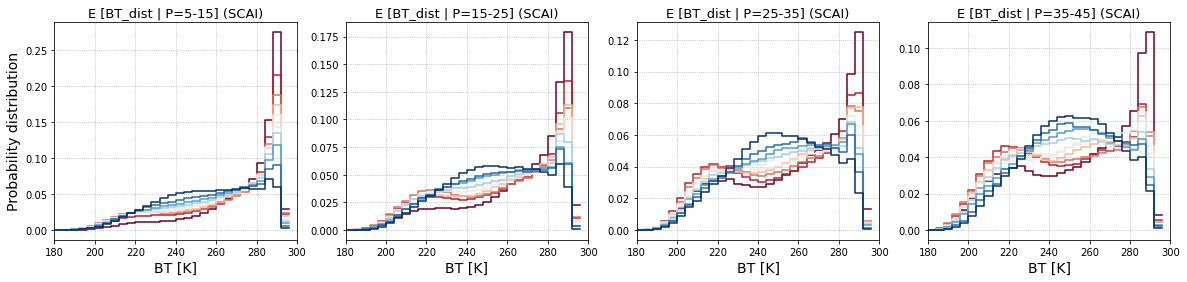

In [73]:
# brightness temperature distribution
fig,ax = plt.subplots(1,len(prec_bins2)-1,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(len(prec_bins2)-1):
    for n in range(10):
        ax[i].step(bt_bins[:-1],bt_dist_dec[i,n,:]/np.sum(bt_dist_dec[i,n,:],axis=0),color=colors[n])
        #ax[i].set_ylim([0,0.3])
        ax[i].set_xlim([180,300])
        ax[i].set_title('E [BT_dist | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].grid(linewidth=0.8,linestyle=':')
        ax[i].set_xlabel('BT [K]',fontsize=14)
ax[0].set_ylabel('Probability distribution',fontsize=14);

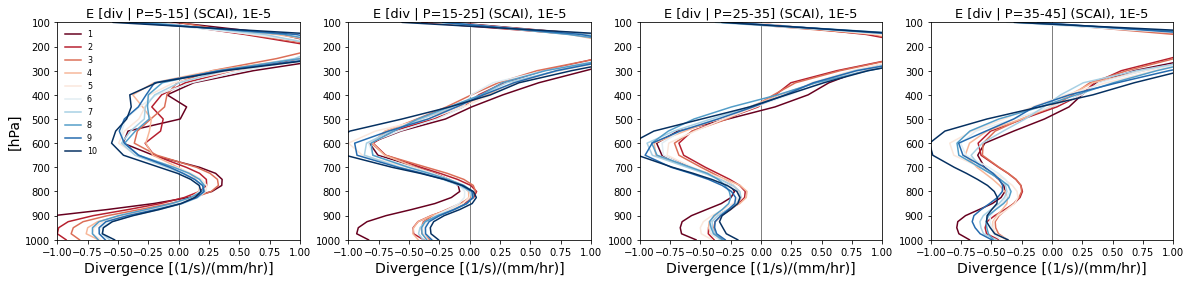

In [74]:
fig,ax = plt.subplots(1,len(prec_bins2)-1,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(len(prec_bins2)-1):
    for n in range(10):
        ax[i].plot(1e5*div_dec[i,n,:]/prec_dec[i,n],lev,label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100]);ax[i].set_xlim([-1,1]);
        ax[i].set_title('E [div | P='+labels[i]+'] (SCAI), 1E-5',fontsize=13)
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
        ax[i].set_xlabel('Divergence [(1/s)/(mm/hr)]',fontsize=14)
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [75]:
# qvflux_dec = vars_decile_evo2D(qvflux_all,size=(5,10,33,42))

# qvflux_sfc850 = np.trapz(qvflux_all[:,:,:7],lev[:7]*100,axis=2)/9.8 # vertical integral of qvflux_h
# qvflux_sfc850_dec = vars_decile_evo1D(qvflux_sfc850,size=(5,10,33))

In [76]:
precM2_dec = vars_decile_evo1D(precM2_all,size=(len(prec_bins2)-1,10,33))

In [77]:
# # vorticity, checking if stroms are involved 
# fig,ax = plt.subplots(1,5,figsize=(20,4))

# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for i in range(5):
#     for n in range(10):
#         ax[i].plot(1e5*qvflux_dec[i,n,16,:]/prec_dec[i,n],lev,label=str(n+1),color=colors[n])
#         ax[i].set_ylim([1000,100]);#ax[i].set_xlim([-0.01,0.02]);
#         ax[i].set_title('E [qvflux | P='+labels[i]+'] (SCAI)',fontsize=13)
#         if i ==0:
#             ax[i].legend(framealpha=0,fontsize=8)
#             ax[i].set_ylabel('[hPa]',fontsize=14)
#         ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
#         ax[i].set_xlabel('qvflux_h [(1/s)/(mm/hr)]',fontsize=14)
# #fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

#### precipitation distribution

In [78]:
# precdist_bins = np.linspace(0,150,31)
# precdist_dec, precdist_stddec= vars_decile_evo1D(precdist_all,size=(len(prec_bins2)-1,10,33,30),opt=2)

In [79]:
# # precipitation distribution
# fig,ax = plt.subplots(1,len(prec_bins2)-1,figsize=(20,4))

# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for i in range(len(prec_bins2)-1):
#     for n in range(10):
#         ax[i].plot(precdist_bins[:-1],precdist_dec[i,n,16,:]/np.sum(precdist_dec[i,n,16,:],axis=0),color=colors[n])
#         #ax[i].set_ylim([0,0.3])
#         ax[i].set_xlim([-1,60])
#         ax[i].set_title('E [prec_dist | P='+labels[i]+'] (SCAI)',fontsize=13)
#         ax[i].grid(linewidth=0.8,linestyle=':')
#         ax[i].set_xlabel('Prec [mm/hr]',fontsize=14)
#         ax[i].set_yscale('log')
# ax[0].set_ylabel('Probability',fontsize=14);

#### omega(p), divergence(p) and IR histogram
testing the relationship between divergence at 500, 400, 300, 200hPa and BT area of 240K
Time-series, regression

In [80]:
# ctp_mn_all = np.load('ctp_all_5deg_4ds_M2.mat.npy')
# ctp_mn_all = ctp_mn_all[idx_region,:]
# ctp_mn_all = ctp_mn_all[idx_rm,:]

ctp_dist_all = np.load('ctp_dist_all_5deg_4ds_M2.mat.npy')
ctp_dist_all = ctp_dist_all[idx_region,:,:]
ctp_dist_all = ctp_dist_all[idx_rm,:,:]

In [81]:
ctp_dist_dec, ctp_dist_stddec = vars_decile_evo1D(ctp_dist_all,size=(len(prec_bins2)-1,10,33,20),opt=2)
omega_dec = vars_decile_evo2D(omega_all,size=(len(prec_bins2)-1,10,33,42))
div_dec = vars_decile_evo2D(div_all,size=(len(prec_bins2)-1,10,33,42))
bt_dist_dec, bt_dist_stddec = vars_decile_evo1D(bt_dist_all,size=(len(prec_bins2)-1,10,33,30),opt=2) # sum opt=2

In [82]:
#prec_dec, prec_stddec = vars_decile_evo1D(prec_all,size=(len(prec_bins2)-1,10,33),opt=1)
precM2_dec, precM2_stddec = vars_decile_evo1D(precM2_all,size=(len(prec_bins2)-1,10,33),opt=1)

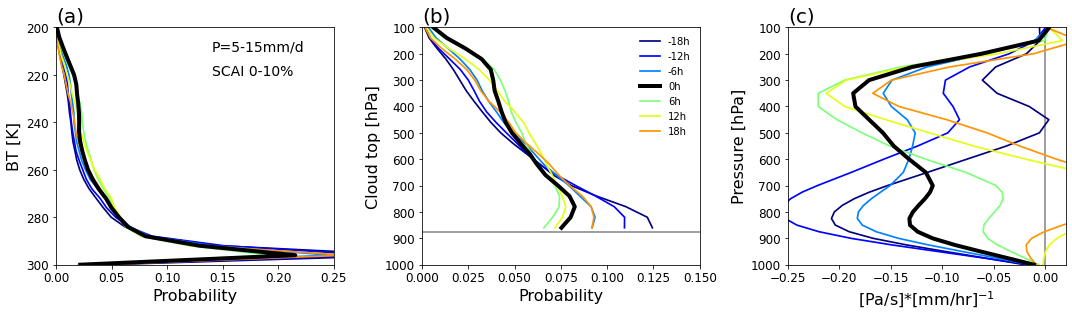

In [83]:
cmp=plt.cm.get_cmap('jet')
colors_time=cmp(np.linspace(0,1,9))
line_label = ['-18h','-12h','-6h','0h','6h','12h','18h']
ctp_bins = np.linspace(100,900,21)

fig, ax = plt.subplots(1,3,figsize=(15,4.5))

idd=0
tt = [10,12,14,16,18,20,22]
for i,t in enumerate(tt):
    if t == 16:
        ax[0].plot(bt_dist_dec[idd,1,t,:]/np.sum(bt_dist_dec[idd,1,t,:]),bt_bins[1:]
               ,color='k',linewidth=4,zorder=3)        
    else:
        ax[0].plot(bt_dist_dec[idd,1,t,:]/np.sum(bt_dist_dec[idd,1,t,:]),bt_bins[1:]
               ,color=colors_time[i],linewidth=1.7)
ax[0].set_xlabel('Probability',fontsize=16)
ax[0].set_ylabel('BT [K]',fontsize=16)
ax[0].set_ylim([300,200])    

tt = [10,12,14,16,18,20,22]
for i,t in enumerate(tt):
    if t == 16:
        ax[1].plot(gaussian_filter(ctp_dist_dec[idd,1,t,:]/np.sum(ctp_dist_dec[idd,1,t,:]),1),ctp_bins[:-1]
               ,color='k',linewidth=4,zorder=3,label=line_label[i])    
    else:
        ax[1].plot(gaussian_filter(ctp_dist_dec[idd,1,t,:]/np.sum(ctp_dist_dec[idd,1,t,:]),1),ctp_bins[:-1]
               ,color=colors_time[i],linewidth=1.7,label=line_label[i])

ax[1].set_xlabel('Probability',fontsize=16)
ax[1].set_ylabel('Cloud top [hPa]',fontsize=16)
ax[1].set_ylim([1000,100])    
ax[1].hlines(y=875,xmin=0,xmax=0.15,color='grey')

for i,t in enumerate(tt):
    if t == 16:
        ax[2].plot(omega_dec[idd,1,t,:]/(3600*precM2_dec[idd,1,t]),lev,color='k',linewidth=4,zorder=3)
    else:
        ax[2].plot(omega_dec[idd,1,t,:]/(3600*precM2_dec[idd,1,t]),lev,color=colors_time[i],label=line_label[i],linewidth=1.7)

ax[2].set_xlabel('[Pa/s]*[mm/hr]$^{-1}$',fontsize=16)
ax[2].set_ylabel('Pressure [hPa]',fontsize=16)
ax[2].set_ylim([1000,100])    
ax[2].vlines(x=0,ymin=100,ymax=1000,color='grey')

# text section
ax[0].set_title('(a)',fontsize=20,loc='left')
ax[0].text(0.14,210,'P=5-15mm/d',fontsize=14); ax[0].text(0.14,220,'SCAI 0-10%',fontsize=14)
ax[0].set_xlim([0,0.25]);ax[1].set_xlim([0,0.15]);ax[2].set_xlim([-0.25,0.02])
ax[1].set_title('(b)',fontsize=20,loc='left')
ax[2].set_title('(c)',fontsize=20,loc='left')
ax[1].legend(loc='upper right', ncol=1, framealpha=0.0)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[2].tick_params(labelsize=12)
plt.tight_layout(w_pad=1.5)
#fig.savefig(fig_dir+'ctp_omega_dist_SCAId1.pdf',bbox_tight='tight')

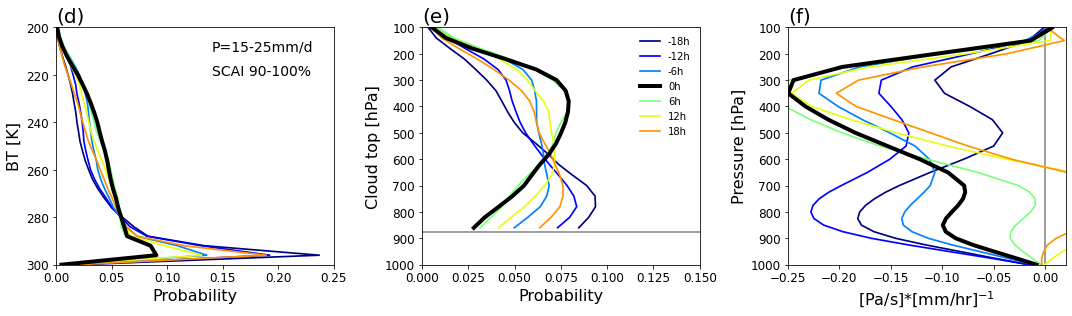

In [84]:
cmp=plt.cm.get_cmap('jet')
colors_time=cmp(np.linspace(0,1,9))
line_label = ['-18h','-12h','-6h','0h','6h','12h','18h']
ctp_bins = np.linspace(100,900,21)

fig, ax = plt.subplots(1,3,figsize=(15,4.5))

idd = 0 
tt = [10,12,14,16,18,20,22]
for i,t in enumerate(tt):
    if t == 16:
        ax[0].plot(bt_dist_dec[idd,8,t,:]/np.sum(bt_dist_dec[idd,8,t,:]),bt_bins[1:]
               ,color='k',linewidth=4,zorder=3)        
    else:
        ax[0].plot(bt_dist_dec[idd,8,t,:]/np.sum(bt_dist_dec[idd,8,t,:]),bt_bins[1:]
               ,color=colors_time[i],linewidth=1.7)
ax[0].set_xlabel('Probability',fontsize=16)
ax[0].set_ylabel('BT [K]',fontsize=16)
ax[0].set_ylim([300,200])    

tt = [10,12,14,16,18,20,22]
for i,t in enumerate(tt):
    if t == 16:
        ax[1].plot(gaussian_filter(ctp_dist_dec[idd,8,t,:]/np.sum(ctp_dist_dec[idd,9,t,:]),1),ctp_bins[:-1]
               ,color='k',linewidth=4,zorder=3,label=line_label[i])    
    else:
        ax[1].plot(gaussian_filter(ctp_dist_dec[idd,8,t,:]/np.sum(ctp_dist_dec[idd,9,t,:]),1),ctp_bins[:-1]
               ,color=colors_time[i],linewidth=1.7,label=line_label[i])

ax[1].set_xlabel('Probability',fontsize=16)
ax[1].set_ylabel('Cloud top [hPa]',fontsize=16)
ax[1].set_ylim([1000,100])    
ax[1].hlines(y=875,xmin=0,xmax=0.15,color='grey')

for i,t in enumerate(tt):
    if t == 16:
        ax[2].plot(omega_dec[idd,8,t,:]/(3600*precM2_dec[idd,8,t]),lev,color='k',linewidth=4,zorder=3)
    else:
        ax[2].plot(omega_dec[idd,8,t,:]/(3600*precM2_dec[idd,8,t]),lev,color=colors_time[i],label=line_label[i],linewidth=1.7)

ax[2].set_xlabel('[Pa/s]*[mm/hr]$^{-1}$',fontsize=16)
ax[2].set_ylabel('Pressure [hPa]',fontsize=16)
ax[2].set_ylim([1000,100])    
ax[2].vlines(x=0,ymin=100,ymax=1000,color='grey')

# text section
ax[0].set_title('(d)',fontsize=20,loc='left')
ax[0].text(0.14,210,'P=15-25mm/d',fontsize=14); ax[0].text(0.14,220,'SCAI 90-100%',fontsize=14)
ax[0].set_xlim([0,0.25]);ax[1].set_xlim([0,0.15]);ax[2].set_xlim([-0.25,0.02])
ax[1].set_title('(e)',fontsize=20,loc='left')
ax[2].set_title('(f)',fontsize=20,loc='left')
ax[1].legend(loc='upper right', ncol=1, framealpha=0.0)

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[2].tick_params(labelsize=12)
plt.tight_layout(w_pad=1.5)
#fig.savefig(fig_dir+'ctp_omega_dist_SCAId9.pdf',bbox_tight='tight')

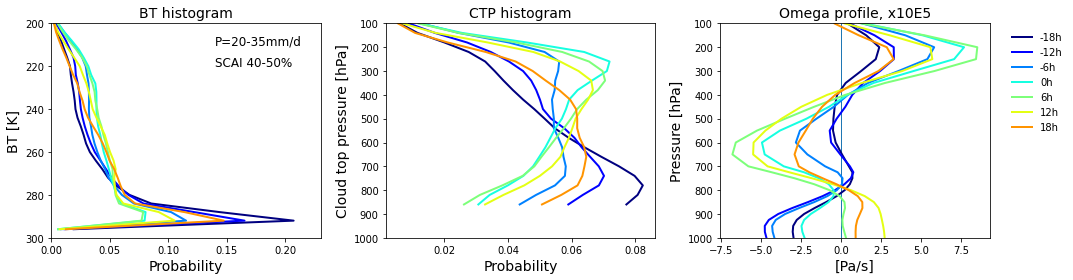

In [85]:
cmp=plt.cm.get_cmap('jet')
colors_time=cmp(np.linspace(0,1,9))
line_label = ['-18h','-12h','-6h','0h','6h','12h','18h']

fig, ax = plt.subplots(1,3,figsize=(15,4))

tt = [10,12,14,16,18,20,22]
for i,t in enumerate(tt):
    ax[0].plot(bt_dist_dec[1,5,t,:]/np.sum(bt_dist_dec[1,5,t,:]),bt_bins[:-1]
               ,color=colors_time[i],linewidth=2)
ax[0].set_xlabel('Probability',fontsize=14)
ax[0].set_ylabel('BT [K]',fontsize=14)
ax[0].set_ylim([300,200])    

for i,t in enumerate(tt):
    ax[1].plot(gaussian_filter(ctp_dist_dec[1,5,t,:]/np.sum(ctp_dist_dec[1,5,t,:]),1),ctp_bins[:-1]
               ,color=colors_time[i],linewidth=2)
ax[1].set_xlabel('Probability',fontsize=14)
ax[1].set_ylabel('Cloud top pressure [hPa]',fontsize=14)
ax[1].set_ylim([1000,100])    

for i,t in enumerate(tt):
    ax[2].plot(10e5*gaussian_filter(div_dec[1,5,t,:],1),lev,color=colors_time[i],label=line_label[i],linewidth=2)
ax[2].set_xlabel('[Pa/s]',fontsize=14)
ax[2].set_ylabel('Pressure [hPa]',fontsize=14)
ax[2].set_ylim([1000,100])    
ax[2].vlines(x=0,ymin=100,ymax=1000,linewidth=1)

ax[0].set_title('BT histogram',fontsize=14)
ax[0].text(0.14,210,'P=20-35mm/d',fontsize=12); ax[0].text(0.14,220,'SCAI 40-50%',fontsize=12)
ax[0].set_xlim([0,0.23])
ax[1].set_title('CTP histogram',fontsize=14)
ax[2].set_title('Omega profile, x10E5',fontsize=14)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, framealpha=0.0)
plt.tight_layout(w_pad=1.5)

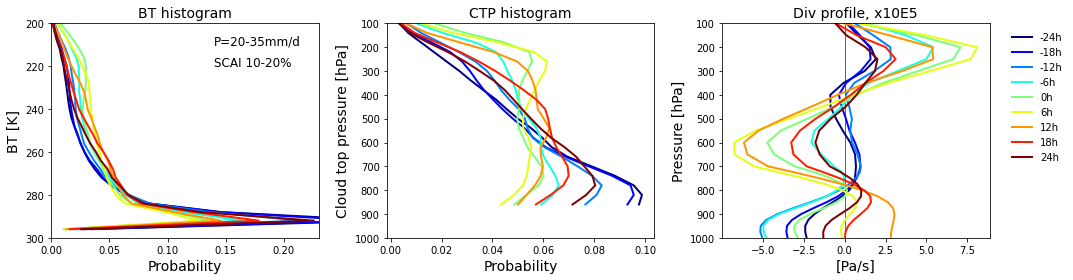

In [86]:
cmp=plt.cm.get_cmap('jet')
colors_time=cmp(np.linspace(0,1,9))
line_label = ['-24h','-18h','-12h','-6h','0h','6h','12h','18h','24h']

fig, ax = plt.subplots(1,3,figsize=(15,4))

tt = [8,10,12,14,16,18,20,22,24]
for i,t in enumerate(tt):
    ax[0].plot(bt_dist_dec[1,1,t,:]/np.sum(bt_dist_dec[1,1,t,:]),bt_bins[:-1]
               ,color=colors_time[i],linewidth=2)
ax[0].set_xlabel('Probability',fontsize=14)
ax[0].set_ylabel('BT [K]',fontsize=14)
ax[0].set_ylim([300,200])    

for i,t in enumerate(tt):
    ax[1].plot(gaussian_filter(ctp_dist_dec[1,1,t,:]/np.sum(ctp_dist_dec[1,1,t,:]),1),ctp_bins[:-1]
               ,color=colors_time[i],linewidth=2)
ax[1].set_xlabel('Probability',fontsize=14)
ax[1].set_ylabel('Cloud top pressure [hPa]',fontsize=14)
ax[1].set_ylim([1000,100])    

for i,t in enumerate(tt):
    ax[2].plot(10e5*gaussian_filter(div_dec[1,1,t,:],1),lev,color=colors_time[i],label=line_label[i],linewidth=2)
ax[2].set_xlabel('[Pa/s]',fontsize=14)
ax[2].set_ylabel('Pressure [hPa]',fontsize=14)
ax[2].set_ylim([1000,100])    
ax[2].vlines(x=0,ymin=100,ymax=1000,linewidth=1)

ax[0].set_title('BT histogram',fontsize=14)
ax[0].text(0.14,210,'P=20-35mm/d',fontsize=12); ax[0].text(0.14,220,'SCAI 10-20%',fontsize=12)
ax[0].set_xlim([0,0.23])
ax[1].set_title('CTP histogram',fontsize=14)
ax[2].set_title('Div profile, x10E5',fontsize=14)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, framealpha=0.0)
plt.tight_layout(w_pad=1.5)

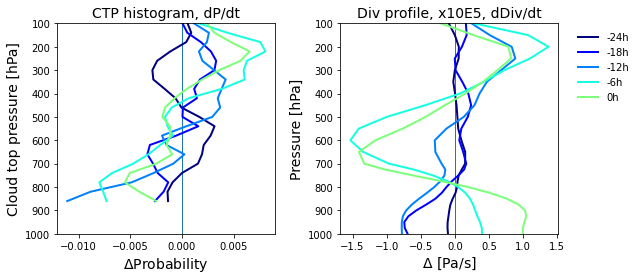

In [87]:
cmp=plt.cm.get_cmap('jet')
colors_time=cmp(np.linspace(0,1,9))
line_label = ['-24h','-18h','-12h','-6h','0h','6h','12h','18h','24h']

fig, ax = plt.subplots(1,2,figsize=(9,4))

tt = [8,10,12,14,16]
for i,t in enumerate(tt):
    ctp_dt = gaussian_filter(ctp_dist_dec[1,1,t,:]/np.sum(ctp_dist_dec[1,1,t,:]),1) - \
                gaussian_filter(ctp_dist_dec[1,1,t-1,:]/np.sum(ctp_dist_dec[1,1,t-1,:]),1)
    ax[0].plot(ctp_dt,ctp_bins[:-1]
               ,color=colors_time[i],linewidth=2)
ax[0].set_xlabel('$\Delta$Probability',fontsize=14)
ax[0].set_ylabel('Cloud top pressure [hPa]',fontsize=14)
ax[0].set_ylim([1000,100])    

div_dt = np.gradient(div_dec,axis=2)
for i,t in enumerate(tt):
    div_dt = gaussian_filter(div_dec[1,1,t,:],1) - gaussian_filter(div_dec[1,1,t-1,:],1)
    ax[1].plot(10e5*div_dt,lev,color=colors_time[i],label=line_label[i],linewidth=2)
ax[1].set_xlabel('$\Delta$ [Pa/s]',fontsize=14)
ax[1].set_ylabel('Pressure [hPa]',fontsize=14)
ax[1].set_ylim([1000,100])    
ax[0].vlines(x=0,ymin=100,ymax=1000,linewidth=1)
ax[1].vlines(x=0,ymin=100,ymax=1000,linewidth=1)

#ax[0].text(0.14,210,'P=20-35mm/d',fontsize=12); ax[0].text(0.14,220,'SCAI 10-20%',fontsize=12)
#ax[0].set_xlim([0,0.23])
ax[0].set_title('CTP histogram, dP/dt',fontsize=14)
ax[1].set_title('Div profile, x10E5, dDiv/dt',fontsize=14)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, framealpha=0.0)
plt.tight_layout(w_pad=1.5)

## 2. Gross moist stability analysis
M = < hflux >/< sflux >

In [88]:
os.chdir('/data/willytsai/ISCCP/')
prec_all_1DRM = np.load('prec_all_5deg_4ds_M2.mat.npy')
prec_all_1DRM = prec_all_1DRM[idx_region,:] # region
prec_all_1DRM = prec_all_1DRM[idx_rm,:] # nan for SCAI, CWV
dpdt_all_1DRM = np.gradient(prec_all_1DRM,np.arange(33)*3,axis=1) # dp/dt [mm/d]/hr
precM2_all_1DRM = np.load('precM2_all_5deg_4ds_M2.mat.npy')
precM2_all_1DRM = precM2_all_1DRM[idx_region,:] # region
precM2_all_1DRM = precM2_all_1DRM[idx_rm,:] # nan for SCAI, CWV

precM2_allre = np.copy(LHF_allre)
for n in range(len(precM2_all_1DRM)):
    x = np.linspace(-48,48,32)
    xnew = np.linspace(-48,48,33)
    f3 = interpolate.interp1d(x, precM2_all_1DRM[n,:], kind='linear')
    precM2_allre[n,:] = f3(xnew) 
precM2_all_1DRM = precM2_allre; 
dpdtM2_all_1DRM = np.gradient(precM2_all_1DRM,np.arange(33)*3,axis=1) # dp/dt [mm/d]/hr

h_all = np.load('mse_all_5deg_4ds_M2.mat.npy')
h_all = h_all[idx_region,:]
h_all = h_all[idx_rm,:] # moist static energy
s_all = np.load('dse_all_5deg_4ds_M2.mat.npy')
s_all = s_all[idx_region,:]
s_all = s_all[idx_rm,:] # moist static energy
hadv_all = np.load('hadv_mn_all_5deg_4ds_M2.mat.npy')
hadv_all = hadv_all[idx_region,:]
hadv_all = hadv_all[idx_rm,:]
sadv_all = np.load('sadv_mn_all_5deg_4ds_M2.mat.npy')
sadv_all = sadv_all[idx_region,:]
sadv_all = sadv_all[idx_rm,:]

# MERRA2 radiation
QR_all = -lwtoa_all + swtoa_all - lwgnt_all - swgnt_all
F_all = QR_all + LHF_all + SHF_all # <QR> + S, incoming adiabatic sources
# CERES radiation
QR_ce_all = QR_ce_all
F_ce_all = QR_ce_all + LHF_all + SHF_all

S_all = LHF_all + SHF_all

# cloud top pressure
#ctp_all = ctp_mn_all # mean 

In [89]:
for n in range(len(time_event)):
    for t in range(33):
        if np.isnan(hadv_all[n,t,0]) == 1:
            hadv_all[n,t,0] = hadv_all[n,t,1]
        if np.isnan(sadv_all[n,t,0]) == 1:    
            sadv_all[n,t,0] = sadv_all[n,t,1]

In [90]:
# GMS components
#vint_hv = -np.trapz(hflux_all[:,:,:25],lev[:25]*100,axis=2)/9.8
#vint_sv = -np.trapz(sflux_all[:,:,:25],lev[:25]*100,axis=2)/9.8
vint_hadv_h = -np.trapz(hadv_all[:,:,:25],lev[:25]*100,axis=2)/9.8
vint_hadv_s = -np.trapz(sadv_all[:,:,:25],lev[:25]*100,axis=2)/9.8
vint_vadv_h = -np.trapz((omega_all*np.gradient(h_all,lev*100,axis=2))[:,:,:25],lev[:25]*100,axis=2)/9.8
vint_vadv_s = -np.trapz((omega_all*np.gradient(s_all,lev*100,axis=2))[:,:,:25],lev[:25]*100,axis=2)/9.8
#vint_hv_hori = -np.trapz(hfluxh_all[:,:,:25],lev[:25]*100,axis=2)/9.8
vint_dse = -np.trapz(s_all[:,:,:25],lev[:25]*100,axis=2)/9.8

### 1-d running mean 

In [91]:
# removing diurnal cycle by 1-d running mean 
vint_hv_rm = np.zeros((len(time_event),33))
vint_sv_rm = np.copy(vint_hv_rm)
vint_hadv_h_rm = np.copy(vint_hv_rm)
vint_vadv_h_rm = np.copy(vint_hv_rm)
vint_hadv_s_rm = np.copy(vint_hv_rm)
vint_vadv_s_rm = np.copy(vint_hv_rm)
F_all_rm = np.copy(vint_hv_rm)
F_ce_all_rm = np.copy(vint_hv_rm)
S_all_rm = np.copy(vint_hv_rm)
QR_all_rm = np.copy(vint_hv_rm)
QR_ce_all_rm = np.copy(vint_hv_rm)
prec_all_1DRM_rm = np.copy(vint_hv_rm)
dpdt_all_1DRM_rm = np.copy(vint_hv_rm)
precM2_all_1DRM_rm = np.copy(vint_hv_rm)
dpdtM2_all_1DRM_rm = np.copy(vint_hv_rm)
cwv_all_rm = np.copy(vint_hv_rm)
#CAPE_all_rm = np.copy(vint_hv_rm)
#CIN_all_rm = np.copy(vint_hv_rm)
#llws_all_rm = np.copy(vint_hv_rm)
#ctp_all_rm = np.copy(vint_hv_rm)
SCAIbt_all_rm = np.copy(vint_hv_rm)
vint_dse_rm = np.copy(vint_hv_rm)

for t in range(len(time_event)):
#    vint_hv_rm[t,:] = running_mean(vint_hv[t,:],8)
#    vint_sv_rm[t,:] = running_mean(vint_sv[t,:],8)
    vint_hadv_h_rm[t,:] = running_mean(vint_hadv_h[t,:],8)
    vint_vadv_h_rm[t,:] = running_mean(vint_vadv_h[t,:],8)
    vint_hadv_s_rm[t,:] = running_mean(vint_hadv_s[t,:],8)
    vint_vadv_s_rm[t,:] = running_mean(vint_vadv_s[t,:],8)    
    F_all_rm[t,:] = running_mean(F_all[t,:],8)
    F_ce_all_rm[t,:] = running_mean(F_ce_all[t,:],8)

    QR_all_rm[t,:] =  running_mean(QR_all[t,:],8)
    QR_ce_all_rm[t,:] = running_mean(QR_ce_all[t,:],8)
    S_all_rm[t,:] = running_mean(S_all[t,:],8)
    prec_all_1DRM_rm[t,:] = prec_all_1DRM[t,:]
    dpdt_all_1DRM_rm[t,:] = dpdt_all_1DRM[t,:]
    precM2_all_1DRM_rm[t,:] = precM2_all_1DRM[t,:]
    dpdtM2_all_1DRM_rm[t,:] = dpdt_all_1DRM[t,:]
    cwv_all_rm[t,:] = cwv_all[t,:]
#     CAPE_all_rm[t,:] = cape_all[t,:]
#     CIN_all_rm[t,:] =  cin_all[t,:]
#    llws_all_rm[t,:] = llws_all[t,:]
#    ctp_all_rm[t,:] = ctp_mn_all[t,:]
    SCAIbt_all_rm[t,:] = SCAIbt_all[t,:]
    vint_dse_rm[t,:] = running_mean(vint_dse[t,:],8)

#### matching running mean P peak with origional P peak for time-series

In [92]:
# idx_pmatch = []
# for n in range(len(prec_all_1DRM_rm)):
#     if prec_all_1DRM_rm[n,16] == np.max(prec_all_1DRM_rm[n,:]):
#         idx_pmatch.append(n)
# idx_pmatch = np.asarray(idx_pmatch)

In [93]:
# vint_hv_rm = vint_hv_rm[idx_pmatch,:]
# vint_sv_rm = vint_sv_rm[idx_pmatch,:]
# vint_hadv_h_rm = vint_hadv_h_rm[idx_pmatch,:]
# vint_vadv_h_rm = vint_vadv_h_rm[idx_pmatch,:]
# vint_hadv_s_rm = vint_hadv_s_rm[idx_pmatch,:]
# vint_vadv_s_rm = vint_vadv_s_rm[idx_pmatch,:]
# F_all_rm = F_all_rm[idx_pmatch,:]
# F_ce_all_rm = F_ce_all_rm[idx_pmatch,:]
# S_all_rm = S_all_rm[idx_pmatch,:] 
# QR_ce_all_rm = QR_ce_all_rm[idx_pmatch,:]
# prec_all_1DRM_rm = prec_all_1DRM_rm[idx_pmatch,:]
# dpdt_all_1DRM_rm = dpdt_all_1DRM_rm[idx_pmatch,:]
# precM2_all_1DRM_rm = precM2_all_1DRM_rm[idx_pmatch,:]
# dpdtM2_all_1DRM_rm = dpdtM2_all_1DRM_rm[idx_pmatch,:]
# cwv_all_rm = cwv_all_rm[idx_pmatch,:]
# CAPE_all_rm = CAPE_all_rm[idx_pmatch,:]
# CIN_all_rm = CIN_all_rm[idx_pmatch,:]
# llws_all_rm = llws_all_rm[idx_pmatch,:]
# ctp_all_rm = ctp_all_rm[idx_pmatch,:]

In [94]:
# defined GMS with 1-d running mean 
M_all = (vint_hadv_h_rm + vint_vadv_h_rm)/(vint_hadv_s_rm + vint_vadv_s_rm)
Mc_all = F_all_rm/(vint_hadv_s_rm + vint_vadv_s_rm)
Md_all = M_all - Mc_all
Mh_all = vint_hadv_h_rm/(vint_hadv_s_rm + vint_vadv_s_rm)
Mv_all = vint_vadv_h_rm/(vint_hadv_s_rm + vint_vadv_s_rm)

#------- remove outliers with 2std in horizontal -------
hadv_up = np.nanmean(vint_hadv_h_rm) + 2*np.nanstd(vint_hadv_h_rm)
hadv_dn = np.nanmean(vint_hadv_h_rm) - 2*np.nanstd(vint_hadv_h_rm)

mask_mh = np.where(np.logical_or(vint_hadv_h_rm > hadv_up, vint_hadv_h_rm < hadv_dn))

In [95]:
# removing out larger Mh (Mh<-3)
M_all[mask_mh] = np.nan
Mc_all[mask_mh] = np.nan
Md_all[mask_mh] = np.nan
Mh_all[mask_mh] = np.nan
Mv_all[mask_mh] = np.nan
vint_hv_rm[mask_mh] = np.nan
vint_sv_rm[mask_mh] = np.nan
vint_hadv_h_rm[mask_mh] = np.nan
vint_vadv_h_rm[mask_mh] = np.nan
vint_hadv_s_rm[mask_mh] = np.nan
vint_vadv_s_rm[mask_mh] = np.nan
F_all_rm[mask_mh] = np.nan
F_ce_all_rm[mask_mh] = np.nan
QR_all_rm[mask_mh] = np.nan
QR_ce_all_rm[mask_mh] = np.nan
S_all_rm[mask_mh] = np.nan
prec_all_1DRM_rm[mask_mh] = np.nan
dpdt_all_1DRM_rm[mask_mh] = np.nan
precM2_all_1DRM_rm[mask_mh] = np.nan
dpdtM2_all_1DRM_rm[mask_mh] = np.nan
cwv_all_rm[mask_mh] = np.nan
# CAPE_all_rm[mask_mh] = np.nan
# CIN_all_rm[mask_mh] = np.nan
# llws_all_rm[mask_mh] = np.nan
# ctp_all_rm[mask_mh] = np.nan
SCAIbt_all_rm[mask_mh] = np.nan
vint_dse_rm[mask_mh] = np.nan

# adding timestamp
timestamp_all = np.tile(np.linspace(-48,48,33),len(M_all))
timestamp_all_rm = np.reshape(timestamp_all,(len(M_all),33))
timestamp_all_rm[mask_mh] = np.nan

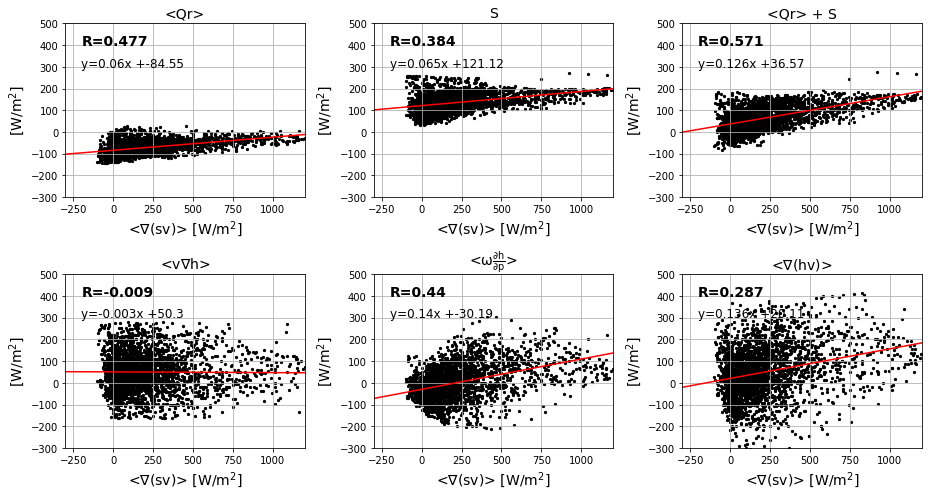

In [96]:
fig,ax = plt.subplots(2,3,figsize=(13,7))
ax_i = [0,0,0,1,1,1]; ax_j = [0,1,2,0,1,2]
titles = ['<Qr>','S','<Qr> + S',r'<v$\nabla$h>',r'<$\rm\omega \frac{\partial\rm h}{\partial\rm p}$>',r'<$\nabla$(hv)>']


for n, var in enumerate([QR_ce_all_rm, S_all_rm, F_ce_all_rm, vint_hadv_h_rm, vint_vadv_h_rm, vint_hadv_h_rm+vint_vadv_h_rm]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter((vint_hadv_s_rm+vint_vadv_s_rm)[2000:2100,:],var[2000:2100,:],s=5,color='k')
    # linear fitting
    v1 = (vint_hadv_s_rm+vint_vadv_s_rm)[2000:2100,:].flatten()
    v2 = var[2000:2100,:].flatten()
    slp,yint,r,p_val,std_err = linregress(v1[~np.isnan(v1)],v2[~np.isnan(v1)])
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    ax[i,j].text(-200,400,'R='+str(round(r,3)),fontsize=14,fontweight='bold')
    ax[i,j].text(-200,300,'y='+str(round(slp,3))+'x +'+str(round(yint,2)),fontsize=12)
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].grid()
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'<$\nabla$(sv)> [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=14)
plt.tight_layout()

In [97]:
# regression, joint histogram for all events
def hist_sv_mp(mp, sv):
    
    vint_sv_bins = np.linspace(-300,1200,51)
    vint_mp_bins = np.linspace(-500,500,51)

    hist_com = np.zeros((len(vint_sv_bins)-1,len(vint_mp_bins)-1))
                           
    mp = mp.flatten();sv = sv.flatten()
    for i in range(len(vint_sv_bins)-1):
        for j in range(len(vint_mp_bins)-1):
            idx = np.where(np.logical_and(sv>=vint_sv_bins[i], sv<vint_sv_bins[i+1]))[0]
            idy = np.where(np.logical_and(mp>=vint_mp_bins[j], mp<vint_mp_bins[j+1]))[0]
            idx_com = np.intersect1d(idx,idy)
                           
            hist_com[i,j] = len(idx_com)
                        
    return hist_com

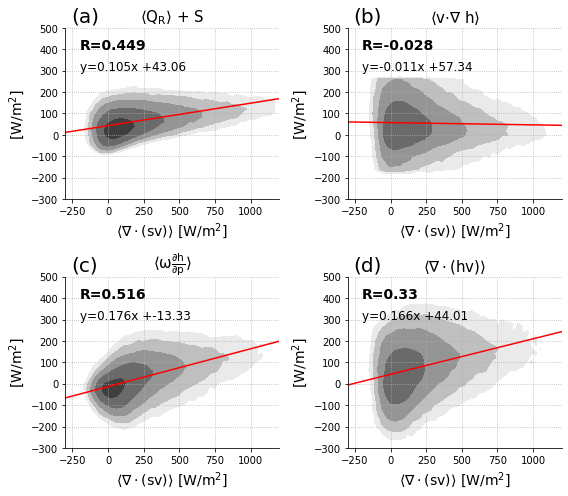

In [98]:
fig,ax = plt.subplots(2,2,figsize=(8,7))
ax_i = [0,0,1,1]; ax_j = [0,1,0,1]
titles = [r'$\langle$Q$\rm_R$$\rangle$ + S',r'$\langle$v$\cdot\nabla$ h$\rangle$',r'$\langle$$\rm\omega \frac{\partial\rm h}{\partial\rm p}$$\rangle$'
          ,r'$\langle$$\nabla\cdot$(hv)$\rangle$']
fig_num = ['(a)','(b)','(c)','(d)']
vint_sv_bins = np.linspace(-300,1200,51)
vint_mp_bins = np.linspace(-500,500,51)

for n, var in enumerate([F_ce_all_rm[:,:], vint_hadv_h_rm[:,:], vint_vadv_h_rm[:,:], 
                         vint_hadv_h_rm[:,:]+vint_vadv_h_rm[:,:]]):
    
    # calculating the histogram 
    hist_com = hist_sv_mp(var, vint_hadv_s_rm+vint_vadv_s_rm)
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].contourf(vint_sv_bins[:-1],vint_mp_bins[:-1],np.log10((hist_com/np.sum(hist_com))).T
                    ,levels=[-4,-3.5,-3,-2.5,-2,-1.5,-1],cmap='binary')
    # linear fitting
    v1 = var.flatten(); idx = np.where(np.isnan(v1)==0)[0]
    v2 = (vint_hadv_s_rm+vint_vadv_s_rm).flatten(); idy = np.where(np.isnan(v2)==0)[0]
    idx_nan = np.intersect1d(idx,idy)
    slp,yint,r,p_val,std_err = linregress(v2[idx_nan],v1[idx_nan])
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    # annotation
    ax[i,j].text(-200,400,'R='+str(round(r,3)),fontsize=14,fontweight='bold')
    ax[i,j].text(-200,300,'y='+str(round(slp,3))+'x +'+str(round(yint,2)),fontsize=12)
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'$\langle$$\nabla\cdot$(sv)$\rangle$ [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=15)
    ax[i,j].text(-260,530,fig_num[n],fontsize=20)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].grid(linestyle=':')

plt.tight_layout()
#fig.savefig(fig_dir+'GMScomps_events.pdf',bbox_inches='tight')

In [99]:
M_test = M_all[:,:].flatten()
Md_test = Md_all[:,:].flatten()
Mh_test = (vint_hadv_h_rm/(vint_hadv_s_rm + vint_vadv_s_rm))[:].flatten()
Mv_test = (vint_vadv_h_rm/(vint_hadv_s_rm + vint_vadv_s_rm))[:].flatten()
Mc_test = Mc_all[:].flatten()
prec_test = prec_all_1DRM_rm[:,:].flatten()
dpdt_test = dpdt_all_1DRM_rm[:,:].flatten()
precM2_test = precM2_all_1DRM_rm[:,:].flatten()
dpdtM2_test = dpdtM2_all_1DRM_rm[:,:].flatten()
vint_sv_test = (vint_hadv_s_rm + vint_vadv_s_rm)[:,:].flatten()
cwv_test = cwv_all_rm[:,:].flatten()
S_test = S_all_rm[:,:].flatten()
# CAPE_test = CAPE_all_rm[:,:].flatten()
# CIN_test = CIN_all_rm[:,:].flatten()
# llws_test = llws_all_rm[:,:].flatten()
# ctp_test = ctp_all_rm[:,:].flatten()
timestamp_test = timestamp_all_rm[:,:].flatten()

nan_mask = np.isnan(M_test) # maskout nan for proecess of removing outliers in M
M_test = M_test[~nan_mask]
Md_test = Md_test[~nan_mask]
Mh_test = Mh_test[~nan_mask]
Mv_test = Mv_test[~nan_mask]
Mc_test = Mc_test[~nan_mask]
prec_test = prec_test[~nan_mask]
dpdt_test = dpdt_test[~nan_mask]
precM2_test = precM2_test[~nan_mask]
dpdtM2_test = dpdtM2_test[~nan_mask]
vint_sv_test = vint_sv_test[~nan_mask]
cwv_test = cwv_test[~nan_mask]
S_test = S_test[~nan_mask]
# CAPE_test = CAPE_test[~nan_mask]
# CIN_test = CIN_test[~nan_mask]
# llws_test = llws_test[~nan_mask]
# ctp_test = ctp_test[~nan_mask]
timestamp_test = timestamp_test[~nan_mask]

#remove 5% outliers
# Mcri_up = np.percentile(M_test,95)
# Mcri_low = np.percentile(M_test,5)
# idx_outlier = np.where(np.logical_and(M_test> Mcri_low, M_test < Mcri_up))[0]

# M_test = M_test[idx_outlier]
# Md_test = Md_test[idx_outlier]
# Mh_test = Mh_test[idx_outlier]
# Mv_test = Mv_test[idx_outlier]
# Mc_test = Mc_test[idx_outlier]
# prec_test = prec_test[idx_outlier]
# precM2_test = precM2_test[idx_outlier]
# vint_sv_test = vint_sv_test[idx_outlier]
# cwv_test = cwv_test[idx_outlier]
# S_test = S_test[idx_outlier]
# CAPE_test = CAPE_test[idx_outlier]
# CIN_test = CIN_test[idx_outlier]
# llws_test = llws_test[idx_outlier]
#timestamp_test = timestamp_test[idx_outlier]

In [100]:
# remove sv < 10 W/m^2
idx_sv = np.where(vint_sv_test>10)[0]

M = M_test[idx_sv]
Md = Md_test[idx_sv]
Mh = Mh_test[idx_sv]
Mv = Mv_test[idx_sv]
Mc = Mc_test[idx_sv]
# qr_net = qr_net[idx_rm]
# F = F[idx_rm]
# vint_del_sv = vint_del_sv[idx_rm]
# vint_del_hv = vint_del_hv[idx_rm]
# vint_sadv = vint_sadv[idx_rm]
# vint_hadv = vint_hadv[idx_rm]
# vint_wdhdp = vint_wdhdp[idx_rm]
# vint_wdsdp = vint_wdsdp[idx_rm]
prec = prec_test[idx_sv]
dpdt = dpdt_test[idx_sv]
precM2 = precM2_test[idx_sv]
dpdtM2 = dpdtM2_test[idx_sv]
cwv = cwv_test[idx_sv]
S = S_test[idx_sv]
# CAPE = CAPE_test[idx_sv]
# CIN = CIN_test[idx_sv]
# llws = llws_test[idx_sv]
# ctp = ctp_test[idx_sv]
timestampp = timestamp_test[idx_sv]

In [101]:
# removing outliers 2.5% on both tails of PDF of M-Mc
test = np.sort(Md)
idx_test = np.argsort(Md)

In [102]:
# M-Mc, sorted array by Md = M-Mc
M_fn = M[idx_test]
Md_fn = Md[idx_test]
Mh_fn = Mh[idx_test]
Mv_fn = Mv[idx_test]
Mc_fn = Mc[idx_test]
# qr_net_rm = qr_net[idx_test]
# F_rm = F[idx_test]
# vint_del_sv_rm = vint_del_sv[idx_test]
# vint_del_hv_rm = vint_del_hv[idx_test]
# vint_sadv_rm = vint_sadv[idx_test]
# vint_hadv_rm = vint_hadv[idx_test]
# vint_wdhdp_rm = vint_wdhdp[idx_test]
# vint_wdsdp_rm = vint_wdsdp[idx_test]
prec_fn = prec[idx_test]
dpdt_fn = dpdt[idx_test]
precM2_fn = precM2[idx_test]
dpdtM2_fn = dpdtM2[idx_test]
cwv_fn = cwv[idx_test]
S_fn = S[idx_test]
# CAPE_fn = CAPE[idx_test]
# CIN_fn = CIN[idx_test]
# llws_fn = llws[idx_test]
# ctp_fn = ctp[idx_test]
timestamp_fn = timestampp[idx_test]

In [103]:
# grouping into 10
group_bins = np.percentile(Md_fn,np.arange(0,100,10))
prec_bins = np.zeros(10)
dpdt_bins = np.zeros(10)
precM2_bins = np.zeros(10)
dpdtM2_bins = np.zeros(10)
Md_bins = np.zeros(10)
Mh_bins = np.zeros(10)
Mv_bins = np.zeros(10)
Mc_bins = np.zeros(10)
cwv_bins = np.zeros(10)
S_bins = np.zeros(10)
CAPE_bins = np.zeros(10)
CIN_bins = np.zeros(10)
llws_bins = np.zeros(10)
ctp_bins = np.zeros(10)
timestamp_bins = np.zeros(10)

prec_stdbins = np.zeros(10)
precM2_stdbins = np.zeros(10)
Md_stdbins = np.zeros(10)
Mh_stdbins = np.zeros(10)
Mv_stdbins = np.zeros(10)
Mc_stdbins = np.zeros(10)
cwv_stdbins = np.zeros(10)
S_stdbins = np.zeros(10)
# CAPE_stdbins = np.zeros(10)
# CIN_stdbins = np.zeros(10)
# llws_stdbins = np.zeros(10)
# ctp_stdbins = np.zeros(10)
timestamp_stdbins = np.zeros(10)

for n in range(10):
    if n < 9:
        idx = np.where(np.logical_and(Md_fn>=group_bins[n], Md_fn<=group_bins[n+1]))[0]
    else:
        idx = np.where(Md_fn>=group_bins[n])[0]
        
    prec_bins[n] = np.nanmean(24*prec_fn[idx]) # [mm/d]
    dpdt_bins[n] = np.nanmean(dpdt_fn[idx])
    precM2_bins[n] = np.nanmean(24*3600*precM2_fn[idx]) # [mm/d]
    dpdtM2_bins[n] = np.nanmean(dpdtM2_fn[idx])
    Md_bins[n] = np.nanmean(Md_fn[idx]); Md_stdbins[n] = np.nanstd(Md_fn[idx])/np.sqrt(len(idx))
    Mh_bins[n] = np.nanmean(Mh_fn[idx]); Mh_stdbins[n] = np.nanstd(Mh_fn[idx])/np.sqrt(len(idx))
    Mv_bins[n] = np.nanmean(Mv_fn[idx]); Mv_stdbins[n] = np.nanstd(Mv_fn[idx])/np.sqrt(len(idx))
    Mc_bins[n] = np.nanmean(Mc_fn[idx]); Mc_stdbins[n] = np.nanstd(Mc_fn[idx])/np.sqrt(len(idx))
    cwv_bins[n] = np.nanmean(cwv_fn[idx]); cwv_stdbins[n] = np.nanstd(cwv_fn[idx])/np.sqrt(len(idx))
    S_bins[n] = np.nanmean(S_fn[idx]); S_stdbins[n] = np.nanstd(S_fn[idx])/np.sqrt(len(idx))
#     CAPE_bins[n] = np.nanmean(CAPE_fn[idx]); CAPE_stdbins[n] = np.nanstd(CAPE_fn[idx])/np.sqrt(len(idx))
#     CIN_bins[n] = np.nanmean(CIN_fn[idx]); CIN_stdbins[n] = np.nanstd(CIN_fn[idx])/np.sqrt(len(idx))    
#     llws_bins[n] = np.nanmean(llws_fn[idx]); llws_stdbins[n] = np.nanmean(llws_fn[idx])/np.sqrt(len(idx))
#     ctp_bins[n] = np.nanmean(ctp_fn[idx]); ctp_stdbins[n] = np.nanmean(ctp_fn[idx])/np.sqrt(len(idx))
    timestamp_bins[n] = np.nanmean(timestamp_fn[idx]); timestamp_stdbins = np.nanstd(timestamp_fn[idx])/np.sqrt(len(idx))

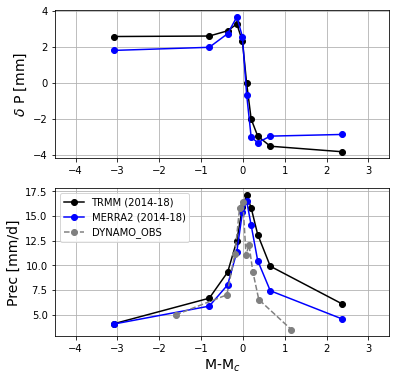

In [104]:
fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(Md_bins,np.gradient(prec_bins,1),'-ok')
ax[0].plot(Md_bins,np.gradient(precM2_bins,1),'-ob')

ax[1].plot(Md_bins,prec_bins,'-ok')
ax[1].plot(Md_bins,precM2_bins,'-ob')
#ax[1].plot(np.linspace(-4.5,0,100),4*np.exp(0.28*(np.linspace(-4.5,0,100)+4.5)))

ax[0].set_xlim([-4.5,3.5]);ax[1].set_xlim([-4.5,3.5])
ax[0].set_ylabel('$\delta$ P [mm]',fontsize=14)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14)
ax[0].grid();ax[1].grid()

# adding Dynamo results as reference, 3-month data, 3hrly, SSA array
Md_dynamo = np.load('Dynamo_Mdbins_Md.npy')
prec_dynamo = np.load('Dynamo_prec_Md.npy')
ax[1].plot(Md_dynamo,prec_dynamo,'--ok',color='grey')
ax[1].legend(['TRMM (2014-18)','MERRA2 (2014-18)','DYNAMO_OBS'])

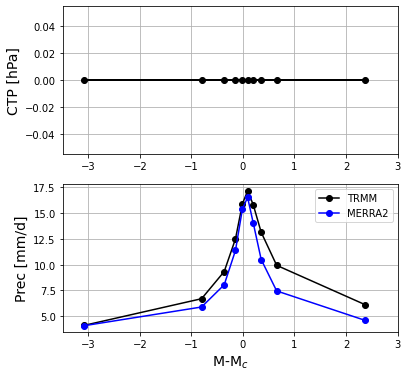

In [105]:
# time mark for EGMS space 
fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(Md_bins,ctp_bins,'-ok',linewidth=2)

ax[1].plot(Md_bins,prec_bins,'-ok')
ax[1].plot(Md_bins,precM2_bins,'-ob')
#ax[1].plot(np.linspace(-4.5,0,100),4*np.exp(0.28*(np.linspace(-4.5,0,100)+4.5)))

ax[0].set_xlim([-3.5,3])
ax[1].set_xlim([-3.5,3])
ax[0].set_ylabel('CTP [hPa]',fontsize=14)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14)
ax[0].grid();ax[1].grid()

# adding Dynamo results as reference, 3-month data, 3hrly, SSA array
# Md_dynamo = np.load('Dynamo_Mdbins_Md.npy')
# prec_dynamo = np.load('Dynamo_prec_Md.npy')
# ax[1].plot(Md_dynamo,prec_dynamo,'--ok',color='grey')
ax[1].legend(['TRMM','MERRA2'])

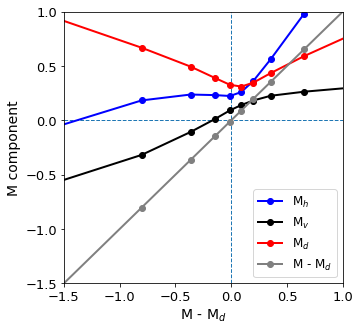

In [106]:
fig = plt.figure(figsize=(5,5))
plt.plot(Md_bins,Mh_bins,'-ob',linewidth=2)
plt.plot(Md_bins,Mv_bins,'-ok',linewidth=2)
plt.plot(Md_bins,Mc_bins,'-or',linewidth=2)
plt.plot(Md_bins,Md_bins,'-o',color='grey',linewidth=2)
plt.xlim([-1.5,1]);plt.ylim([-1.5,1])
plt.vlines(x=0,ymin=-1.5,ymax=1,linewidth=1,linestyle='--')
plt.hlines(y=0,xmin=-1.5,xmax=1,linewidth=1,linestyle='--')
plt.legend(['M$_h$','M$_v$','M$_d$','M - M$_d$'],loc=4,fontsize=12)
plt.xlabel('M - M$_d$',fontsize=14)
plt.ylabel('M component',fontsize=14)
plt.tick_params(labelsize=13)

In [107]:
# fig, ax = plt.subplots(2,2,figsize=(12,6))

# ax[0,0].plot(Md_bins,cwv_bins,'-ok')
# ax[0,1].plot(Md_bins,S_bins,'-ok')
# ax[1,0].plot(Md_bins,CAPE_bins,'-ok')
# ax[1,1].plot(Md_bins,CIN_bins,'-ok')

# #ax[0].set_xlim([-4.5,2.5]);ax[1].set_xlim([-4.5,2.5])
# ax[0,0].set_ylabel('CWV [mm]',fontsize=14)
# ax[0,1].set_ylabel('SFX [W/m$^2$]',fontsize=14)
# ax[1,0].set_ylabel('CAPE [J/kg]',fontsize=14)
# ax[1,1].set_ylabel('CIN [J/kg]',fontsize=14)

# ax[1,0].set_xlabel('M-M$_c$',fontsize=14)
# ax[1,1].set_xlabel('M-M$_c$',fontsize=14)
# ax[0,0].grid();ax[0,1].grid();ax[1,0].grid();ax[1,1].grid()

In [108]:
# fig, ax = plt.subplots(2,2,figsize=(12,6))

# ax[0,0].plot(Md_bins,cwv_bins,'-ok')
# ax[0,1].plot(Md_bins,llws_bins,'-ok')
# ax[1,0].plot(Md_bins,CAPE_bins,'-ok')
# ax[1,1].plot(Md_bins,CIN_bins,'-ok')

# #ax[0].set_xlim([-4.5,2.5]);ax[1].set_xlim([-4.5,2.5])
# ax[0,0].set_ylabel('CWV [mm]',fontsize=14)
# ax[0,1].set_ylabel('Shear [m/s]$^2$',fontsize=14)
# ax[1,0].set_ylabel('CAPE [J/kg]',fontsize=14)
# ax[1,1].set_ylabel('CIN [J/kg]',fontsize=14)

# ax[1,0].set_xlabel('M-M$_c$',fontsize=14)
# ax[1,1].set_xlabel('M-M$_c$',fontsize=14)
# ax[0,0].grid();ax[0,1].grid();ax[1,0].grid();ax[1,1].grid()

In [109]:
# precipitation dependence on aggregation in the EGMS space
# grouping into 10
def vars_Mspace(idx_array, Md_rm, var_rm, vint_sv_rm):

    Md_fn = Md_rm[idx_array,:].flatten()
    var_fn = var_rm[idx_array,:].flatten()
    vint_sv_fn = vint_sv_rm[idx_array,:].flatten()
    
    # remove nan in Md_fn, and vint_sv > 10 
    idx_nan = np.where(np.isnan(Md_fn)==0)[0]
    idx_sv = np.where(vint_sv_fn>10)[0]
    idx_com = np.intersect1d(idx_nan, idx_sv)
    Md_fn = Md_fn[idx_com]
    var_fn = var_fn[idx_com]

    group_bins = np.percentile(Md_fn,np.arange(0,100,10)) # deciles
    var_bins = np.zeros(10)
    var_stdbins = np.copy(var_bins)

    for n in range(10):
        if n < 9:
            idx = np.where(np.logical_and(Md_fn>=group_bins[n], Md_fn<=group_bins[n+1]))[0]
        else:
            idx = np.where(Md_fn>=group_bins[n])[0]

        var_bins[n] = np.nanmean(var_fn[idx]) 
        var_stdbins[n] = np.nanstd(var_fn[idx])/np.sqrt(len(idx))
        
    return var_bins

In [110]:
def idx_decile(prec_all,prec_bins2,SCAIbt_all,SCAI_deciles_p):
    idx_dec = []
    for i in range(len(prec_bins2)-1):
        idx_com =[]
        idx = np.where(np.logical_and(86400*precM2_all[:,16]>=prec_bins2[i],86400*precM2_all[:,16]<prec_bins2[i+1]))[0]

        for n in range(10):
            if n < 9:
                idy = np.where(np.logical_and(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n],SCAIbt_all[:,16] < SCAI_deciles_p[i,n+1]))[0]
            else:
                idy = np.where(SCAIbt_all[:,16]>= SCAI_deciles_p[i,n])[0]
        
            idx_com.append(np.intersect1d(idx,idy))
        idx_dec.append(idx_com)
        
    return idx_dec

In [140]:
idx_dec = idx_decile(prec_all,prec_bins2,SCAIbt_all,SCAI_deciles_p) # rainfall categories x 10 deciles
np.save('/data/willytsai/ISCCP/events_idx_dec_M2.npy',idx_dec)

In [112]:
prec_bins_dec = np.zeros((len(prec_bins2)-1,10,10))
dpdt_bins_dec = np.copy(prec_bins_dec)
precM2_bins_dec = np.copy(prec_bins_dec)
Md_bins_dec = np.copy(prec_bins_dec)
Mv_bins_dec = np.copy(prec_bins_dec)
Mh_bins_dec = np.copy(prec_bins_dec)
Mc_bins_dec = np.copy(prec_bins_dec)
cwv_bins_dec = np.copy(prec_bins_dec)
S_bins_dec = np.copy(prec_bins_dec)
# CAPE_bins_dec = np.copy(prec_bins_dec)
# CIN_bins_dec = np.copy(prec_bins_dec)
# llws_bins_dec = np.copy(prec_bins_dec)
timestamp_bins_dec = np.copy(prec_bins_dec)
dpdt_bins_dec = np.copy(prec_bins_dec)
# ctp_bins_dec = np.copy(prec_bins_dec)

for p in range(len(prec_bins2)-1):
    for d in range(10):
        Md_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, Md_all, vint_hadv_s_rm+vint_vadv_s_rm)
        prec_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, prec_all_1DRM_rm, vint_hadv_s_rm+vint_vadv_s_rm)
        dpdt_bins_dec[p,d,:] = vars_Mspace(idx_dec[p][d], Md_all, dpdt_all_1DRM_rm, vint_hadv_s_rm+vint_vadv_s_rm)
        precM2_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, precM2_all_1DRM_rm, vint_hadv_s_rm+vint_vadv_s_rm)
        Mv_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, Mv_all, vint_hadv_s_rm+vint_vadv_s_rm)
        Mh_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, Mh_all, vint_hadv_s_rm+vint_vadv_s_rm)
        Mc_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, Mc_all, vint_hadv_s_rm+vint_vadv_s_rm)        
        cwv_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, cwv_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)
        S_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, S_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)
#         CAPE_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, CAPE_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)
#         CIN_bins_dec[p,d,:] =  vars_Mspace(idx_dec[p][d], Md_all, CIN_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)
#         llws_bins_dec[p,d,:] = vars_Mspace(idx_dec[p][d], Md_all, llws_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)
        timestamp_bins_dec[p,d,:] = vars_Mspace(idx_dec[p][d], Md_all, timestamp_all_rm, vint_hadv_s_rm+vint_vadv_s_rm)


### dp/dt = -F*P(M-Mc), finding correspondent F for each SCAI decile in GMS space

In [113]:
def GMScomp_time(idx_array, M_all, Md_all, Mh_all, Mv_all, Mc_all, prec_rm, precM2_rm, vint_hadv_s_rm, vint_vadv_s_rm, vint_hadv_h_rm, vint_vadv_h_rm,
                 cwv_rm, F_all_rm, S_all_rm, SCAIbt_all_rm, vint_dse_rm):
    # checking phyiscal dimension, time-series of M-Mc for event composite 
    M_t = M_all[idx_array,:]
    Md_t = Md_all[idx_array,:]
    prec_t = prec_rm[idx_array,:]
    precM2_t = precM2_rm[idx_array,:]
    vint_sv_t = (vint_hadv_s_rm + vint_vadv_s_rm)[idx_array,:]
    vint_hadv_s_t = vint_hadv_s_rm[idx_array,:]
    vint_vadv_s_t = vint_vadv_s_rm[idx_array,:]
    vint_hadv_h_t = vint_hadv_h_rm[idx_array,:]
    vint_vadv_h_t = vint_vadv_h_rm[idx_array,:]
    vint_dse_t = vint_dse_rm[idx_array,:]

    Mh_t = Mh_all[idx_array,:]
    Mv_t = Mv_all[idx_array,:]
    Mc_t = Mc_all[idx_array,:]
    Mc_S_t = (S_all_rm/(vint_hadv_s_rm + vint_vadv_s_rm))[idx_array,:]
    cwv_t = cwv_rm[idx_array,:]
    SCAI_t = SCAIbt_all_rm[idx_array,:]
    F_t = F_all_rm[idx_array,:]
    S_t = S_all_rm[idx_array,:]
    
    # sv > 10 W/m^2
    sv_cri = 10
    M_t[np.where(vint_sv_t<sv_cri)] = np.nan
    Md_t[np.where(vint_sv_t<sv_cri)] = np.nan
    prec_t[np.where(vint_sv_t<sv_cri)] = np.nan
    precM2_t[np.where(vint_sv_t<sv_cri)] = np.nan
    vint_hadv_h_t[np.where(vint_sv_t<sv_cri)] = np.nan
    vint_vadv_h_t[np.where(vint_sv_t<sv_cri)] = np.nan
    Mh_t[np.where(vint_sv_t<sv_cri)] = np.nan
    Mv_t[np.where(vint_sv_t<sv_cri)] = np.nan
    Mc_t[np.where(vint_sv_t<sv_cri)] = np.nan
    Mc_S_t[np.where(vint_sv_t<sv_cri)] = np.nan
    cwv_t[np.where(vint_sv_t<sv_cri)] = np.nan
    
    vint_hadv_s_t[np.where(vint_sv_t<sv_cri)] = np.nan
    vint_vadv_s_t[np.where(vint_sv_t<sv_cri)] = np.nan
    SCAI_t[np.where(vint_sv_t<sv_cri)] = np.nan
    F_t[np.where(vint_sv_t<sv_cri)] = np.nan
    S_t[np.where(vint_sv_t<sv_cri)] = np.nan
    vint_dse_t[np.where(vint_sv_t<sv_cri)] = np.nan
    
    return (M_t, Md_t, prec_t, precM2_t, Mv_t, Mh_t, Mc_t, Mc_S_t, vint_sv_t, cwv_t,
           vint_hadv_s_t, vint_vadv_s_t, SCAI_t, vint_hadv_h_t, vint_vadv_h_t, F_t, S_t, vint_dse_t)

In [114]:
ptestM2_rm = np.copy(precM2_all_1DRM_rm)
ptest_rm = np.copy(prec_all_1DRM_rm)
for n in range(precM2_all_1DRM_rm.shape[0]):
    ptestM2_rm[n,:] = running_mean(precM2_all_1DRM_rm[n,:],8)
    ptest_rm[n,:] = running_mean(prec_all_1DRM_rm[n,:],8)

In [115]:
a = np.arange(len(prec_bins2)-1)
b = np.arange(10)

# composite time-series of decile
M_t = np.zeros((len(prec_bins2)-1,10,33));Md_t = np.copy(M_t); prec_t = np.copy(M_t); precM2_t = np.copy(M_t); 
Mh_t = np.copy(M_t); Mv_t =  np.copy(M_t); Mc_t = np.copy(M_t); Mc_S_t = np.copy(M_t)
cwv_t = np.copy(M_t); vint_sv_t = np.copy(M_t); vint_hadv_s_t = np.copy(M_t); vint_vadv_s_t = np.copy(M_t)
SFX_t = np.copy(M_t); QR_t = np.copy(M_t); SCAI_t = np.copy(M_t); vint_hadv_h_t = np.copy(M_t);
vint_vadv_h_t = np.copy(M_t); F_t = np.copy(M_t); S_t = np.copy(M_t); vint_dse_t = np.copy(M_t)

for i in a:
    for j in b:
    
        (M, Md, prec, precM2, Mv, Mh, Mc, Mc_S, vint_sv, cwv, vint_hadv_s, vint_vadv_s
         , SCAI, vint_hadv_h, vint_vadv_h, F, S, vint_dse) = GMScomp_time(idx_dec[i][j], M_all, Md_all, Mh_all, Mv_all, Mc_all, prec_all_1DRM_rm, precM2_all_1DRM_rm
                                                                                                  , vint_hadv_s_rm,vint_vadv_s_rm, vint_hadv_h_rm, vint_vadv_h_rm
                                                                                                  , cwv_all_rm, F_ce_all_rm, S_all_rm, SCAIbt_all_rm, vint_dse_rm)
        M_t[i,j,:] = np.nanmean(M,axis=0)
        Md_t[i,j,:] = np.nanmean(Md,axis=0)
        prec_t[i,j,:] = np.nanmean(prec,axis=0)
        precM2_t[i,j,:] = np.nanmean(precM2,axis=0)
        Mh_t[i,j,:] = np.nanmean(Mh,axis=0)
        Mv_t[i,j,:] = np.nanmean(Mv,axis=0)
        Mc_t[i,j,:] = np.nanmean(Mc,axis=0)
        Mc_S_t[i,j,:] = np.nanmean(Mc_S,axis=0)
        vint_sv_t[i,j,:] = np.nanmean(vint_sv,axis=0)
        cwv_t[i,j,:] = np.nanmean(cwv,axis=0)
        vint_hadv_s_t[i,j,:] = np.nanmean(vint_hadv_s,axis=0)
        vint_vadv_s_t[i,j,:] = np.nanmean(vint_vadv_s,axis=0)  
        vint_hadv_h_t[i,j,:] = np.nanmean(vint_hadv_h,axis=0)
        vint_vadv_h_t[i,j,:] = np.nanmean(vint_vadv_h,axis=0)          
        SFX_t[i,j,:] = np.nanmean(Mc_S*vint_sv,axis=0)
        QR_t[i,j,:] = np.nanmean((Mc-Mc_S)*vint_sv,axis=0) 
        SCAI_t[i,j,:] = np.nanmean(SCAI,axis=0) 
        F_t[i,j,:] = np.nanmean(F,axis=0)
        S_t[i,j,:] = np.nanmean(S,axis=0)
        vint_dse_t[i,j,:] = np.nanmean(vint_dse,axis=0)

In [116]:
#fig, ax = plt.subplots(1,2,figsize=(10,4))
SCAI_slp = np.zeros((4,10))
OLR_slp = np.zeros((4,10))
for i in range(4):
    for n in range(10):
        SCAI_slp[i,n], interp, r_val, p_val, stderr = linregress(np.linspace(-24,0,9),SCAI_t[i,n,8:17])
        OLR_slp[i,n], interp, r_val, p_val, stderr = linregress(np.linspace(-24,0,9),QR_t[i,n,8:17])
            
#     ax[0].plot(np.linspace(-24,0,9),SCAI_t[1,n,8:17],'-o',color=colors[n])
#     ax[1].plot(np.linspace(-24,0,9),QR_t[1,n,8:17],'-o',color=colors[n])
    
# ax[0].set_xticks([-24,-21,-18,-15,-12,-9,-6,-3,0]);
# ax[1].set_xticks([-24,-21,-18,-15,-12,-9,-6,-3,0]);

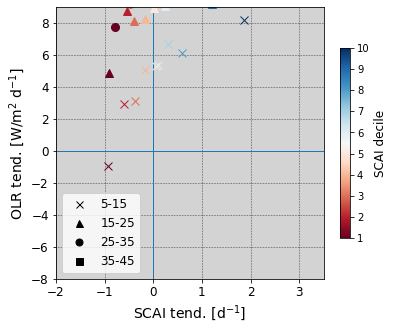

In [117]:
fig,ax = plt.subplots(figsize=(6,5))
ax.set_facecolor('lightgrey')
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

markers = ['x','^','o','s']
for i in range(4):
    for n in range(10):
        plt.plot(24*SCAI_slp[i,n],24*OLR_slp[i,n],marker=markers[i],markersize=8,color=colors[n])
# fake data for legend
plt.plot(100,100,'xk',markersize=7,label=r'5-15')
plt.plot(100,100,'^k',markersize=7,label=r'15-25')
plt.plot(100,100,'ok',markersize=7,label=r'25-35')
plt.plot(100,100,'sk',markersize=7,label=r'35-45')

# fake colorbar
a = np.array([1,2,3,4,5,6,7,8,9,10])
a = np.tile(a,(10,1))
plt.pcolormesh(range(100,110),range(100,110),a,cmap='RdBu',vmin=1,vmax=10)
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('SCAI decile',fontsize=12)

plt.hlines(y=0,xmin=-2,xmax=3.5,linewidth=1)
plt.vlines(x=0,ymin=-8,ymax=9,linewidth=1)
plt.xlim([-2,3.5]);plt.ylim([-8,9])
plt.xlabel('SCAI tend. [d$^{-1}$]',fontsize=14)
plt.ylabel('OLR tend. [W/m$^2$ d$^{-1}$]',fontsize=14)

plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.grid(linestyle=':',color='k',linewidth=0.6)
#fig.savefig(fig_dir+'OLR_SCAI_tend_allcases.pdf',bbox_inches='tight')

### Mv, Mh scatter plot for different degrees of aggregation at 0h

(-1.2, 1.0)

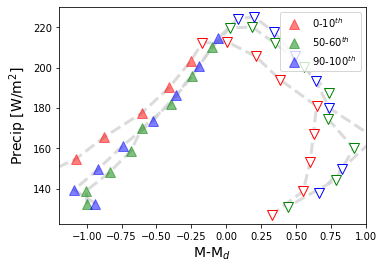

In [118]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5.5,4))
idd=0
color2 = ['r','g','b']
labels=['0-10$^{th}$','50-60$^{th}$','90-100$^{th}$']

for i,n in enumerate([1,5,8]):
    prec_tmp = running_mean(precM2_t[idd,n,:],8)
    plt.plot(Md_t[idd,n,8:16],2.5e6*prec_tmp[8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],2.5e6*prec_tmp[16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],2.5e6*prec_tmp[8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel('M-M$_d$',fontsize=14)
plt.ylabel('Precip [W/m$^2$]',fontsize=14)
#plt.vlines(x=0,ymin=0,ymax=40,linewidth=2,color='grey')
#plt.text(0.5,17,'SCAI decile',fontsize=12)
plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1])
#plt.ylim([0,320])
#fig.savefig(fig_dir+'prec_GMSspace_scatter.pdf',bbox_inches='tight')

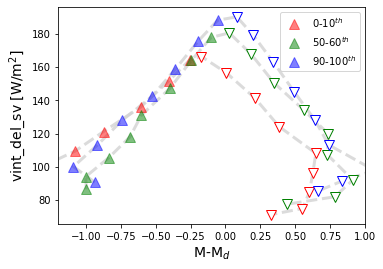

In [119]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5.5,4))
idd=0
color2 = ['r','g','b']
labels=['0-10$^{th}$','50-60$^{th}$','90-100$^{th}$']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[idd,n,8:16],(vint_hadv_s_t+vint_vadv_s_t)[idd,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],(vint_hadv_s_t+vint_vadv_s_t)[idd,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],(vint_hadv_s_t+vint_vadv_s_t)[idd,n,8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel('M-M$_d$',fontsize=14)
plt.ylabel('vint_del_sv [W/m$^2$]',fontsize=14)
#plt.vlines(x=0,ymin=0,ymax=40,linewidth=2,color='grey')
#plt.text(0.5,17,'SCAI decile',fontsize=12)
plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1]);
#plt.ylim([0,320])
#fig.savefig(fig_dir+'prec_GMSspace_scatter.pdf',bbox_inches='tight')

(-1.2, 1.0)

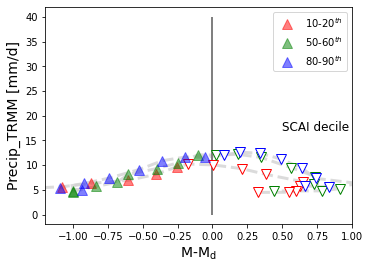

In [120]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5.5,4))
idd=0
color2 = ['r','g','b']
labels=['10-20$^{th}$','50-60$^{th}$','80-90$^{th}$']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[idd,n,8:16],24*prec_t[idd,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],24*prec_t[idd,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],24*prec_t[idd,n,8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel(r'M-M$\rm_d$',fontsize=14)
plt.ylabel('Precip_TRMM [mm/d]',fontsize=14)
#plt.title('with 1-day running mean over events')
plt.vlines(x=0,ymin=0,ymax=40,linewidth=2,color='grey')
plt.text(0.5,17,'SCAI decile',fontsize=12)
plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1])
#plt.ylim([0,25])
#fig.savefig(fig_dir+'prec_GMSspace_scatter.pdf',bbox_inches='tight')

(-1.2, 1.0)

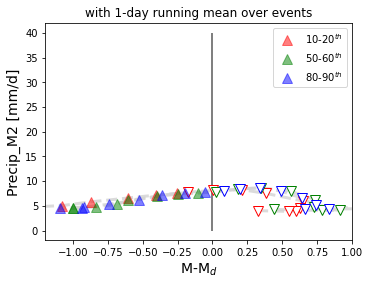

In [121]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5.5,4))
idd=0
color2 = ['r','g','b']
labels=['10-20$^{th}$','50-60$^{th}$','80-90$^{th}$']

for i,n in enumerate([1,5,8]):
    precM2_tmp = precM2_t[idd,n,:]
    plt.plot(Md_t[idd,n,8:16],86400*precM2_tmp[8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],86400*precM2_tmp[16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],86400*precM2_tmp[8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel('M-M$_d$',fontsize=14)
plt.ylabel('Precip_M2 [mm/d]',fontsize=14)
plt.title('with 1-day running mean over events')
plt.vlines(x=0,ymin=0,ymax=40,linewidth=2,color='grey')
#plt.text(0.5,17,'SCAI decile',fontsize=12)
plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1])
#plt.ylim([0,25])
#fig.savefig(fig_dir+'prec_GMSspace_scatter.pdf',bbox_inches='tight')

(-1.2, 1.0)

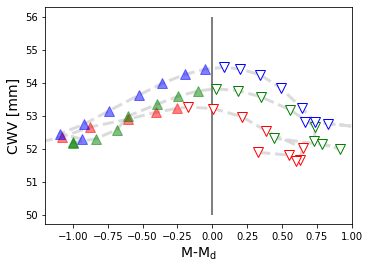

In [122]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5.5,4))
idd=0
color2 = ['r','g','b']
labels=['0-10$^{th}$','50-60$^{th}$','90-100$^{th}$']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[idd,n,8:16],cwv_t[idd,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],cwv_t[idd,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],cwv_t[idd,n,8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel(r'M-M$\rm_d$',fontsize=14)
plt.ylabel('CWV [mm]',fontsize=14)
plt.vlines(x=0,ymin=50,ymax=56,linewidth=2,color='grey')
#plt.text(0.5,53.5,'SCAI decile',fontsize=12)
#plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1])
#plt.ylim([50,56])
#fig.savefig(fig_dir+'CWV_GMSspace_scatter.pdf',bbox_inches='tight')

In [123]:
vint_sv_bins = np.linspace(0,3000,51)
prec_bins = np.linspace(0,3000,51)

vint_svtest = (vint_hadv_s_rm + vint_vadv_s_rm).flatten()
prec_M2test = precM2_all_1DRM_rm.flatten()*2.5e6 #[W/m^2]
prec_TRtest = prec_all_1DRM_rm.flatten()*2.5e6/3600 #[W/m^2]

p_com_M2 = np.zeros((len(vint_sv_bins)-1,len(prec_bins)-1))
p_com_TR = np.copy(p_com_M2)

slp,intp, rval, pval, std = linregress(vint_svtest,prec_TRtest)

for i in range(len(vint_sv_bins)-1):
    for j in range(len(prec_bins)-1):
        idx1 = np.where(np.logical_and(prec_M2test>prec_bins[j], prec_M2test<=prec_bins[j+1]))
        idx2 = np.where(np.logical_and(prec_TRtest>prec_bins[j], prec_TRtest<=prec_bins[j+1]))
        idy = np.where(np.logical_and(vint_svtest>vint_sv_bins[i], vint_svtest<=vint_sv_bins[i+1]))
        idx_comM2 = np.intersect1d(idx1,idy)
        idx_comTR = np.intersect1d(idx2,idy)
        
        p_com_M2[i,j] = len(idx_comM2)
        p_com_TR[i,j] = len(idx_comTR)

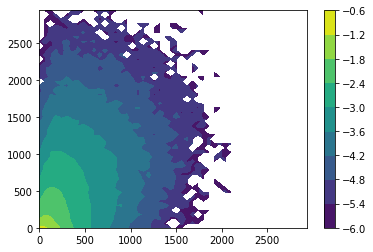

In [124]:
plt.contourf(vint_sv_bins[:-1],prec_bins[:-1],np.log10(p_com_TR/np.sum(p_com_TR)).T)
plt.colorbar()

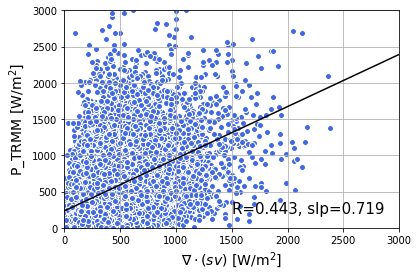

In [125]:
idx_nan1 = np.where(np.isnan(vint_hadv_s_rm[:,16])==0)
idx_nan2 = np.where(np.isnan(vint_vadv_s_rm[:,16])==0)
idx_nan = np.intersect1d(idx_nan1,idx_nan2)

test1 = np.squeeze(vint_hadv_s_rm[idx_nan,16]+vint_vadv_s_rm[idx_nan,16])
test2 = np.squeeze(2.5e6*prec_all_1DRM_rm[idx_nan,16]/3600)

slp,intp, rval, pval, std = linregress(test1,test2)
plt.scatter(test1,test2,edgecolor='w',facecolor='royalblue')
plt.plot(np.linspace(0,3000),np.linspace(0,3000)*slp+intp,'k')
plt.text(1500,200,'R='+str(round(rval,3))+', slp='+str(round(slp,3)),fontsize=15)
plt.xlim([0,3000]);plt.ylim([0,3000])
plt.xlabel(r'$\nabla\cdot(sv)$ [W/m$^2$]',fontsize=14)
plt.ylabel('P_TRMM [W/m$^2$]',fontsize=14)
plt.grid(':')

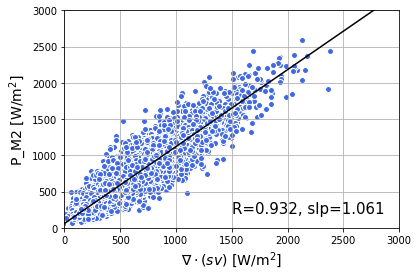

In [126]:
idx_nan1 = np.where(np.isnan(vint_hadv_s_rm[:,16])==0)
idx_nan2 = np.where(np.isnan(vint_vadv_s_rm[:,16])==0)
idx_nan = np.intersect1d(idx_nan1,idx_nan2)

test1 = np.squeeze(vint_hadv_s_rm[idx_nan,16]+vint_vadv_s_rm[idx_nan,16])
test2 = np.squeeze(2.5e6*precM2_all_1DRM_rm[idx_nan,16])

slp,intp, rval, pval, std = linregress(test1,test2)
plt.scatter(test1,test2,edgecolor='w',facecolor='royalblue')
plt.plot(np.linspace(0,3000),np.linspace(0,3000)*slp+intp,'k')
plt.text(1500,200,'R='+str(round(rval,3))+', slp='+str(round(slp,3)),fontsize=15)
plt.xlim([0,3000]);plt.ylim([0,3000])
plt.xlabel(r'$\nabla\cdot(sv)$ [W/m$^2$]',fontsize=14)
plt.ylabel('P_M2 [W/m$^2$]',fontsize=14)
plt.grid(':')

In [127]:
cwv_dec, cwvstd_dec = vars_decile_evo1D(cwv_all_rm,size=(4,10,33),opt=1)

(-1.2, 1.0)

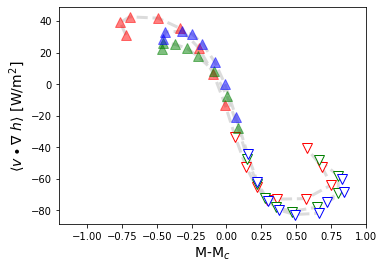

In [128]:
# scatter plot for time cycle dh/dt
fig = plt.figure(figsize=(5.5,4))
idd=1
color2 = ['r','g','b']
labels=['0-10$^{th}$','50-60$^{th}$','90-100$^{th}$']

for i,n in enumerate([0,5,9]):
    plt.plot(Md_t[idd,n,8:16],-(vint_hadv_h_t[idd,n,8:16]+vint_vadv_h_t[idd,n,8:16])+F_t[idd,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[idd,n,16:-8],-(vint_hadv_h_t[idd,n,16:-8]+vint_vadv_h_t[idd,n,16:-8])+F_t[idd,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='w')
    plt.plot(Md_t[idd,n,8:-8],-(vint_hadv_h_t[idd,n,8:-8]+vint_vadv_h_t[idd,n,8:-8])+F_t[idd,n,8:-8],'--',color='lightgrey',linewidth=3,
             alpha=0.8,zorder=0)

plt.xlabel('M-M$_c$',fontsize=14)
plt.ylabel(r'$\langle v\bullet\nabla\ h\rangle$ [W/m$^2$]',fontsize=14)
#plt.vlines(x=0,ymin=0,ymax=220,linewidth=2,color='grey')
#plt.text(0.5,53.5,'SCAI decile',fontsize=12)
#plt.legend(loc=1,framealpha=0.8)
#plt.grid(linestyle='--')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1])
#plt.ylim([20,220])
#fig.savefig(fig_dir+'CWV_GMSspace_scatter.pdf',bbox_inches='tight')

In [129]:
# for all events net imported MSE and net exported MSE after completion
MSE_net_b = np.zeros((4,10))
MSE_net_a = np.zeros((4,10))

for i in range(4):
    for j in range(10):
        MSE_net_b[i,j] = np.trapz(Md_t[i,j,8:16],dx=3600)
        MSE_net_a[i,j] = np.trapz(Md_t[i,j,16:24],dx=3600)

In [130]:
# theoretical estimate for P : dp/dt = -p(M-Mc)/tau
tau_theo = np.zeros((4,10,33))
Mc = 0.6
#prec_theo[:,:,0] = 5 
for i in range(4):
    for j in range(10):
            dpdt = np.gradient(prec_t[i,j,:],np.linspace(-48,48,33)*3600)
            pm = -prec_t[i,j,:]*(M_t[i,j,:]-Mc_t[i,j,:])
            tau_theo[i,j,:] = running_mean(pm,3)/running_mean(dpdt,3)

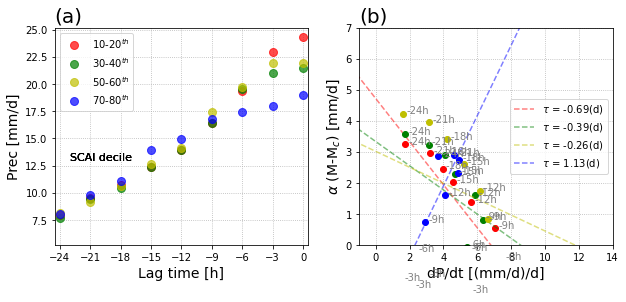

In [131]:
color_dpdt = ['r','g','y','b']
idd=2
fig, ax = plt.subplots(1,2,figsize=(10,4))
for i,n in enumerate([1,3,5,7]):
    dpdt = np.gradient(24*prec_t[idd,n,:],np.linspace(-48,48,33)/8) # [mm/day]/day
    pm = -24*(prec_t[idd,n,:]+3600*QR_t[idd,n,:]/2.5e6)*(M_t[idd,n,:]-Mc_t[idd,n,:])
    dpdt_rm = running_mean(dpdt,3)
    pm_rm = running_mean(pm,3)
    
    ax[1].plot(dpdt_rm[8:16],pm_rm[8:16],'o',color=color_dpdt[i])
    ax[1].set_ylabel(r'$\alpha$ (M-M$_c$) [mm/d]',fontsize=14)
    ax[1].set_xlabel('dP/dt [(mm/d)/d]',fontsize=14)

    for t in range(8):
        ax[1].text(dpdt_rm[t+8]+0.2,pm_rm[t+8],str(-24+3*t)+'h',color='grey')
    ax[1].set_xlim([-1,14]);ax[1].set_ylim([0,7])
    
    # least-squares slope for tau 
    slp, interp, r_val, p_val, stderr = linregress(dpdt_rm[8:16],pm_rm[8:16])
    ax[1].plot(np.linspace(-20,20),slp*np.linspace(-20,20)+interp,'--'
               ,color=color_dpdt[i],alpha=0.5,label=r'$\tau$ = '+str(round(slp,2))+'(d)')
    
    # time-series
    ax[0].plot(np.linspace(-48,48,33),24*prec_t[idd,n,:],'o',markersize=8,alpha=0.7,
               color=color_dpdt[i])
    ax[0].set_xlim(-24.5,0.5);#ax[0].set_ylim([-1,12])
    ax[0].set_xticks(np.linspace(-24,0,9))
    ax[0].set_xlabel('Lag time [h]',fontsize=14)
    ax[0].set_ylabel('Prec [mm/d]',fontsize=14)

    ax[0].legend(['10-20$^{th}$','30-40$^{th}$','50-60$^{th}$','70-80$^{th}$'])
    ax[0].text(-23,13,'SCAI decile',fontsize=11)
    ax[1].legend()
    ax[0].grid(linestyle=':')
    ax[1].grid(linestyle=':')
    
    ax[0].set_title('(a)',loc='left',fontsize=20)
    ax[1].set_title('(b)',loc='left',fontsize=20)

#    ax[0].plot(running_mean(pm,3),'k')
#    tau = running_mean(pm,3)/running_mean(86400*dpdt,3)
#     ax[1].plot(tau_theo[1,n,:16],color=colors[n])
#     ax[0].set_xlim([0,16])
#fig.savefig(fig_dir+'precip_tau_relationship_P2.pdf',bbox_tight='tight')

In [132]:
# characteristic transition time-scale for all cases
slp_dec = np.zeros((4,10))
pval_dec = np.copy(slp_dec)

for i in range(4):
    for j in range(10):
        dpdt = np.gradient(24*prec_t[i,j,:],np.linspace(-48,48,33)/8) # [mm/day]/day
        pm = -24*(prec_t[i,j,:]+3600*QR_t[i,j,:]/2.5e6)*(M_t[i,j,:]-Mc_t[i,j,:])
        dpdt_rm = running_mean(dpdt,3)
        pm_rm = running_mean(pm,3)

        #ax[1].plot(dpdt_rm[8:16],pm_rm[8:16],'o',color=color_dpdt[i])
        #ax[1].set_ylabel('-P(M-M$_c$) [mm/d]',fontsize=14)
        #ax[1].set_xlabel('dP/dt [(mm/d)/d]',fontsize=14)

        #for t in range(8):
        #    ax[1].text(dpdt_rm[t+8]+0.2,pm_rm[t+8],str(-24+3*t)+'h',color='grey')
        #ax[1].set_xlim([-1,14]);ax[1].set_ylim([1,7])

        # least-squares slope for tau 
        slp, interp, r_val, p_val, stderr = linregress(dpdt_rm[8:16],pm_rm[8:16])
        ax[1].plot(np.linspace(-20,20),slp*np.linspace(-20,20)+interp,'--'
                   ,color=color_dpdt[i],alpha=0.5,label=r'$\tau$ = '+str(round(24*slp,1))+'(h)')

        slp_dec[i,j] = slp
        pval_dec[i,j] = p_val

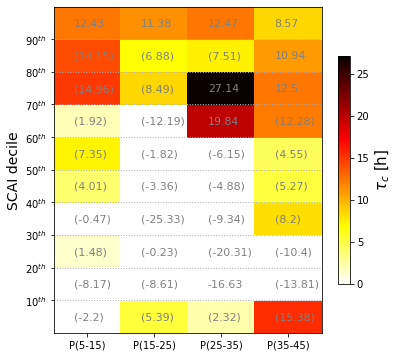

In [133]:
fig = plt.figure(figsize=(6,6))
slp_dec_sig = np.copy(slp_dec)
#slp_dec_sig[pval_dec>0.1] = np.nan
slp_dec_re = np.zeros((5,11))
slp_dec_re[:4,:10] = slp_dec_sig

plt.pcolormesh(range(5),range(11),24*slp_dec_sig.T,cmap='hot_r',vmin=0)
plt.xticks([0.5,1.5,2.5,3.5],['P(5-15)','P(15-25)','P(25-35)','P(35-45)'])
plt.yticks([1,2,3,4,5,6,7,8,9],['10$^{th}$','20$^{th}$','30$^{th}$','40$^{th}$','50$^{th}$','60$^{th}$'
                                ,'70$^{th}$','80$^{th}$','90$^{th}$'])
# add text 
for i in range(4):
    for j in range(10):
        if pval_dec[i,j] < 0.05:
            plt.text(i+0.3,j+0.4,str(round(24*slp_dec_sig[i,j],2)),color='grey',fontsize=11)
        else:
            plt.text(i+0.3,j+0.4,'('+str(round(24*slp_dec_sig[i,j],2))+')',color='grey',fontsize=11)
            
plt.ylabel('SCAI decile',fontsize=14)
plt.grid(axis='y',linestyle=':',linewidth=1)
cbar=plt.colorbar(shrink=0.7)
cbar.set_label(r'$\tau_c$ [h]',fontsize=15)
plt.show()

### GMS components decomposition

Text(0.0, 1.0, '(a)')

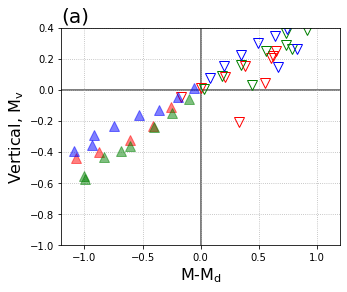

In [134]:
fig = plt.figure(figsize=(5,4))
color2 = ['r','g','b']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[0,n,8:16],Mv_t[0,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[0,n,16:-8],Mv_t[0,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='none')

plt.xlabel(r'M-M$\rm_d$',fontsize=16)
plt.ylabel(r'Vertical, M$\rm_v$',fontsize=16)
plt.vlines(x=0,ymin=-1,ymax=0.5,linewidth=2,color='grey',zorder=0)
plt.hlines(y=0,xmin=-1.2,xmax=1.2,linewidth=2,color='grey',zorder=0)
#plt.text(0.5,-0.65,'SCAI decile',fontsize=12)
#plt.legend(loc=4)
plt.grid(linestyle=':')
plt.xlim([-1.2,1.2])
plt.ylim([-1,0.4])
plt.title('(a)',fontsize=20,loc='left')
#fig.savefig(fig_dir+'Mv_GMSspace_scatter.pdf',bbox_inches='tight')

In [135]:
precM2_all.shape

(16922, 33)

Text(0.0, 1.0, '(b)')

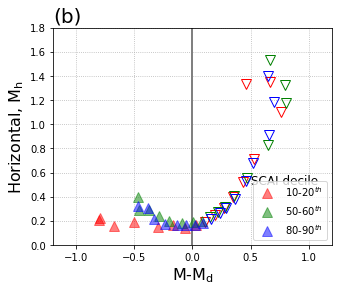

In [136]:
# scatter plot for time cycle
fig = plt.figure(figsize=(5,4))
color2 = ['r','g','b']
labels=['10-20$^{th}$','50-60$^{th}$','80-90$^{th}$']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[1,n,8:16],Mh_t[1,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[1,n,16:-8],Mh_t[1,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='none')

plt.xlabel(r'M-M$\rm_d$',fontsize=16)
plt.ylabel(r'Horizontal, M$\rm_h$',fontsize=16)
plt.vlines(x=0,ymin=0,ymax=1.8,linewidth=2,color='grey')
plt.text(0.5,0.5,'SCAI decile',fontsize=12)
plt.legend(loc=4,framealpha=0.8)
plt.grid(linestyle=':')
#plt.plot(np.linspace(-1.6,1.6,30),np.linspace(1.6,-1.6,30))
plt.xlim([-1.2,1.2])
plt.ylim([0,1.8])
plt.title('(b)',fontsize=20,loc='left')
#fig.savefig(fig_dir+'Mh_GMSspace_scatter.pdf',bbox_inches='tight')

Text(0.0, 1.0, '(c)')

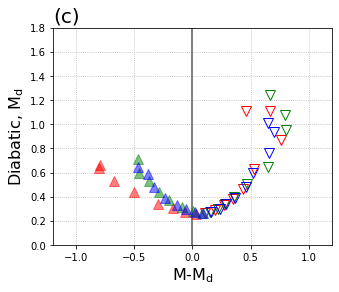

In [137]:
fig = plt.figure(figsize=(5,4))
color2 = ['r','g','b']

for i,n in enumerate([1,5,8]):
    plt.plot(Md_t[1,n,8:16],Mc_t[1,n,8:16],'^',color=color2[i],markersize=10
             ,markerfacecolor=color2[i],alpha=0.5,label=labels[i])
    plt.plot(Md_t[1,n,16:-8],Mc_t[1,n,16:-8],'v',color=color2[i],markersize=10,markerfacecolor='none')

#plt.yticks([0.2,0.4,0.6,0.8,1,1.2])
plt.xlabel(r'M-M$\rm_d$',fontsize=16)
plt.ylabel(r'Diabatic, M$\rm_d$',fontsize=16)
plt.vlines(x=0,ymin=0,ymax=1.8,linewidth=2,color='grey')
#plt.text(0.5,0.46,'SCAI decile',fontsize=12)
#plt.legend(loc=4)
plt.grid(linestyle=':')
plt.xlim([-1.2,1.2])
plt.ylim([0,1.8])
plt.title('(c)',fontsize=20,loc='left')
#fig.savefig(fig_dir+'Mc_GMSspace_scatter.pdf',bbox_inches='tight')

Text(0.0, 1.0, '(d)')

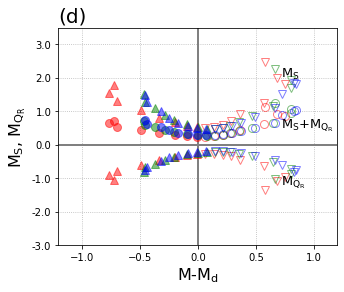

In [138]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
color2 = ['r','g','b']

for i,n in enumerate([0,5,9]):
    ax.plot(Md_t[1,n,8:16],Mc_t[1,n,8:16]-Mc_S_t[1,n,8:16],'^',color=color2[i]
             ,markersize=8,markerfacecolor=color2[i],alpha=0.5)
    ax.plot(Md_t[1,n,16:-8],Mc_t[1,n,16:-8]-Mc_S_t[1,n,16:-8],'v',color=color2[i]
             ,markersize=8,markerfacecolor='none',alpha=0.5)
    
    ax.plot(Md_t[1,n,8:16],Mc_S_t[1,n,8:16],'^',color=color2[i]
             ,markersize=8,markerfacecolor=color2[i],alpha=0.5)
    ax.plot(Md_t[1,n,16:-8],Mc_S_t[1,n,16:-8],'v',color=color2[i]
             ,markersize=8,markerfacecolor='none',alpha=0.5)
    
    ax.plot(Md_t[1,n,8:16],Mc_t[1,n,8:16],'o',color=color2[i]
             ,markersize=8,markerfacecolor=color2[i],alpha=0.5)
    ax.plot(Md_t[1,n,16:-8],Mc_t[1,n,16:-8],'o',color=color2[i]
             ,markersize=8,markerfacecolor='none',alpha=0.5)
    
ax.set_xlabel(r'M-M$\rm_d$',fontsize=16)
ax.set_ylabel(r'M$\rm_S$, M$\rm_{Q_R}$',fontsize=16)
ax.vlines(x=0,ymin=-3,ymax=3.5,linewidth=2,color='grey')
ax.hlines(y=0,xmin=-1.2,xmax=1.2,linewidth=2,color='grey')
ax.text(0.72,2,r'M$\rm_S$',fontsize=13)
ax.text(0.72,0.5,r'M$\rm_S$+M$\rm_{Q_R}$',fontsize=13)
ax.text(0.72,-1.2,r'M$\rm_{Q_R}$',fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.grid(linestyle=':')
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-3,3.5])
ax.set_title('(d)',fontsize=20,loc='left')

#fig.savefig(fig_dir+'MS_MQR_GMSspace_scatter.pdf',bbox_inches='tight')

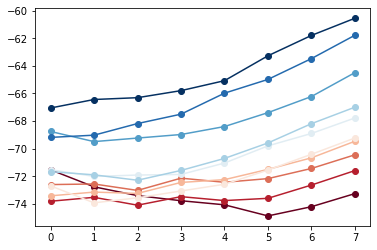

In [139]:
# radiative source evolutions for all cases
for n in range(10):
    plt.plot(QR_t[0,n,8:16],'-o',color=colors[n])

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(10,4))
# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for n in [0,4,9]:
    
#     ax[0].plot(np.linspace(-48,48,33),running_mean(Mv_t[1,n,:],3),linewidth=2,color=colors[n],label=str(n+1))
#     ax[0].set_ylabel('M-Mc',fontsize=15)
#     ax[0].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[0].vlines(x=0,ymin=-1.5,ymax=1,linewidth=1)
#     ax[0].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     #ax[0].set_ylim([-1.5,1])
#     ax[0].set_xlim([-48,48])
#     ax[0].set_title('EGMS, SCAI_decile',fontsize=14)
    
#     ax[1].plot(np.linspace(-48,48,33),running_mean(-Md_t[1,n,:]*prec_t[0,n,:]*24,3),linewidth=2,color=colors[n])
#     ax[1].set_ylabel('-P*(M-M$_c$) [mm/d]',fontsize=15)
#     ax[1].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[1].vlines(x=0,ymin=-10,ymax=15,linewidth=1)
#     ax[1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1].set_ylim([-10,15]);ax[1].set_xlim([-48,48])   
#     ax[1].set_title('-P*EGMS, SCAI_decile',fontsize=14)

# ax[0].legend(loc=4,fontsize=8)
# plt.tight_layout(w_pad=2)

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(10,4))
# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for n in [0,4,9]:
    
#     ax[0].plot(np.linspace(-48,48,33),24*prec_t[1m,n,:],linewidth=2,color=colors[n],label=str(n+1))
#     ax[0].set_ylabel('M-Mc',fontsize=15)
#     ax[0].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[0].vlines(x=0,ymin=-1.5,ymax=1,linewidth=1)
#     ax[0].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[0].set_xlim([-48,48])
    
#     ax[1].plot(np.linspace(-48,48,33),,linewidth=2,color=colors[n])
#     ax[1].set_ylabel('-P*(M-M$_c$) [mm/d]',fontsize=15)
#     ax[1].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[1].vlines(x=0,ymin=-10,ymax=15,linewidth=1)
#     ax[1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1].set_ylim([-10,15]);ax[1].set_xlim([-48,48])   
#     ax[1].set_title('-P*EGMS, SCAI_decile',fontsize=14)

# ax[0].legend(loc=4,fontsize=8)
# plt.tight_layout(w_pad=2)

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(10,4))
# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for n in np.arange(10):
    
#     ax[0].plot(np.linspace(-48,48,33),24*prec_t[1,n,:],'^',markersize=10,markerfacecolor='none',
#                color=colors[n],label=str(n+1))
#     ax[0].set_ylabel('Prec [mm/d]',fontsize=15)
#     ax[0].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[0].vlines(x=0,ymin=-0,ymax=30,linewidth=1)
#     ax[0].set_ylim([0,25])
#     ax[0].set_xlim([-25,1])
    
#     ax[1].plot(np.linspace(-48,48,33),np.gradient(24*prec_t[1,n,:],np.arange(33)*3/24),'^'
#                ,markersize=10,markerfacecolor='none',color=colors[n],label=str(n+1))
#     ax[1].set_ylabel('dP/dt [(mm/d)/d]',fontsize=15)
#     ax[1].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[1].vlines(x=0,ymin=-40,ymax=40,linewidth=1)
#     ax[1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1].set_ylim([-10,50])
#     ax[1].set_xlim([-24,24])
# ax[0].legend(loc=2,fontsize=8)
# ax[0].grid();ax[1].grid()
# plt.tight_layout(w_pad=2)

### dp/dt = -F*P(M-Mc), finding correspondent F for each SCAI decile

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(10,4))
# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))

# for n in [0,4,9]:
#     # dp/dt
#     ax[0].plot(np.linspace(-48,48,33),running_mean(-24*prec_t[1,n,:]*Md_t[1,n,:],3),linewidth=2,color=colors[n],label=str(n+1))
#     ax[0].set_ylabel('dP/dt [(mm/d)/d]',fontsize=15)
#     ax[0].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[0].vlines(x=0,ymin=-40,ymax=40,linewidth=1)
#     ax[0].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[0].set_ylim([-40,40])
#     ax[0].set_xlim([-48,48])
    
#     # dp/dt divided by -P*(M-Mc)
#     dpdt = np.gradient(24*prec_t[1,n,:],np.arange(33)*3) # (mm/d)/hr
#     PM = running_mean(-24*prec_t[1,n,:]*Md_t[1,n,:],3)
#     tau = dpdt/PM; tau[tau<0] = np.nan
#     ax[1].plot(np.linspace(-48,48,33),dpdt/PM,linewidth=2,color=colors[n],label=str(n+1))
#     ax[1].set_ylabel('Tau [hr]',fontsize=15)
#     ax[1].set_xlabel('Lag time [hr]',fontsize=15)
#     ax[1].vlines(x=0,ymin=-40,ymax=40,linewidth=1)
#     ax[1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1].set_ylim([-10,10])
#     ax[1].set_xlim([-48,48])
    
# ax[0].legend(loc=1,fontsize=8)
# plt.tight_layout(w_pad=2)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(10,9))

# for n in np.arange(9):
    
#     ax[0,0].plot(np.linspace(-48,48,33),running_mean(M_t[1,n,:],3),linewidth=2,color=colors[n])
#     ax[0,0].set_ylabel('M-Mc',fontsize=14)
#     ax[0,0].set_xlabel('Time [hr]',fontsize=14)
#     ax[0,0].vlines(x=0,ymin=-2,ymax=2,linewidth=1)
#     ax[0,0].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[0,0].set_ylim([-2,2]);ax[0,0].set_xlim([-48,48])
    
#     ax[0,1].plot(np.linspace(-48,48,33),running_mean(Mh_t[1,n,:],3),linewidth=2,color=colors[n])
#     ax[0,1].set_ylabel('Mh',fontsize=14)
#     ax[0,1].set_xlabel('Time [hr]',fontsize=14)
#     ax[0,1].vlines(x=0,ymin=-2,ymax=2,linewidth=1)
#     ax[0,1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[0,1].set_ylim([-2,2]);ax[0,1].set_xlim([-48,48])
    
#     ax[1,0].plot(np.linspace(-48,48,33),running_mean(Mv_t[1,n,:],3),linewidth=1.5,color=colors[n])
#     ax[1,0].set_ylabel('Mv',fontsize=14)
#     ax[1,0].set_xlabel('Time [hr]',fontsize=14)
#     ax[1,0].vlines(x=0,ymin=-2,ymax=2,linewidth=1)
#     ax[1,0].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1,0].set_ylim([-2,2]);ax[1,0].set_xlim([-48,48])
    
#     ax[1,1].plot(np.linspace(-48,48,33),running_mean(Mc_t[1,n,:],3),linewidth=1.5,color=colors[n])
#     ax[1,1].set_ylabel('Mc',fontsize=14)
#     ax[1,1].set_xlabel('Time [hr]',fontsize=14)
#     ax[1,1].vlines(x=0,ymin=-2,ymax=2,linewidth=1)
#     ax[1,1].hlines(y=0,xmin=-48,xmax=48,linewidth=1)
#     ax[1,1].set_ylim([-2,2]);ax[1,1].set_xlim([-48,48])
#     ax[0,0].legend(['1','2','3','4','5','6','7','8','9','10'],loc=2,fontsize=8)

In [ ]:
# h_dec = vars_decile_evo2D(h_all,size=(5,10,33,42))
# hflux_dec = vars_decile_evo2D(hflux_all,size=(5,10,33,42))
# sflux_dec = vars_decile_evo2D(sflux_all,size=(5,10,33,42))

In [ ]:
# fig,ax = plt.subplots(1,5,figsize=(20,4))

# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))
# CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

# for i in range(5):
#     for n in range(10):
#         ax[i].plot(h_dec[i,n,16,:]/1000,lev,label=str(n+1),color=colors[n])
#         ax[i].set_ylim([1000,100]);ax[i].set_xlim([327,350]);
#         ax[i].set_title('E [div | P='+labels[i]+'] (SCAI), 1E-5',fontsize=13)
#         if i ==0:
#             ax[i].legend(framealpha=0,fontsize=8)
#             ax[i].set_ylabel('[hPa]',fontsize=14)
#         ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
#         ax[i].set_xlabel('MSE [kJ/kg]',fontsize=14)
# #fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
# fig,ax = plt.subplots(1,5,figsize=(20,4))

# cmp=plt.cm.get_cmap('RdBu')
# colors=cmp(np.linspace(0,1,10))
# CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

# for i in range(5):
#     for n in range(10):
#         ax[i].plot(-omega_dec[i,n,:],lev,label=str(n+1),color=colors[n])
#         ax[i].set_ylim([1000,100]);#ax[i].set_xlim([330,360]);
#         ax[i].set_title('E [div | P='+labels[i]+'] (SCAI), 1E-5',fontsize=13)
#         if i ==0:
#             ax[i].legend(framealpha=0,fontsize=8)
#             ax[i].set_ylabel('[hPa]',fontsize=14)
#         ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
#         ax[i].set_xlabel('-omega [Pa/s]',fontsize=14)
# #fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(5):
    for n in range(10):
        dhdp = np.gradient(h_dec[i,n,16,:25],lev[:25]*100)
        ax[i].plot(omega_dec[i,n,:25]*dhdp,lev[:25],label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100]);#ax[i].set_xlim([330,360]);
        ax[i].set_title('E [div | P='+labels[i]+'] (SCAI), 1E-5',fontsize=13)
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
        ax[i].set_xlabel(r'$\omega \frac{\partial h}{\partial p}$ [J/(kg$\cdot$s)]',fontsize=14)
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        dhdp = np.gradient(h_dec[i,n,16,:25],lev[:25]*100)
        wdhdp = -(1/9.8)*np.trapz(omega_dec[i,n,:25]*dhdp,lev[:25]*100,axis=0)
        ax[i].plot(n,wdhdp,'ok')
        ax[i].set_title('E [<wdhdp> | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('SCAI decile',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel('<$\omega$dh/dp>',fontsize=14)
        ax[i].set_ylim([-100,150])
        ax[i].hlines(y=0,xmin=0,xmax=9,linewidth=1,color='grey')
        ax[i].set_xticks(np.linspace(0,9,10)); ax[i].set_xticklabels(np.linspace(1,10,10,dtype=int))

#plt.tight_layout()
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        wdhdp = -(1/9.8)*np.trapz(hflux_dec[i,n,16,:25],lev[:25]*100,axis=0)
        ax[i].plot(n,wdhdp,'ok')
        ax[i].set_title('E [<d(hv)> | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('SCAI decile',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel(r'<$\nabla$(hv)>',fontsize=14)
        #ax[i].set_ylim([-100,150])
        ax[i].hlines(y=0,xmin=0,xmax=9,linewidth=1,color='grey')
        ax[i].set_xticks(np.linspace(0,9,10)); ax[i].set_xticklabels(np.linspace(1,10,10,dtype=int))

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        wdsdp = -(1/9.8)*np.trapz(sflux_dec[i,n,16,:25],lev[:25]*100,axis=0)
        ax[i].plot(n,wdsdp,'ok')
        ax[i].set_title('E [<d(sv)> | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('SCAI decile',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel(r'<$\nabla$(sv)>',fontsize=14)
        #ax[i].set_ylim([-100,150])
        ax[i].hlines(y=0,xmin=0,xmax=9,linewidth=1,color='grey')
        ax[i].set_xticks(np.linspace(0,9,10)); ax[i].set_xticklabels(np.linspace(1,10,10,dtype=int))

In [ ]:
# M time-series for SCAI_decile
M_dec = hflux_dec/sflux_dec

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),M_dec[i,n,:])
        ax[i].set_title('E [M | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('time',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel('M',fontsize=14)

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        sv = -(1/9.8)*np.trapz(sflux_dec[i,n,16,:25],lev[:25]*100,axis=0)
        hv = -(1/9.8)*np.trapz(hflux_dec[i,n,16,:25],lev[:25]*100,axis=0)
        ax[i].plot(n,hv/sv,'ok')
        ax[i].set_title('E [<d(sv)> | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('SCAI decile',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel(r'<$\nabla$(sv)>',fontsize=14)
        #ax[i].set_ylim([-100,150])
        ax[i].hlines(y=0,xmin=0,xmax=9,linewidth=1,color='grey')
        ax[i].set_xticks(np.linspace(0,9,10)); ax[i].set_xticklabels(np.linspace(1,10,10,dtype=int))

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        wdhdp = -(1/9.8)*np.trapz(hflux_dec[i,n,16,:25],lev[:25]*100,axis=0)
        ax[i].plot(n,wdhdp,'ok')
        ax[i].set_title('E [<d(hv)> | P='+labels[i]+'] (SCAI)',fontsize=13)
        ax[i].set_xlabel('SCAI decile',fontsize=14)
        if i ==0: 
            ax[i].set_ylabel(r'<$\nabla$(hv)>',fontsize=14)
        #ax[i].set_ylim([-100,150])
        ax[i].hlines(y=0,xmin=0,xmax=9,linewidth=1,color='grey')
        ax[i].set_xticks(np.linspace(0,9,10)); ax[i].set_xticklabels(np.linspace(1,10,10,dtype=int))

#plt.tight_layout()
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))

cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(5):
    for n in range(10):
        ax[i].plot(hflux_dec[i,n,16,:],lev,label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100]);#ax[i].set_xlim([330,360]);
        ax[i].set_title('E [div | P='+labels[i]+'] (SCAI), 1E-5',fontsize=13)
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=1,color='grey')
        ax[i].set_xlabel(r'$-\omega \frac{\partial h}{\partial p}$ [J/(kg$\cdot$s)]',fontsize=14)
#fig.savefig(fig_dir+'OMEGA_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
# screen out QR>0 and vint_sv < 10 W/m^2
idx_m = np.where(np.logical_and(QR_all[:,16]<0,vint_sv[:,16]>100))[0]

In [ ]:
QR_new = QR_all[idx_m,:]
vint_sv_new = vint_sv[idx_m,:]
vint_hv_new = vint_hv[idx_m,:]
M_all_new = M_all[idx_m,:]
Mc_all_new = Mc_all[idx_m,:]
F_all_new = F_all[idx_m,:]
prec_new = prec_all[idx_m,:]

In [ ]:
plt.hist(M_all_new[:,6],bins=20,range=(-5,5))

In [ ]:
plt.hist(QR_new[:,16],bins=20)

In [ ]:
plt.scatter(vint_sv_new[:,16]/10,QR_new[:,16],'')
plt.ylim([-400,600])

In [ ]:
plt.plot(M_all[1,:])

In [ ]:
plt.plot(np.linspace(-48,48,33),np.nanmean(M_all-Mc_all,axis=0))
plt.ylim([-3,3])

In [ ]:
plt.contourf(np.linspace(-48,48,33),lev,np.nanmean(hfluxh_all,axis=0).T)
plt.ylim([1000,100])

#### Evolution 

In [ ]:
# trace back the evolution

# decile index list
cwv_dec = np.zeros((5,10,33))
cwvstd_dec = np.copy(cwv_dec)
cldfrac_dec = np.copy(cwv_dec)
prec_dec = np.copy(cwv_dec)
precstd_dec = np.copy(cwv_dec)
Abar_dec = np.copy(cwv_dec)
rh_dec = np.zeros((5,10,33,42))
cape_dec = np.copy(cwv_dec)
llws_dec = np.copy(cwv_dec)

for i in range(len(prec_bins2)-1):
    idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins2[i],24*prec_all[:,16]<prec_bins2[i+1]))[0]
    SCAI_tmp = SCAIbt_all[idx,16]
    # vars
    cldfrac_tmp = cldfrac_all[idx,:]
    Abar_tmp = Abar_all[idx,:]
    prec_tmp = prec_all[idx,:]
    precstd_tmp = precstd_all[idx,:]
    cwv_tmp = cwv_all[idx,:]
    cwvstd_tmp = cwvstd_all[idx,:]
    rh_tmp = rh_all[idx,:,:]
    cape_tmp = cape_all[idx,:]
    llws_tmp = llws_all[idx,:]

    for n in range(10):
        if n < 9:
            idx_dec = np.where(np.logical_and(SCAI_tmp>= SCAI_deciles_p[i,n],SCAI_tmp < SCAI_deciles_p[i,n+1]))[0]
        else:
            idx_dec = np.where(SCAI_tmp>= SCAI_deciles_p[i,n])[0]

        cwv_dec[i,n] = np.nanmean(cwv_tmp[idx_dec,:],axis=0)
        cwvstd_dec[i,n] = np.nanmean(cwvstd_tmp[idx_dec,:],axis=0)
        cldfrac_dec[i,n] = np.nanmean(cldfrac_tmp[idx_dec,:],axis=0)
        Abar_dec[i,n] = np.nanmean(Abar_tmp[idx_dec,:],axis=0)
        prec_dec[i,n] = np.nanmean(prec_tmp[idx_dec,:],axis=0)
        precstd_dec[i,n] = np.nanmean(precstd_tmp[idx_dec,:],axis=0)
        rh_dec[i,n,:] = np.nanmean(rh_tmp[idx_dec,:,:],axis=0)
        cape_dec[i,n,:] = np.nanmean(cape_tmp[idx_dec,:],axis=0)
        llws_dec[i,n,:] = np.nanmean(llws_tmp[idx_dec,:],axis=0)

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),Abar_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([10,225]);ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [Abar | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Abar [km]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].set_xlim([-24,24]);ax[i].vlines(x=0,ymin=0,ymax=225,linewidth=0.8,zorder=3,color='grey')
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),cldfrac_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([0,0.8]);ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [CC | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Cloud coverage',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
ymax_lab = [15,30,45,60,75]

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),24*prec_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([0,ymax_lab[i]]);
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [Pmean | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Precip [mm/d]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].set_xlim([-24,24]);ax[i].vlines(x=0,ymin=0,ymax=ymax_lab[i],linewidth=0.8)

#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),precstd_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([0,4]);ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [Pstd | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Precip std [mm/hr]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].set_xlim([-24,24]);ax[i].vlines(x=0,ymin=0,ymax=4,linewidth=0.8)
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
# normalized by 50th decile
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
CC_label=['0-0.2','0.2-0.4','0.4-0.6','0.6-0.8','0.8-1']

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),24*gaussian_filter(precstd_dec[i,n,:]-precstd_dec[i,4,:],sigma=1),label=str(n+1),color=colors[n])
        ax[i].set_ylim([-4.5,4.5]);ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [Pstd | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            #ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('$\Delta$ Pstd [mm/d]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].set_xlim([-24,24]);ax[i].vlines(x=0,ymin=-4.5,ymax=4.5,linewidth=0.8)
ax[4].legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, framealpha=0.0)
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),cwv_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([42,62]);
        ax[i].set_xlim([-24,24]);
        ax[i].set_title('E [CWV | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            #ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('CWV [mm]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].vlines(x=0,ymin=42,ymax=62,linewidth=0.8)

#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),cwvstd_dec[i,n,:]/cwv_dec[i,n,:],label=str(n+1),color=colors[n])
        ax[i].set_ylim([0.05,0.13]);
        ax[i].set_xlim([-24,24]);
        ax[i].set_title('E [CWV | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            #ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('CWVstd/CWV',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        ax[i].vlines(x=0,ymin=0.05,ymax=0.13,linewidth=0.8)

#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))
ymax_lab = [15,30,45,60,75]

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),gaussian_filter(cwvstd_dec[i,n,:]-cwvstd_dec[i,4,:],1),label=str(n+1),color=colors[n])
        #ax[i].set_ylim([0,ymax_lab[i]]);
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [CWV | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('CWVstd [mm]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
        #ax[i].set_xlim([-24,24]);ax[i].vlines(x=0,ymin=0,ymax=ymax_lab[i],linewidth=0.8)

#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),gaussian_filter(cape_dec[i,n,:],1),label=str(n+1),color=colors[n])
        ax[i].set_ylim([350,850])
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [CAPE | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('CAPE [KJ/kg]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),gaussian_filter(cin_dec[i,n,:],1),label=str(n+1),color=colors[n])
        ax[i].set_ylim([-25,-3])
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [CIN | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('CIN [KJ/kg]',fontsize=14)
        ax[i].set_xlabel('[hr]',fontsize=14);
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),gaussian_filter(llws_dec[i,n,:],1),label=str(n+1),color=colors[n])
        ax[i].set_ylim([5,9])
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [cld | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Shear index [m$^2$/s$^2$]',fontsize=14)
        ax[i].set_xlim([-48,48]);ax[i].vlines(x=0,ymin=5,ymax=9,linewidth=0.8)
        ax[i].set_xlabel('[hr]',fontsize=14);
        
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
# u, v vetical profile -12h, -6h ... 

# vertical structures of vars
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(u_dec[i,n,16,:],lev,label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100]);ax[i].set_xlim([-6,3]);
        ax[i].set_title('E [U | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].set_xlabel('U [m/s]',fontsize=14);
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=0.8,zorder=3)

#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
# u, v vetical profile -12h, -6h ... 

# vertical structures of vars
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(v_dec[i,n,14,:],lev,label=str(n+1),color=colors[n])
        ax[i].set_ylim([1000,100]);ax[i].set_xlim([-2,2]);
        ax[i].set_title('E [V | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('[hPa]',fontsize=14)
        ax[i].set_xlabel('V [m/s]',fontsize=14)
        ax[i].vlines(x=0,ymin=1000,ymax=100,linewidth=0.8,zorder=3)
        
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for i in range(5):
    for n in range(10):
        ax[i].plot(np.linspace(-48,48,33),gaussian_filter(qvflux_sfc850_dec[i,n,:],1),label=str(n+1),color=colors[n])
        #ax[i].set_ylim([5,9])
        ax[i].set_xlim([-48,48]);
        ax[i].set_title('E [cld | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax[i].legend(framealpha=0,fontsize=8)
            ax[i].set_ylabel('Shear index [m$^2$/s$^2$]',fontsize=14)
        ax[i].set_xlim([-48,48])#;ax[i].vlines(x=0,ymin=5,ymax=9,linewidth=0.8)
        ax[i].set_xlabel('[hr]',fontsize=14);
        
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

In [ ]:
omega_dec = vars_decile_evo2D(omega_all,size=(5,10,33,42))

In [ ]:
u_dec = vars_decile_evo2D(u_all,size=(5,10,33,42))

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for n,idx_scai in enumerate([0,4,9]):
    cf = ax[n].contourf(np.linspace(-48,48,33),lev,omega_dec[1,idx_scai,:,:].T,label=str(n+1)
                  ,cmap='jet',levels=np.linspace(-0.12,0.02,15))
    ax[n].contour(np.linspace(-48,48,33),lev,omega_dec[1,idx_scai,:,:].T,label=str(n+1)
                  ,levels=[0],colors=['k'])
    ax[n].set_ylim([1000,100])
    ax[n].set_xlim([-48,48]);
    ax[n].set_title('E [cld | P='+labels[i]+'] (SCAI)',fontsize=13);
    if n ==0:
        #ax[n].legend(framealpha=0,fontsize=8)
        ax[n].set_ylabel('pressure [hPa]',fontsize=14)
    ax[n].set_xlim([-48,48])#;ax[i].vlines(x=0,ymin=5,ymax=9,linewidth=0.8)
    ax[n].set_xlabel('[hr]',fontsize=14);
    cbar = plt.colorbar(cf,ax=ax[n],shrink=0.7)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

for n,idx_scai in enumerate([0,5,9]):
#     prec_tmp = np.tile(prec_dec[2,idx_scai,:],(42,1))
#     prec_tmp = prec_tmp.swapaxes(0,1)
    cf = ax[n].contourf(np.linspace(-48,48,33),lev,1e7*(qvflux_dec[4,idx_scai,:,:]).T,label=str(n+1)
                  ,cmap='BrBG_r',levels=np.linspace(-1.2,1.2,13))
    ax[n].contour(np.linspace(-48,48,33),lev,qvflux_dec[4,idx_scai,:,:].T,label=str(n+1)
                  ,levels=[0],colors=['k'])
    ax[n].set_ylim([1000,100])
    ax[n].set_xlim([-48,48]);
    #ax[n].set_title('E [cld | P='+labels[2]+'] (SCAI=)',fontsize=13);
    if n ==0:
        #ax[n].legend(framealpha=0,fontsize=8)
        ax[n].set_ylabel('pressure [hPa]',fontsize=14)
    ax[n].set_xlim([-48,48]);ax[n].vlines(x=0,ymin=100,ymax=1000,linewidth=0.8)
    ax[n].set_xlabel('[hr]',fontsize=14);
    cbar = plt.colorbar(cf,ax=ax[n],shrink=0.7)
    cbar.set_label(r'$\nabla_{h}(qv)$',fontsize=14)

ax[0].set_title('P = 65-80 mm/d, SCAI=0-10th')
ax[1].set_title('P = 65-80 mm/d, SCAI=50-60th')
ax[2].set_title('P = 65-80 mm/d, SCAI=90-100th')

In [ ]:
qvflux_dec = vars_decile_evo2D(qvflux_all,size=(5,10,33,42))

In [ ]:
# persistency of mid-level moisture convergence 
# flux convergence at 600hpa binned by cloud coverage, and differnt oceanic regions
prec_bins = np.linspace(5,100,20)
qvflux_600h = np.zeros((len(prec_bins)-1,33))
qvflux_600hstd = np.copy(qvflux_600h)

div_500h = np.zeros((len(prec_bins)-1,33))
div_500hstd = np.copy(div_500h)

for n in range(len(prec_bins)-1):
    idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins[n],24*prec_all[:,16]<prec_bins[n+1]))[0]
    qvflux_600h[n,:] = np.nanmean(qvflux_all[idx,:,14],axis=(0))
    qvflux_600hstd[n,:] = np.nanstd(qvflux_all[idx,:,14],axis=(0))/np.sqrt(len(idx))
    
    div_500h[n,:] = np.nanmean(div_all[idx,:,16],axis=(0))
    div_500hstd[n,:] = np.nanstd(div_all[idx,:,16],axis=(0))/np.sqrt(len(idx))    

In [ ]:
fig = plt.figure(figsize=(6,4))
plt.plot(prec_bins[1:]-2.5,86400*-qvflux_600h[:,16],'k')
plt.fill_between(prec_bins[1:]-2.5,86400*(-qvflux_600h[:,16]+2*qvflux_600hstd[:,16]),86400*-qvflux_600h[:,16],color='lightgrey')
plt.fill_between(prec_bins[1:]-2.5,86400*(-qvflux_600h[:,16]-2*qvflux_600hstd[:,16]),86400*-qvflux_600h[:,16],color='lightgrey')

for i in range(5):
    for n in range(10):
        plt.plot(24*prec_dec[i,n,16],86400*-qvflux_dec[i,n,16,14],'o',color=colors[n])

plt.xlim([0,100])
plt.hlines(y=0,xmin=0,xmax=100,linewidth=1)
plt.xlabel('Precipitation at 0h [mm/d]',fontsize=14)
plt.ylabel('MFlux converagence [d$^{-1}$]',fontsize=14)

In [ ]:
# convergence at 500hPa
fig = plt.figure(figsize=(6,4))
plt.plot(prec_bins[1:]-2.5,86400*-div_500h[:,16],'k')
plt.fill_between(prec_bins[1:]-2.5,86400*(-div_500h[:,16]+2*div_500hstd[:,16]),86400*-div_500h[:,16],color='lightgrey')
plt.fill_between(prec_bins[1:]-2.5,86400*(-div_500h[:,16]-2*div_500hstd[:,16]),86400*-div_500h[:,16],color='lightgrey')

for i in range(5):
    for n in range(10):
        plt.plot(24*prec_dec[i,n,16],86400*-div_dec[i,n,16,16],'o',color=colors[n]) # convergence at 500hpa

plt.xlim([0,100])
plt.hlines(y=0,xmin=0,xmax=100,linewidth=1)
plt.xlabel('Precipitation at 0h [mm/d]',fontsize=14)
plt.ylabel('Converagence at 500hPa [d$^{-1}$]',fontsize=14)

### Large-scale precipitation efficiency (Sui et al.  2005)
LSPE2 = Ps/(-Qv_tend + Qv_conv + Qhdro_conv + E)

In [ ]:
vint_qvconv_all = -np.trapz(-qvflux_all[:,:,:25], lev[:25]*100, axis=2)/9.8*2.5e6 # moisture onvergence, 1000hPa-100hPa

In [ ]:
PE_all = np.zeros(prec_all.shape)
PEM2_all = np.copy(PE_all)

for n in range(len(time_event)):
    QWVF = np.copy(vint_qvconv_all[n,:]) # [W/m^2]
    QWVT = np.copy(-cwvtend_all[n,:]*2.5e6/3600) # vapor tendency sink [W/m^2]    
    QWVF[QWVF<=0] = 0
    QWVT[QWVT<=0] = 0
    
    PEM2_all[n,:] = (2.5e6*precM2_all[n,:])/(QWVT + QWVF + LHF_all[n,:])
    PE_all[n,:] = (2.5e6*prec_all[n,:]/3600)/(QWVT + QWVF + LHF_all[n,:])

# strictly removing PE larger than 100%, more physically reasonable...
PEM2_all[PEM2_all>1] = np.nan
PE_all[PE_all>1] = np.nan

In [ ]:
PE_dec = vars_decile_evo1D(PE_all,size=(5,10,33))
PEM2_dec = vars_decile_evo1D(PEM2_all,size=(5,10,33))

In [ ]:
prec_bins = np.linspace(5,100,20)

PE_com = np.zeros((len(prec_bins)-1,33))
PE_comstd = np.copy(PE_com)
PEM2_com = np.zeros((len(prec_bins)-1,33))
PEM2_comstd = np.copy(PEM2_com)

for n in range(len(prec_bins)-1):
    idx = np.where(np.logical_and(24*prec_all[:,16]>=prec_bins[n],24*prec_all[:,16]<prec_bins[n+1]))[0]
    PEM2_com[n,:] = np.nanmean(PEM2_all[idx,:],axis=(0))
    PEM2_comstd[n,:] = np.nanstd(PEM2_all[idx,:],axis=(0))/np.sqrt(len(idx))  
    
    PE_com[n,:] = np.nanmean(PE_all[idx,:],axis=(0))
    PE_comstd[n,:] = np.nanstd(PE_all[idx,:],axis=(0))/np.sqrt(len(idx))  

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
cmp=plt.cm.get_cmap('RdBu')
colors=cmp(np.linspace(0,1,10))

ax.plot(prec_bins[1:]-2.5, PEM2_com[:,16], 'k', linewidth=2)
#plt.fill_between(prec_bins[1:]-2.5,PEM2_com[:,16]+2*PEM2_comstd[:,16],PEM2_com[:,16],color='lightgrey')
#plt.fill_between(prec_bins[1:]-2.5,PEM2_com[:,16]-2*PEM2_comstd[:,16],PEM2_com[:,16],color='lightgrey')

for i in range(5):
    for n in range(10):
        ax.plot(24*prec_dec[i,n,16],PEM2_dec[i,n,16],'o',color=colors[n],label=str(n+1))
        #ax.set_title('E [PE | P='+labels[i]+'] (SCAI)',fontsize=13);
        if i ==0:
            ax.legend(framealpha=0,fontsize=8,loc=4)
        ax.set_ylabel('LSPE',fontsize=14)
        ax.set_xlabel('Precipitation [mm/d]',fontsize=14);
ax.set_ylim([0.3,1])
ax.set_xlim([0,100])
ax.grid(linewidth=0.8)
#fig.savefig(fig_dir+'RH_profile_SCAIdecile_CCfixed.pdf',bbox_tight='tight')

### Omega vertical mode decomposition [Masunaga and L'ecuyer]

In [ ]:
def vertmode_omega(omega_data,omega_bg,fbc_mtx):
    'omega_bg: background omega profile'
    m_dim = fbc_mtx.shape[0]
    t_dim = omega_data.shape[0]
    m_time = np.zeros((m_dim,t_dim))
    omega_rcst = np.zeros(omega_data.shape) # reconstructed profile by three modes 
    for t in range(t_dim):
        omega_mtx = np.matrix((omega_data[t,:25]-omega_bg[:25])) # to 100hPa (lev=25)
        m_mtx = (fbc_mtx*fbc_mtx.T).I*(fbc_mtx*omega_mtx.T) # regression coefficient    
        m_time[:,t] = m_mtx.A.T
        omega_rcst[t,:] = m_mtx.T*fbc_mtx
    return m_time, omega_rcst

In [ ]:
# prescribed vertical mode definition
ps = 1000
ptp = 100
p = lev[:25]
fbc1 = -np.sin(1*np.pi*(p-ptp)/(ps-ptp)) # prescribed first mode
fbc2 = -np.sin(2*np.pi*(p-ptp)/(ps-ptp)) # prescribed second mode 
fshl = -np.sin(np.pi*(p-800)/(ps-800)); fshl[8:] = 0 # prescribed shallow mode, peak at 900hpa
fbc_mtx = np.stack((fbc1,fbc2,fshl),axis=0)
fbc_mtx = np.matrix(fbc_mtx)

In [ ]:
fig = plt.figure(figsize=(5,4.5))
plt.plot(fbc1,p,'-k',linewidth=2,alpha=0.8)
plt.plot(fbc2,p,'--k',linewidth=2,alpha=0.8)
plt.plot(fshl,p,':k',linewidth=2,alpha=0.8)
plt.ylim([1000,100]);plt.vlines(x=0,ymax=1000,ymin=100,linewidth=0.5)
plt.legend(['F$_1$, dc','F$_2$, st','F$_3$, cu'],fontsize=12,frameon=False)
plt.ylabel('Pressure [hPa]',fontsize=12)

In [ ]:
#fig.savefig(fig_dir+'Verticalmode_functions.pdf',bbox_inches='tight')

In [ ]:
omega_allmn = np.nanmean(omega_all,axis=0)
omega_bg = np.nanmean(np.concatenate((omega_allmn[:4,:25],omega_allmn[-4:,:25])),axis=0)

In [ ]:
em1_time = np.zeros(prec_all.shape)
em2_time = np.zeros(prec_all.shape)
em3_time = np.zeros(prec_all.shape)

for n in range(len(omega_all)):
    m_time, omega_rcst = vertmode_omega(omega_all[n,:,:25],omega_bg,fbc_mtx)
    em1_time[n,:] = m_time[0,:]
    em2_time[n,:] = m_time[1,:]
    em3_time[n,:] = m_time[2,:]

In [ ]:
omega_m1 = vars_decile_evo1D(em1_time,size=(5,10,33))
omega_m2 = vars_decile_evo1D(em2_time,size=(5,10,33))
omega_m3 = vars_decile_evo1D(em3_time,size=(5,10,33))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

for n in range(10):
    plt.plot(np.linspace(-48,48,33),omega_m1[3,n,:]/100*3600,color=colors[n])
#plt.plot(np.linspace(-48,48,33),np.nanmean(em2_time,axis=0)/100*3600,'--k')
#plt.plot(np.linspace(-48,48,33),np.nanmean(em3_time,axis=0)/100*3600,':k')
plt.hlines(y=0,xmin=-48,xmax=48,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-48,48])#;plt.ylim([-1,3])
plt.xticks(np.arange(-48,60,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
#fig.savefig(fig_dir+'vertmode_coeff_allevents.pdf',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

#plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_call_all,axis=0),'-xk')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_cu_all,axis=0),':k')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_dc_all,axis=0),'--k')
plt.plot(np.linspace(-48,48,33),np.nanmean(cldamt_st_all,axis=0),'-k')
plt.hlines(y=0,xmin=-48,xmax=48,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')
ax.set_ylim([0,80])
plt.xlim([-48,48]);plt.xticks(np.arange(-48,60,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
plt.legend(['cu','dc','st'],loc=1)

In [ ]:
plt.plot(np.nanmean(cldamt_cu_all,axis=0)/(np.nanmean(cldamt_call_all,axis=0)-np.nanmean(cldamt_dc_all,axis=0)
                                           -np.nanmean(cldamt_st_all,axis=0)))

In [ ]:
np.nanmean(cldamt_cu_all/(cldamt_call_all-cldamt_dc_all-cldamt_st_all),axis=0)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_dc_all,axis=0),'-k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_st_all,axis=0),'--k')
plt.plot(np.linspace(-72,72,49),np.nanmean(cldamt_cu_all,axis=0),':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')
ax.set_ylim([0,30])

ax2 = ax.twinx()
ax2.plot(np.linspace(-72,72,49),np.nanmean(cldamt_cu_all,axis=0)/(np.nanmean(cldamt_call_all,axis=0)-np.nanmean(cldamt_dc_all,axis=0)
                                           -np.nanmean(cldamt_st_all,axis=0)),'-k',linewidth=0.6)
#ax2.plot(np.linspace(-72,72,49),100*np.nanmean(cldamt_cu_all/(cldamt_call_all-cldamt_dc_all-cldamt_st_all)
#                                           ,axis=0),'-k',linewidth=0.8)
ax2.set_ylabel('Cu fraction',fontsize=12)

plt.xlim([-72,72]);ax2.set_ylim([0,0.3]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)
#fig.savefig(fig_dir+'vertmode_cldamt_allevents.pdf',bbox_inches='tight')

In [ ]:
em1_g1 = np.nanmean(em1_time[idx_G1,:],axis=0)
em2_g1 = np.nanmean(em2_time[idx_G1,:],axis=0)
em3_g1 = np.nanmean(em3_time[idx_G1,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g1/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g1/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g1/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
callamt_g1 = np.nanmean(cldamt_call_all[idx_G1,:],axis=0)
cuamt_g1 = np.nanmean(cldamt_cu_all[idx_G1,:],axis=0)
stamt_g1 = np.nanmean(cldamt_st_all[idx_G1,:],axis=0)
dcamt_g1 = np.nanmean(cldamt_dc_all[idx_G1,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),callamt_g1,'-xk')
plt.plot(np.linspace(-72,72,49),dcamt_g1,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g1,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g1,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,60]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g3 = np.nanmean(em1_time[idx_G3,:],axis=0)
em2_g3 = np.nanmean(em2_time[idx_G3,:],axis=0)
em3_g3 = np.nanmean(em3_time[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g3/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g3/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g3/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt_g3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt_g3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g3,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g3,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g3,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,50]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
em1_g4 = np.nanmean(em1_time[idx_G4,:],axis=0)
em2_g4 = np.nanmean(em2_time[idx_G4,:],axis=0)
em3_g4 = np.nanmean(em3_time[idx_G4,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),em1_g4/100*3600,'-k')
plt.plot(np.linspace(-72,72,49),em2_g4/100*3600,'--k')
plt.plot(np.linspace(-72,72,49),em3_g4/100*3600,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Coefficient, M [hPa/h]')

plt.xlim([-72,72]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
cuamt_g4 = np.nanmean(cldamt_cu_all[idx_G4,:],axis=0)
stamt_g4 = np.nanmean(cldamt_st_all[idx_G4,:],axis=0)
dcamt_g4 = np.nanmean(cldamt_dc_all[idx_G4,:],axis=0)

fig,ax = plt.subplots(1,1,figsize=(10,2.5))

plt.plot(np.linspace(-72,72,49),dcamt_g4,'-k')
plt.plot(np.linspace(-72,72,49),stamt_g4,'--k')
plt.plot(np.linspace(-72,72,49),cuamt_g4,':k')
plt.hlines(y=0,xmin=-72,xmax=72,color='k',linewidth=1)
plt.xlabel('hour',fontsize=12);plt.ylabel('Cloud amount [%]')

plt.xlim([-72,72]);plt.ylim([0,45]);plt.xticks(np.arange(-72,84,12))
plt.grid(linestyle=':',color='grey',linewidth=0.2)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
cuamt_g2 = np.nanmean(cldamt_cu_all[idx_G2,:],axis=0)
stamt_g2 = np.nanmean(cldamt_st_all[idx_G2,:],axis=0)
dcamt_g2 = np.nanmean(cldamt_dc_all[idx_G2,:],axis=0)

em1_g2 = np.nanmean(em1_time[idx_G2,:],axis=0)
em2_g2 = np.nanmean(em2_time[idx_G2,:],axis=0)
em3_g2 = np.nanmean(em3_time[idx_G2,:],axis=0)

cuamt_g5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt_g5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt_g5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)

em1_g5 = np.nanmean(em1_time[idx_G5,:],axis=0)
em2_g5 = np.nanmean(em2_time[idx_G5,:],axis=0)
em3_g5 = np.nanmean(em3_time[idx_G5,:],axis=0)

In [ ]:
# plot cloud amount for all categories
plt.plot(np.linspace(-72,72,49),stamt_g1)
plt.plot(np.linspace(-72,72,49),stamt_g2)
plt.plot(np.linspace(-72,72,49),stamt_g3)
plt.plot(np.linspace(-72,72,49),stamt_g4)
plt.plot(np.linspace(-72,72,49),stamt_g5)
plt.xlim([0,72])

In [ ]:
plt.plot(np.linspace(-72,72,49),em2_g1)
plt.plot(np.linspace(-72,72,49),em2_g2)
plt.plot(np.linspace(-72,72,49),em2_g3)
plt.plot(np.linspace(-72,72,49),em2_g4)
plt.plot(np.linspace(-72,72,49),em2_g5)
plt.xlim([0,72])

In [ ]:
re_stats = np.zeros((6,3,2))
re_stats[0,0,:] = np.asarray(pearsonr(em1_g1,dcamt_g1))
re_stats[0,1,:] = np.asarray(pearsonr(em2_g1,stamt_g1))    
re_stats[0,2,:] = np.asarray(pearsonr(em3_g1,cuamt_g1))    
re_stats[1,0,:] = np.asarray(pearsonr(em1_g2,dcamt_g2))    
re_stats[1,1,:] = np.asarray(pearsonr(em2_g2,stamt_g2))    
re_stats[1,2,:] = np.asarray(pearsonr(em3_g2,cuamt_g2))    
re_stats[2,0,:] = np.asarray(pearsonr(em1_g3,dcamt_g3))    
re_stats[2,1,:] = np.asarray(pearsonr(em2_g3,stamt_g3))    
re_stats[2,2,:] = np.asarray(pearsonr(em3_g3,cuamt_g3))    
re_stats[3,0,:] = np.asarray(pearsonr(em1_g4,dcamt_g4))    
re_stats[3,1,:] = np.asarray(pearsonr(em2_g4,stamt_g4))    
re_stats[3,2,:] = np.asarray(pearsonr(em3_g4,cuamt_g4))    
re_stats[4,0,:] = np.asarray(pearsonr(em1_g5,dcamt_g5))    
re_stats[4,1,:] = np.asarray(pearsonr(em2_g5,stamt_g5))    
re_stats[4,2,:] = np.asarray(pearsonr(em3_g5,cuamt_g5)) 

In [ ]:
import pandas as pd

In [ ]:
d = {'coeff_m1': re_stats[:,0,0],'p_m1': re_stats[:,0,1],
     'coeff_m2': re_stats[:,1,0],'p_m2': re_stats[:,1,1],
     'coeff_m3': re_stats[:,2,0],'p_m3': re_stats[:,2,1]}
df = pd.DataFrame(data = d)

In [ ]:
df

In [ ]:
colors = ['k','r','g','b','m']
symbals = ['x','o','^','d','s']
for n in range(5):
    plt.plot(range(3),re_stats[n,:,0],linestyle='',
             color=colors[n],marker=symbals[n],markersize=10)
plt.ylim([-1.2,1.2])

In [ ]:
fig = plt.figure(figsize=(12,3))
clevs=np.linspace(-0.09,0.015,15)*3600/100
plt.contourf(np.linspace(-72,72,49),lev,3600/100*np.nanmean(omega_all,axis=0).T,levels=clevs,
            cmap='RdBu_r',clim=(-0.09*36,0.015*36),norm=MidpointNormalize(midpoint=0,vmin=-0.09*36, vmax=0.015*36))
plt.ylim([1000,100]);cbar = plt.colorbar(pad=0.02,shrink=0.8)
cbar.set_label('[hPa/hr]')
plt.ylabel('Pressure [hPa]');plt.xlabel('hour')
fig.savefig(fig_dir+'omega_profile_exp.pdf',bbox_inches='tight')

In [ ]:
cuamt3 = np.nanmean(cldamt_cu_all[idx_G3,:],axis=0)
stamt3 = np.nanmean(cldamt_st_all[idx_G3,:],axis=0)
dcamt3 = np.nanmean(cldamt_dc_all[idx_G3,:],axis=0)
toamt3 = cuamt3+stamt3+dcamt3

plt.plot(np.convolve(cuamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt3/toamt3
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
cuamt5 = np.nanmean(cldamt_cu_all[idx_G5,:],axis=0)
stamt5 = np.nanmean(cldamt_st_all[idx_G5,:],axis=0)
dcamt5 = np.nanmean(cldamt_dc_all[idx_G5,:],axis=0)
toamt5 = cuamt5+stamt5+dcamt5

plt.plot(np.convolve(cuamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'k')
plt.plot(np.convolve(stamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'b')
plt.plot(np.convolve(dcamt5/toamt5
                      ,np.ones((5,))/5,mode='valid'),'r')
plt.ylim([0,1])

In [ ]:
-----------------------------------------------

In [ ]:
def caseview(time_event,lat_event,lon_event,lat_inc=2.5,lon_inc=2.5):

    data_sub1 = subset_MERRA2(MERRA2_3d_dir+'TQUV_3hr'
                          ,time_event,lat_event,lon_event,2,10,20)
    data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,2,10,20)
    data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event,lat_event,lon_event,2,10,20)
    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
                          ,time_event,lat_event,lon_event,2,10,20)
    data_sub5 = subset_gridsat(Gridsat_dir+'2014_2018'
                          ,time_event,lat_event,lon_event,2,10,20)
    
    u_sm = data_sub1.U
    v_sm = data_sub1.V
    T_sm = data_sub1.T
    q_sm = data_sub1.QV
    prec_sm = data_sub2.precipitation.resample(time='6H').nearest()
    cwv_sm = data_sub3.TQV.resample(time='6H').nearest()
    omega_sm = data_sub4.OMEGA
    bt_sm = data_sub5.irwin_cdr.resample(time='6H').nearest()

    u_950sm = u_sm.sel(lev=950).resample(time='6H').nearest()
    v_950sm = v_sm.sel(lev=950).resample(time='6H').nearest()
    u_tar = u_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-lat_inc,lat_event+lat_inc))
    v_tar = v_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-lat_inc,lat_event+lat_inc))
    omega_tar = omega_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-lat_inc,lat_event+lat_inc))
    prec_tar = prec_sm.sel(nlon=slice(lon_event-lon_inc,lon_event+lon_inc),nlat=slice(lat_event-lat_inc,lat_event+lat_inc))
    bt_tar = bt_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-5,lat_event+5))
    SCAIbt_sm,SCAI_p,Nbt_sm,N_prec = SCAI_index(prec_tar,bt_tar) # 6H data
    div_tar = np.gradient(u_tar,0.625*100*1e3,axis=3)+np.gradient(v_tar,0.5*100*1e3,axis=2) # divergence 3D
    
    p = T_sm.lev.values*units('mbar')
    T_tar = T_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-lat_inc,lat_event+lat_inc))
    q_tar = q_sm.sel(lon=slice(lon_event-lon_inc,lon_event+lon_inc),lat=slice(lat_event-lat_inc,lat_event+lat_inc))
    # cape/cin calculation
    cape_sm = np.zeros(len(T_tar.time))
    cin_sm = np.copy(cape_sm)
    for t in range(len(u_tar.time)):
        T_tmp = np.nanmean(T_tar[t,:,:,:],axis=(1,2))
        q_tmp = np.nanmean(q_tar[t,:,:,:],axis=(1,2))
        T = (T_tmp-273.15)*units('degC')
        q = q_tmp*units('kg/kg')
        Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q))
        
        try:
            Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC')                    
            el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
            el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))                
            ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
            [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
            cape_sm[t] = CAPE.magnitude
            cin_sm[t] = CIN.magnitude
        except:
            cape_sm[t] = np.nan
            cin_sm[t] = np.nan
    
    # Abar calculation
    tmp = bt_tar.values
    cldfrac_sm = [len(np.where(tmp[n,:,:]<240)[0])/(tmp.shape[1]*tmp.shape[2]) for n in range(tmp.shape[0])]
    Abar_sm = cldfrac_sm/Nbt_sm*1600
    
    return (u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm
            ,div_tar,cape_sm,cin_sm)

In [ ]:
idx_dec[0][0]

In [ ]:
num=18
u_950sm,v_950sm,omega_sm,prec_sm,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm,div_sm,cape_sm,cin_sm = caseview(time_event[num],lat_event[num],lon_event[num])

In [ ]:
fig,ax = plt.subplots(7,2,figsize=(12,15))

label = np.arange(0,7)
timelabel = np.array([11,12,13,14,15,16,17])

for n,t in zip(label,timelabel):
    #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax[n,0].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
    ax[n,0].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45],colors=['w'])
    ax[n,0].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
    rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,0].add_patch(rect1)
    if n ==0:
        ax[n,0].set_title(time_event[num])
        
    ax[n,1].contour(prec_sm.nlon,prec_sm.nlat,prec_sm[t,:,:].transpose(),
                   levels=[1,5,10,30,50],linewidths=1,colors=['m'])
    tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
    ax[n,1].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
    rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,1].add_patch(rect2)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+7.5,'N = '+str(int(Nbt_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+5.5,'SCAI = '+str(round(SCAIbt_sm[t],1)),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+10,lat_event[num]+3.5,'Abar = '+str(round(Abar_sm[t],1)),color='g',fontsize=11)
    if n ==0:
        ax[n,1].set_title(time_event[num])

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
SFX_bin = np.zeros((len(cldfrac_bin)-1,48)) # m/s
SFXstd_bin = np.zeros((len(cldfrac_bin)-1,48))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    SFX_bin[n,:] = np.nanmean(SFX_all[idx,:],axis=0)
    SFXstd_bin[n,:] = np.nanmean(SFXstd_all[idx,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,48,dtype=int),SFX_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
wsfc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    wsfc_bin[n,:] = np.nanmean((u_all[idx,:,0]**2+v_all[idx,:,0]**2)**0.5,axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),wsfc_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('SFX [W/m$^2$]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle=':')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
# cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
# freq_bin = np.zeros((len(cldfrac_bin)-1,4)) # m/s

# for n in range(len(cldfrac_bin)-1):
#     idx1 = np.where(np.logical_and(cldfrac_DJF[:,24]>=cldfrac_bin[n],cldfrac_DJF[:,24]<cldfrac_bin[n+1]))[0]
#     idx2 = np.where(np.logical_and(cldfrac_MAM[:,24]>=cldfrac_bin[n],cldfrac_MAM[:,24]<cldfrac_bin[n+1]))[0]
#     idx3 = np.where(np.logical_and(cldfrac_JJA[:,24]>=cldfrac_bin[n],cldfrac_JJA[:,24]<cldfrac_bin[n+1]))[0]
#     idx4 = np.where(np.logical_and(cldfrac_SON[:,24]>=cldfrac_bin[n],cldfrac_SON[:,24]<cldfrac_bin[n+1]))[0]
    
#     freq_bin[n,0] = len(idx1)
#     freq_bin[n,1] = len(idx2)
#     freq_bin[n,2] = len(idx3)
#     freq_bin[n,3] = len(idx4)

In [ ]:
# constructing the climatology over targeted scenes for T,q,RH anomaly 
# to remove seasonality and diurnal cycle
os.chdir(MERRA2_dir+'inst_2d_hourly')
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

In [ ]:
cwv = data.sel(lat=slice(-20,20)).TQV
cwv_clim = cwv.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# test for removing seasonality over all cases
cwv_rmseason = np.copy(cwv_all)

for n in range(len(time_event)):
    cwv_climsub = cwv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    cwv_rmseason[n,:] = cwv_all[n,:] - cwv_climsub.mean().values

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cwva_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cwvastd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cwva_bin[n,:] = np.nanmean(cwv_all[idx,:],axis=0)
    cwvastd_bin[n,:] = np.nanstd(cwv_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)

fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cwva_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
# prec anomaly vs cwv anomaly
fig = plt.figure(figsize=(6,6))

plt.plot(cwva_bin[0,:],preca_bin[0,:],'-k',linewidth=0.6)
plt.scatter(cwva_bin[0,:],preca_bin[0,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[1,:],preca_bin[1,:],'-r',linewidth=0.6)
plt.scatter(cwva_bin[1,:],preca_bin[1,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[2,:],preca_bin[2,:],'-g',linewidth=0.6)
plt.scatter(cwva_bin[2,:],preca_bin[2,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')
plt.plot(cwva_bin[3,:],preca_bin[3,:],'-b',linewidth=0.6)
plt.scatter(cwva_bin[3,:],preca_bin[3,:],c=np.arange(-24,25),s=80
            ,cmap=discrete_cmap(6, 'RdBu'),zorder=2,edgecolor='grey')

In [ ]:
# open T_clim, qv_clim, RH_clim 
os.chdir('/w2-data/willytsai/ISCCP/')
T_clim = xr.open_dataset('T_clim_10deg.nc')
qv_clim = xr.open_dataset('qv_clim_10deg.nc')
RH_clim = xr.open_dataset('rh_clim_10deg.nc')

In [ ]:
T_rmseason = np.copy(T_all)

for n in range(len(time_event)):
    T_climsub = T_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).T
    T_rmseason[n,:,:] = (T_all[n,:,:] - T_climsub.mean(axis=(1,2)).values)

In [ ]:
q_rmseason = np.copy(q_all)

for n in range(len(time_event)):
    q_climsub = qv_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).QV
    q_rmseason[n,:,:] = q_all[n,:,:] - q_climsub.mean(axis=(1,2)).values

In [ ]:
rh_rmseason = np.copy(rh_all)

for n in range(len(time_event)):
    rh_climsub = RH_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month).RH
    rh_rmseason[n,:,:] = rh_all[n,:,:] - rh_climsub.mean(axis=(1,2)).values

In [ ]:
# os.chdir(MERRA2_3d_dir+'RH_3hr')
# files = glob('*nc4')
# data = xr.open_mfdataset(files)

In [ ]:
# %%time
# rh = data.sel(lon=slice(50,90),lat=slice(-10,10)).RH
# rh_clim = rh.groupby('time.month').mean('time').compute() # climatology of daily data

In [ ]:
# os.chdir('/w2-data/willytsai/ISCCP')
# m2data = np.loadtxt('MERRA2_modellevs.txt')
# m2lev = np.flipud(m2data[:,1])

In [ ]:
# for m in range(12):
#     plt.plot(np.nanmean(rh_clim[m,:,:,:],axis=(1,2)),m2lev,zorder=1)
# plt.ylim([1000,150])
# plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
for m in range(12):
    plt.plot(qv_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
u = data.sel(lon=slice(50,90),lat=slice(-10,10)).U
u_clim = u.groupby('time.month').mean('time').compute() # climatology of daily data

u_rmseason = np.copy(u_all)

for n in range(len(time_event)):
    u_climsub = u_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    u_rmseason[n,:] = u_all[n,:,:] - u_climsub.mean(axis=(1,2)).values

In [ ]:
for m in range(12):
    plt.plot(u_clim[m,:,:,:].mean(axis=(1,2)),lev,zorder=1)
plt.ylim([1000,150]);plt.vlines(0,ymax=1000,ymin=0,zorder=2)
plt.xlim([-10,10])
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12'])

In [ ]:
lev_model = np.loadtxt('MERRA2_modellevs.txt')[:,1]

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
rha_bin = np.zeros((len(cldfrac_bin)-1,49,72)) # m/s
rhastd_bin = np.zeros((len(cldfrac_bin)-1,49,72))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    rha_bin[n,:,:] = np.nanmean(rh_all[idx,:,:],axis=0)
    rhastd_bin[n,:,:] = np.nanstd(rh_all[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(0.3,1,8)
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[0,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[1,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[2,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),np.flipud(lev_model),rha_bin[3,:,:].T
             ,levels=clevs,cmap='jet');
plt.colorbar();plt.ylim([1000,150]);plt.show()

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
qa_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
qastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    qa_bin[n,:,:] = np.nanmean(q_rmseason[idx,:,:],axis=0)
    qastd_bin[n,:,:] = np.nanstd(q_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs = np.linspace(-1,1,21)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[0,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[1,:,:].T*1000,cmap='jet',
            levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[2,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,qa_bin[3,:,:].T*1000,cmap='jet',
             levels=clevs
            );
plt.colorbar();plt.ylim([1000,150]);plt.show()

#plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
#          ,fontsize=9)
#plt.ylabel('CWV anomaly [mm]')
#plt.xlabel('Lag time [hr]')
#plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
Ta_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
Tastd_bin = np.zeros((len(cldfrac_bin)-1,49,42))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    Ta_bin[n,:,:] = np.nanmean(T_rmseason[idx,:,:],axis=0)
    Tastd_bin[n,:,:] = np.nanstd(T_rmseason[idx,:,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
#fig=plt.figure(figsize=(8,4))

clevs1 = np.linspace(-0.5,0.5,21)

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[0,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[1,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[2,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()

plt.contourf(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T#,levels=clevs1
             ,cmap='RdBu_r');
cbar = plt.colorbar();plt.ylim([1000,150]); cbar.set_label('T anomaly [K]')
plt.contour(np.linspace(-72,72,49,dtype=int),lev,Ta_bin[3,:,:].T
            ,levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3],colors=['k'],linewidths=0.6)
plt.ylabel('[hPa]');plt.xlabel('[hr]');plt.show()


In [ ]:
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cape_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
capestd_bin = np.zeros((len(cldfrac_bin)-1,49))
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cape_bin[n,:] = np.nanmean(cape_all[idx,:],axis=0)
    capestd_bin[n,:] = np.nanstd(cape_all[idx,:],axis=0)/np.sqrt(len(idx))
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))

plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[0,:],color='k')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[1,:],color='b')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[2,:],color='orange')
plt.plot(np.linspace(-72,72,49,dtype=int),cape_bin[3,:],color='r')

plt.legend(['0 < cldfrac < 0.1','0.1 < cldfrac < 0.25','0.25 < cldfrac < 0.5','0.5 < cldfrac < 1']
          ,fontsize=9)
plt.ylabel('CWV anomaly [mm]')
plt.xlabel('Lag time [hr]')
plt.grid(axis='x',linestyle='--')
#plt.title('Precipitation evolution, 10deg box, IND')

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
div_regress = np.zeros((len(time_event),49,42))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        for k in range(div_regress.shape[2]): # vertical dims
            tmp = prec_all[t,:];tmp2 = div_all[t,:,k]
            pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
            if len(pp) > 0: # not empty
                reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
                div_regress[t,:,k] = np.asarray(reg)
            else:
                div_regress[t,:,k] = np.nan

In [ ]:
# divergence evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
div_bin = np.zeros((len(cldfrac_bin)-1,49,42)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    div_bin[n,:,:] = np.nanmean(div_regress[idx,:,:],axis=0)
    num_bin[n] = len(idx)
    
fig=plt.figure(figsize=(8,4))
clevs = np.linspace(-0.6,0.6,17)
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[0,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[1,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[2,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

fig=plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-72,72,49,dtype=int),lev,div_bin[3,:,:].T*1e5,
             levels=clevs,cmap='PiYG',extend='both');
cbar=plt.colorbar();plt.ylim([1000,150]);cbar.set_label('s$^{-1}$/[mm/hr]');plt.show()

In [ ]:
# build cloud types climatology
os.chdir(ISCCP_dir)
files = sorted(glob('*nc'))
data = xr.open_mfdataset(files)

cldamt_types = data.cldamt_types.sel(lat=slice(-10,10),lon=slice(50,90))
cldamt_cu = cldamt_types[:,0,:,:] + cldamt_types[:,3,:,:]
cldamt_st = cldamt_types[:,13,:,:] + cldamt_types[:,16,:,:]
cldamt_dc = cldamt_types[:,14,:,:] + cldamt_types[:,17,:,:]

cu_clim = cldamt_cu.groupby('time.month').mean('time').compute() # climatology of daily data
st_clim = cldamt_st.groupby('time.month').mean('time').compute()
dc_clim = cldamt_dc.groupby('time.month').mean('time').compute()

cu_rmseason = np.copy(cldamt_cu_all)
st_rmseason = np.copy(cu_rmseason)
dc_rmseason = np.copy(cu_rmseason)

In [ ]:
for n in range(len(time_event)):
    cu_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    st_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    dc_climsub = cu_clim.sel(lat=slice(lat_event[n]-5,lat_event[n]+5),
                          lon=slice(lon_event[n]-5,lon_event[n]+5),month=time_event[n].month)
    
    cu_rmseason[n,:] = cldamt_cu_all[n,:] - cu_climsub.mean(axis=(0,1)).values
    st_rmseason[n,:] = cldamt_st_all[n,:] - st_climsub.mean(axis=(0,1)).values
    dc_rmseason[n,:] = cldamt_dc_all[n,:] - dc_climsub.mean(axis=(0,1)).values

In [ ]:
%%time
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # cldfrac at ref
cldamt_cu_regress = np.zeros((len(time_event),49))
cldamt_st_regress = np.zeros((len(time_event),49))
cldamt_dc_regress = np.zeros((len(time_event),49))

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_cu_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_cu_regress[t,:] = np.asarray(reg)
        else:
            cldamt_cu_regress[t,:] = np.nan
            
for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_st_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_st_regress[t,:] = np.asarray(reg)
        else:
            cldamt_st_regress[t,:] = np.nan

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]

    for t in idx: # samples
        tmp = prec_all[t,:];tmp2 = cldamt_dc_all[t,:]
        pp = tmp[~np.isnan(tmp2)]; qq = tmp2[~np.isnan(tmp2)]  
        if len(pp) > 0: # not empty
            reg = [np.polyfit(pp,np.roll(qq,-lag),deg=1)[0] for lag in range(-24,25)]
            cldamt_dc_regress[t,:] = np.asarray(reg)
        else:
            cldamt_dc_regress[t,:] = np.nan

In [ ]:
# cloud type evolution
cldfrac_bin = np.array([0,0.1,0.25,0.5,1]) # mm/day
cldamt_cu_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_st_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
cldamt_dc_bin = np.zeros((len(cldfrac_bin)-1,49)) # m/s
num_bin = np.copy(cldfrac_bin)*0

for n in range(len(cldfrac_bin)-1):
    idx = np.where(np.logical_and(cldfrac_all[:,24]>=cldfrac_bin[n],cldfrac_all[:,24]<cldfrac_bin[n+1]))[0]
    cldamt_cu_bin[n,:] = np.nanmean(cldamt_cu_regress[idx,:],axis=0)
    cldamt_st_bin[n,:] = np.nanmean(cldamt_st_regress[idx,:],axis=0)    
    cldamt_dc_bin[n,:] = np.nanmean(cldamt_dc_regress[idx,:],axis=0)
    num_bin[n] = len(idx)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,6))

ax[0,0].plot(cldamt_cu_bin[0,:],'k')
ax[0,0].plot(cldamt_st_bin[0,:],'b')
ax[0,0].plot(cldamt_dc_bin[0,:],'r')

ax[0,1].plot(cldamt_cu_bin[1,:],'k')
ax[0,1].plot(cldamt_st_bin[1,:],'b')
ax[0,1].plot(cldamt_dc_bin[1,:],'r')

ax[1,0].plot(cldamt_cu_bin[2,:],'k')
ax[1,0].plot(cldamt_st_bin[2,:],'b')
ax[1,0].plot(cldamt_dc_bin[2,:],'r')

ax[1,1].plot(cldamt_cu_bin[3,:],'k')
ax[1,1].plot(cldamt_st_bin[3,:],'b')
ax[1,1].plot(cldamt_dc_bin[3,:],'r')

plt.show()

In [ ]:
lon_event.min()

In [ ]:
-------------------

In [ ]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [ ]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [ ]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [ ]:
def SCAI_index_bt(bt_sm,cri_val=240):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=cri_val,flag=2) # less than 240 K
        label_new, num_new = scai.label_remove(label_obj, N, connect_min=3) # remove obj with pixel numb. < 3
        SCAI_BT[t] = scai.SCAI_calc(label_new,num_new,dx=0.1*100000,L=5*100000)
        N_psT[t] = num_new

    return (SCAI_BT,N_psT)

In [ ]:
def caseview(time_event,lat_event,lon_event):

    data_sub1 = subset_MERRA2(MERRA2_3d_dir+'TQUV_3hr'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub2 = subset_TRMM(TRMM_dir+'2009_2018'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
                          ,time_event,lat_event,lon_event,2,5,5)
    data_sub5 = subset_gridsat(Gridsat_dir+'2009_2018'
                          ,time_event,lat_event,lon_event,2,5,5)
    
    u_sm = data_sub1.U
    v_sm = data_sub1.V
    T_sm = data_sub1.T
    q_sm = data_sub1.QV
    prec_sm = data_sub2.precipitation.resample(time='3H').nearest()
    cwv_sm = data_sub3.TQV.resample(time='3H').nearest()
    omega_sm = data_sub4.OMEGA
    bt_sm = data_sub5.irwin_cdr.resample(time='3H').nearest()

    u_950sm = u_sm.sel(lev=950).resample(time='3H').nearest()
    v_950sm = v_sm.sel(lev=950).resample(time='3H').nearest()
    u_tar = u_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    v_tar = v_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    omega_tar = omega_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    prec_tar = prec_sm.sel(nlon=slice(lon_event-2.5,lon_event+2.5),nlat=slice(lat_event-2.5,lat_event+2.5))
    bt_tar = bt_sm.sel(lon=slice(lon_event-2.5,lon_event+2.5),lat=slice(lat_event-2.5,lat_event+2.5))
    SCAIbt_sm, Nbt_sm = SCAI_index_bt(bt_tar,cri_val=240)  
    div_tar = np.gradient(u_tar,0.625*100*1e3,axis=3)+np.gradient(v_tar,0.5*100*1e3,axis=2) # divergence 3D
    
    p = T_sm.lev.values*units('mbar')
    T_tar = T_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
    q_tar = q_sm.sel(lon=slice(lon_event-5,lon_event+5),lat=slice(lat_event-5,lat_event+5))
#     # cape/cin calculation
#     cape_sm = np.zeros(len(T_tar.time))
#     cin_sm = np.copy(cape_sm)
#     for t in range(len(u_tar.time)):
#         T_tmp = np.nanmean(T_tar[t,:,:,:],axis=(1,2))
#         q_tmp = np.nanmean(q_tar[t,:,:,:],axis=(1,2))
#         T = (T_tmp-273.15)*units('degC')
#         q = q_tmp*units('kg/kg')
#         Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q))
        
#         try:
#             Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC')                    
#             el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
#             el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))                
#             ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
#             [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
#             cape_sm[t] = CAPE.magnitude
#             cin_sm[t] = CIN.magnitude
#         except:
#             cape_sm[t] = np.nan
#             cin_sm[t] = np.nan
    
    # Abar calculation
    tmp = bt_tar.values
    cldfrac_sm = [len(np.where(tmp[n,:,:]<240)[0])/(tmp.shape[1]*tmp.shape[2]) for n in range(tmp.shape[0])]
    Abar_sm = cldfrac_sm/Nbt_sm*2500
    
    return (u_950sm,v_950sm,omega_sm,prec_sm,prec_tar,cwv_sm,bt_sm,SCAIbt_sm,Nbt_sm,Abar_sm
            ,div_tar)

In [ ]:
tmp = idx_dec[1][0] 
tmp

In [ ]:
tmp_grouped = tmp[:500].reshape(50,10)

In [ ]:
tmp_grouped[1,:]

In [ ]:
label = np.arange(0,7)
timelabel = np.array([12,14,16,18,20])
fig,ax = plt.subplots(len(timelabel),2,figsize=(6,15))

for n,t in zip(label,timelabel):
    #ax[n] = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax[n,0].pcolormesh(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:])
    ax[n,0].quiver(u_950sm.lon[::2],u_950sm.lat[::2],u_950sm[t,::2,::2],v_950sm[t,::2,::2])      
    ax[n,0].contour(cwv_sm.lon,cwv_sm.lat,cwv_sm[t,:,:],levels=[45,50,55],colors=['w'])
    rect1 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None')
    ax[n,0].add_patch(rect1)
    if n ==0:
        ax[n,0].set_title(time_event[num])
    ax[n,0].set_aspect('equal', adjustable='box')
    
    # right plot    
    ax[n,1].contour(prec_sm.nlon,prec_sm.nlat,prec_sm[t,:,:].transpose(),
                   levels=[1,5,10,30,50],linewidths=1,colors=['m'])
    tmp = bt_sm[t,:,:].values; #tmp[tmp>240] = np.nan
    ax[n,1].pcolormesh(bt_sm.lon,bt_sm.lat,tmp,cmap='binary_r') 
    rect2 = patches.Rectangle((lon_event[num]-2.5,lat_event[num]-2.5),5,5,linewidth=2,
                              edgecolor='r',facecolor='None',zorder=4)
    ax[n,1].add_patch(rect2)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+3.5,'N = '+str(int(Nbt_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+2.5,'SCAI = '+str(round(SCAIbt_sm[t],1)),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+1.5,'Abar = '+str(round(Abar_sm[t])),color='g',fontsize=11)
    ax[n,1].text(lon_event[num]+5.7,lat_event[num]+0.4,r'$\rm\overline{P}$ = '+str(round(24*np.nanmean(prec_tar[t,:,:]),1)),color='g',fontsize=11)    
    if n ==0:
        ax[n,1].set_title(time_event[num])
    ax[n,1].set_aspect('equal', adjustable='box')
    ax[n,1].set_xlim(lon_event[num]-5,lon_event[num]+5)
    
#plt.tight_layout(h_pad=0.05)
#fig.savefig(fig_dir+'Aggre_showcase_P1D1_T18.pdf',bbox_inches='tight')